## 데이터셋 확인 및 설정

./data/cifar10에 이미 5000개의 이미지가 있습니다.
총 5000개 이미지 로드됨

5개의 무작위 샘플 시각화:

샘플 1:


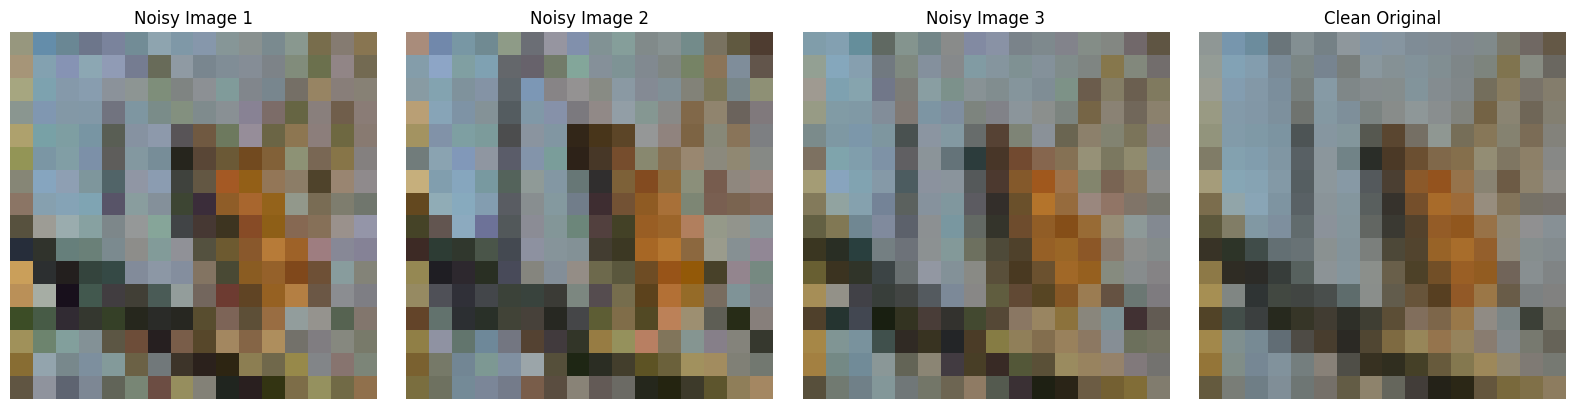


샘플 2:


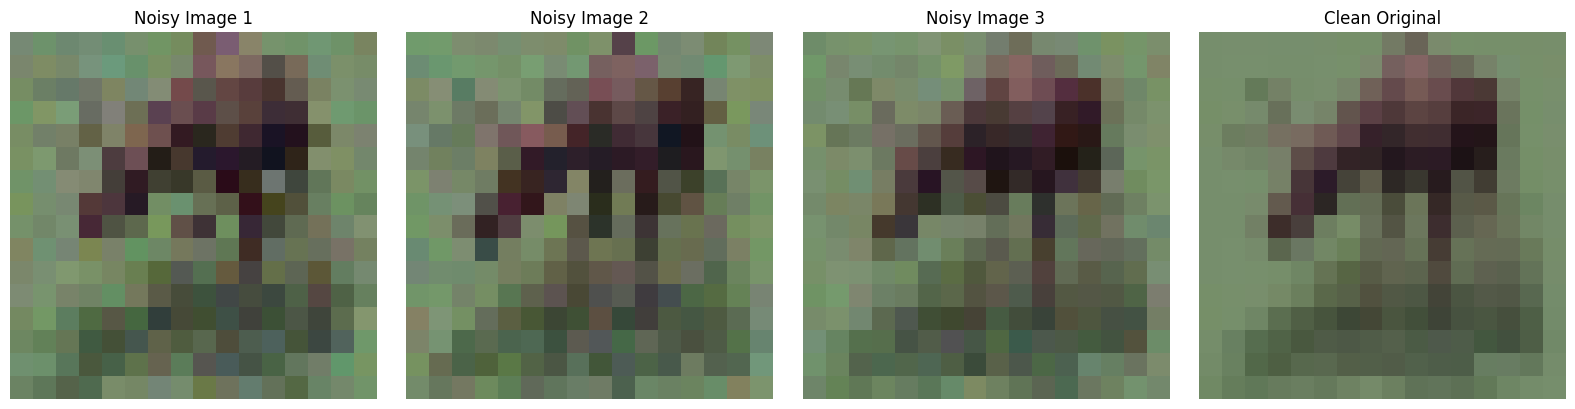


샘플 3:


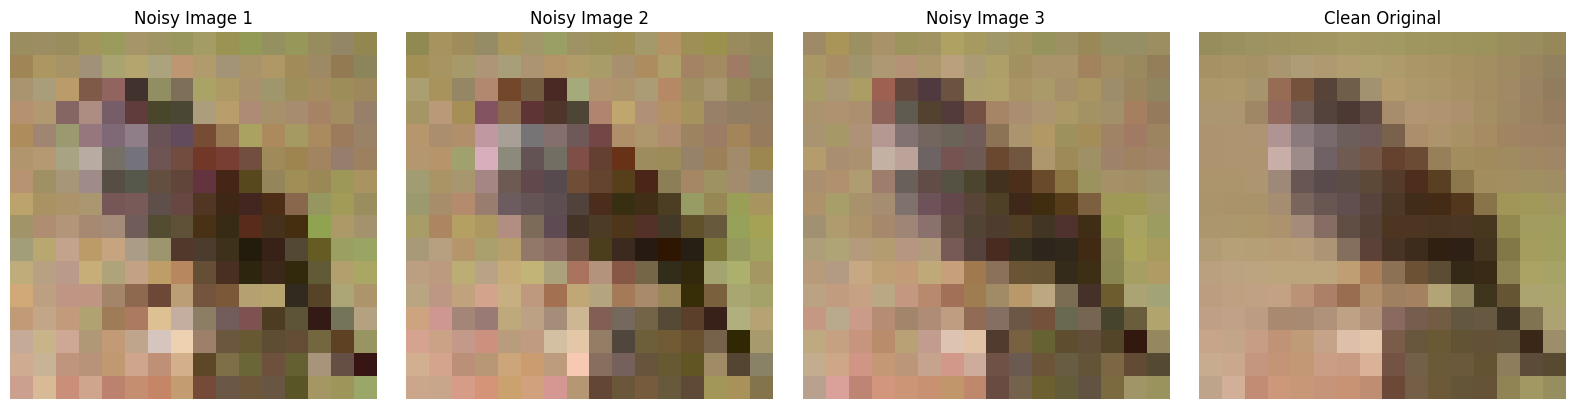


샘플 4:


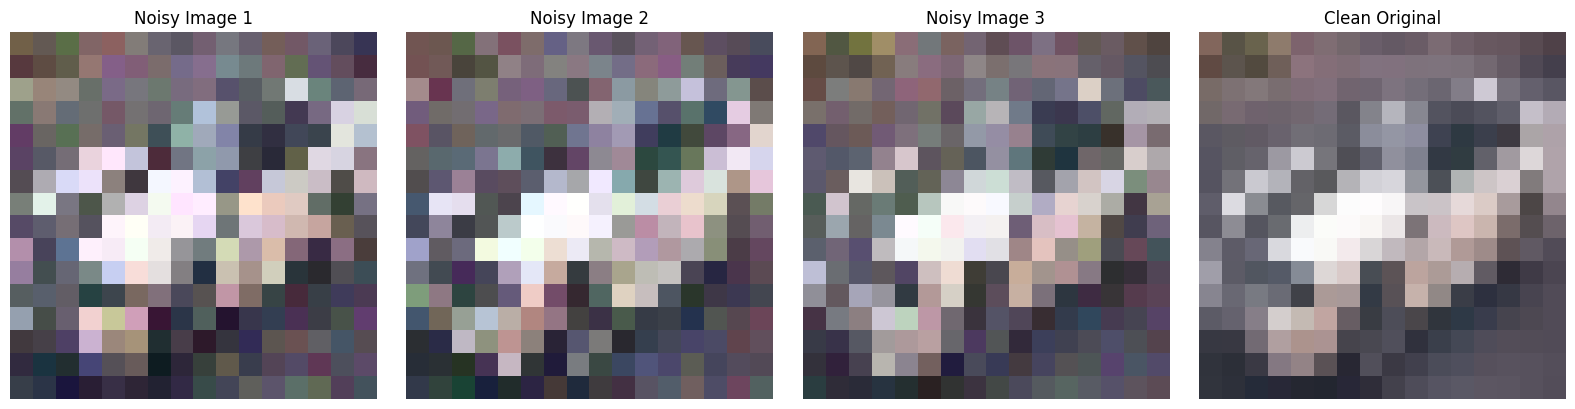


샘플 5:


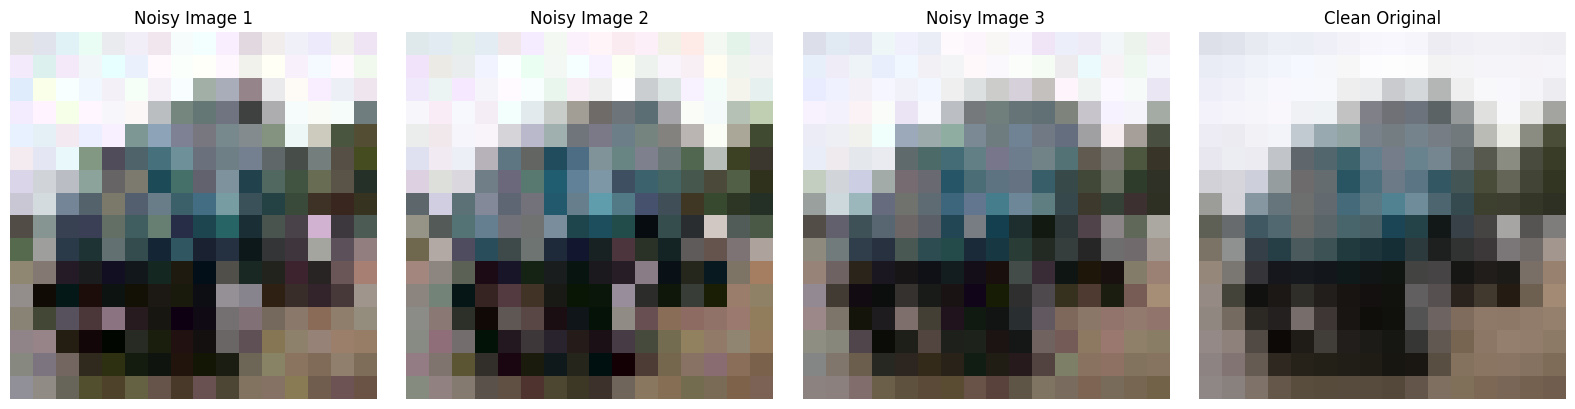


배치 형태: 4개의 이미지, 각각의 크기: torch.Size([4, 3, 16, 16])
이 중 처음 3개는 노이즈가 추가된 분할 이미지이고, 마지막은 깨끗한 원본 이미지입니다.


In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# 랜덤 시드 고정
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

class NoisyKernelSamplingDataset(Dataset):
    def __init__(self, image_dir, transform=None, kernel_size=2, num_samples=3, noise_level=0.05):
        """
        원본 이미지에 가우시안 노이즈를 추가한 뒤 3장으로 분리
        원본 이미지도 절반 크기로 저장
        
        Args:
            image_dir (str): 이미지 디렉토리 경로
            transform (torchvision.transforms): 이미지 변환용 transform
            kernel_size (int): 커널 크기 (2로 고정)
            num_samples (int): 분리할 이미지 수 (기본값: 3)
            noise_level (float): 가우시안 노이즈의 표준편차 (기본값: 0.05)
        """
        self.image_dir = image_dir
        self.transform = transform
        self.kernel_size = kernel_size
        self.num_samples = num_samples
        self.noise_level = noise_level
        
        # 이미지 파일 목록 가져오기
        self.image_paths = []
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        
        for file in os.listdir(image_dir):
            ext = os.path.splitext(file)[1].lower()
            if ext in valid_extensions:
                self.image_paths.append(os.path.join(image_dir, file))
                
        print(f"총 {len(self.image_paths)}개 이미지 로드됨")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 이미지 로드
        img_path = self.image_paths[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
            
            # 기본 전처리
            if self.transform:
                img = self.transform(img)
            else:
                img = transforms.ToTensor()(img)
            
            # 이미지 크기
            c, h, w = img.shape
            
            # 짝수 크기로 맞추기
            if h % 2 != 0:
                h = h - 1
            if w % 2 != 0:
                w = w - 1
                
            # 잘린 이미지 사용
            img = img[:, :h, :w]
            
            # 원본 이미지를 절반 크기로 줄이기 (4번째 이미지로 사용)
            # 다운샘플링 - 각 2x2 영역의 4개 픽셀 평균
            original_downsampled = F.avg_pool2d(img.unsqueeze(0), kernel_size=2, stride=2).squeeze(0)
            
            # 노이즈 추가한 이미지 생성
            random_noise_level = random.uniform(0.02, self.noise_level)
            noisy_img = img + torch.randn_like(img) * random_noise_level
            noisy_img = torch.clamp(noisy_img, 0, 1)  # [0, 1] 범위로 클램핑
            
            # 출력 이미지 초기화 (절반 크기)
            out_h, out_w = h // 2, w // 2
            output_imgs = [torch.zeros((c, out_h, out_w)) for _ in range(self.num_samples)]
            
            # 각 2x2 커널을 순회하면서 픽셀 샘플링
            for y_block in range(0, h, self.kernel_size):
                for x_block in range(0, w, self.kernel_size):
                    # 현재 2x2 블록의 픽셀 위치
                    positions = [
                        (y_block, x_block),
                        (y_block, x_block + 1),
                        (y_block + 1, x_block),
                        (y_block + 1, x_block + 1)
                    ]
                    
                    # 3개 위치 무작위 선택
                    selected_positions = random.sample(positions, self.num_samples)
                    
                    # 출력 이미지의 해당 위치 계산
                    out_y, out_x = y_block // 2, x_block // 2
                    
                    # 선택된 픽셀을 각 출력 이미지에 배치 (노이즈가 추가된 이미지로부터)
                    for i, (y, x) in enumerate(selected_positions):
                        output_imgs[i][:, out_y, out_x] = noisy_img[:, y, x]
            
            # output_imgs에 원본 다운샘플링 이미지 추가 (4번째 항목)
            return tuple(output_imgs + [original_downsampled])
        
        except Exception as e:
            print(f"오류 발생: {e}, 이미지 경로: {img_path}")
            dummy = torch.zeros((3, 16, 16))  # CIFAR-10은 32x32이므로 절반 크기는 16x16
            return tuple([dummy] * (self.num_samples + 1))  # +1은 원본 다운샘플링 이미지

class NoisyKernelSamplingDataset_2(Dataset):
    def __init__(self, image_dir, transform=None, kernel_size=2, num_samples=2, noise_level=0.05):
        """
        원본 이미지에 가우시안 노이즈를 추가한 뒤 분리:
        - 2개는 무작위 선택 픽셀
        - 1개는 나머지 2개 픽셀의 평균
        - 1개는 원본 다운샘플링
        
        Args:
            image_dir (str): 이미지 디렉토리 경로
            transform (torchvision.transforms): 이미지 변환용 transform
            kernel_size (int): 커널 크기 (2로 고정)
            num_random_samples (int): 무작위로 선택할 픽셀 수 (기본값: 2)
            noise_level (float): 가우시안 노이즈의 표준편차 (기본값: 0.05)
        """
        self.image_dir = image_dir
        self.transform = transform
        self.kernel_size = kernel_size
        self.num_samples = num_samples
        self.noise_level = noise_level
        
        # 총 이미지 수 (무작위 선택 + 평균 이미지 + 원본 다운샘플링)
        self.total_images = num_samples + 1 + 1
        
        # 이미지 파일 목록 가져오기
        self.image_paths = []
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        
        for file in os.listdir(image_dir):
            ext = os.path.splitext(file)[1].lower()
            if ext in valid_extensions:
                self.image_paths.append(os.path.join(image_dir, file))
                
        print(f"총 {len(self.image_paths)}개 이미지 로드됨")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 이미지 로드
        img_path = self.image_paths[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
            
            # 기본 전처리
            if self.transform:
                img = self.transform(img)
            else:
                img = transforms.ToTensor()(img)
            
            # 이미지 크기
            c, h, w = img.shape
            
            # 짝수 크기로 맞추기
            if h % 2 != 0:
                h = h - 1
            if w % 2 != 0:
                w = w - 1
                
            # 잘린 이미지 사용
            img = img[:, :h, :w]
            
            # 원본 이미지를 절반 크기로 줄이기 (4번째 이미지로 사용)
            # 다운샘플링 - 각 2x2 영역의 4개 픽셀 평균
            original_downsampled = F.avg_pool2d(img.unsqueeze(0), kernel_size=2, stride=2).squeeze(0)
            
            # 노이즈 추가한 이미지 생성
            random_noise_level = random.uniform(0.02, self.noise_level)
            noisy_img = img + torch.randn_like(img) * random_noise_level
            noisy_img = torch.clamp(noisy_img, 0, 1)  # [0, 1] 범위로 클램핑
            
            # 출력 이미지 초기화 (절반 크기)
            out_h, out_w = h // 2, w // 2
            # 2개의 무작위 선택 이미지와 1개의 평균 이미지
            random_imgs = [torch.zeros((c, out_h, out_w)) for _ in range(self.num_samples)]
            avg_img = torch.zeros((c, out_h, out_w))
            
            # 각 2x2 커널을 순회하면서 픽셀 샘플링
            for y_block in range(0, h, self.kernel_size):
                for x_block in range(0, w, self.kernel_size):
                    # 현재 2x2 블록의 픽셀 위치
                    positions = [
                        (y_block, x_block),
                        (y_block, x_block + 1),
                        (y_block + 1, x_block),
                        (y_block + 1, x_block + 1)
                    ]
                    
                    # 무작위로 2개 위치 선택
                    selected_positions = random.sample(positions, self.num_samples)
                    
                    # 선택되지 않은 나머지 위치
                    remaining_positions = [pos for pos in positions if pos not in selected_positions]
                    
                    # 출력 이미지의 해당 위치 계산
                    out_y, out_x = y_block // 2, x_block // 2
                    
                    # 선택된 픽셀을 각 출력 이미지에 배치 (노이즈가 추가된 이미지로부터)
                    for i, (y, x) in enumerate(selected_positions):
                        random_imgs[i][:, out_y, out_x] = noisy_img[:, y, x]
                    
                    # 선택되지 않은 2개 픽셀의 평균을 계산하여 3번째 이미지에 배치
                    avg_pixel = torch.zeros((c))
                    for y, x in remaining_positions:
                        avg_pixel += noisy_img[:, y, x]
                    avg_pixel /= len(remaining_positions)
                    avg_img[:, out_y, out_x] = avg_pixel
            
            # 결과 이미지들을 튜플로 반환 (무작위 2개 + 평균 1개 + 원본 다운샘플링 1개)
            return tuple(random_imgs + [avg_img, original_downsampled])
        
        except Exception as e:
            print(f"오류 발생: {e}, 이미지 경로: {img_path}")
            dummy = torch.zeros((3, 16, 16))  # CIFAR-10은 32x32이므로 절반 크기는 16x16
            return tuple([dummy] * self.total_images)  # 총 4개 이미지 반환

# CIFAR-10 데이터셋을 이미지 파일로 저장하는 함수
def prepare_cifar10_dataset(output_dir='./data/cifar10', num_images=1000):
    """
    CIFAR-10 데이터셋을 다운로드하고 이미지 파일로 저장
    
    Args:
        output_dir (str): 이미지를 저장할 디렉토리
        num_images (int): 저장할 이미지 수
    """
    # 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    # 이미 이미지가 있는지 확인
    existing_images = [f for f in os.listdir(output_dir) if f.endswith('.png')]
    if len(existing_images) >= num_images:
        print(f"{output_dir}에 이미 {len(existing_images)}개의 이미지가 있습니다.")
        return
    
    # CIFAR-10 다운로드
    print("CIFAR-10 데이터셋 다운로드 중...")
    cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    
    # 이미지 저장
    print(f"이미지 파일로 저장 중... (총 {min(num_images, len(cifar10_data))}개)")
    for i in tqdm(range(min(num_images, len(cifar10_data)))):
        img, label = cifar10_data[i]
        img.save(os.path.join(output_dir, f'cifar10_{i:05d}_class{label}.png'))
    
    print("CIFAR-10 이미지 저장 완료")

# 시각화 함수 (샘플 결과 보기)
def visualize_samples(dataset, idx=None):
    """데이터셋에서 샘플을 시각화합니다"""
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    
    samples = dataset[idx]
    num_samples = len(samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 4, 4))
    
    for i, img in enumerate(samples):
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img.permute(1, 2, 0).clamp(0, 1).numpy())
        title = "Clean Original" if i == num_samples-1 else f'Noisy Image {i+1}'
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# 메인 실행 코드
if __name__ == "__main__":
    # CIFAR-10 이미지 준비 (없으면 다운로드)
    image_dir = './data/cifar10'
    prepare_cifar10_dataset(output_dir=image_dir, num_images=500)
    
    # 노이즈 레벨 설정
    noise_level = 0.05  # 약한 가우시안 노이즈

    # 데이터셋 생성
    dataset = NoisyKernelSamplingDataset_2(
        image_dir=image_dir,
        kernel_size=2,
        # num_samples=3,
        noise_level=noise_level
    )
    
    # 무작위 샘플 시각화
    print("\n5개의 무작위 샘플 시각화:")
    for i in range(5):
        print(f"\n샘플 {i+1}:")
        visualize_samples(dataset)
    
    # 데이터로더 생성 및 배치 크기 확인
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    # 첫 번째 배치 가져와서 크기 확인
    sample_batch = next(iter(dataloader))
    print(f"\n배치 형태: {len(sample_batch)}개의 이미지, 각각의 크기: {sample_batch[0].shape}")
    print(f"이 중 처음 3개는 노이즈가 추가된 분할 이미지이고, 마지막은 깨끗한 원본 이미지입니다.")

## 학습에 필요한 함수 선언

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time


# 입력용 데이터셋 래퍼 클래스 (2개 concat + 1개 타겟)
class DnCNNDatasetWrapper(Dataset):
    def __init__(self, kernel_dataset, input_indices=(0, 1), target_index=2):
        """
        3개 이미지 중 2개는 입력으로 concat하고, 1개는 타겟으로 사용하는 래퍼 클래스
        
        Args:
            kernel_dataset: KernelSamplingDataset 인스턴스
            input_indices: 입력으로 사용할 이미지 인덱스 (기본값: 0, 1)
            target_index: 타겟으로 사용할 이미지 인덱스 (기본값: 2)
        """
        self.kernel_dataset = kernel_dataset
        self.input_indices = input_indices
        self.target_index = target_index
    
    def __len__(self):
        return len(self.kernel_dataset)
    
    def __getitem__(self, idx):
        # KernelSamplingDataset에서 3개의 이미지 가져오기
        imgs = self.kernel_dataset[idx]
        
        # 입력 이미지 2개를 채널 차원으로 concat
        input_imgs = [imgs[i] for i in self.input_indices]
        input_concat = torch.cat(input_imgs, dim=0)  # 채널 차원 결합 (3채널 -> 6채널)
        
        # 타겟 이미지
        target_img = imgs[self.target_index]
        clean_img = imgs[-1]  # 깨끗한 원본 이미지
        
        return input_concat, target_img, clean_img

# CIFAR-10 데이터셋을 이미지 파일로 저장하는 함수
def prepare_cifar10_dataset(output_dir='./data/cifar10', num_images=1000):
    """
    CIFAR-10 데이터셋을 다운로드하고 이미지 파일로 저장
    
    Args:
        output_dir (str): 이미지를 저장할 디렉토리
        num_images (int): 저장할 이미지 수
    """
    # 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    # 이미 이미지가 있는지 확인
    existing_images = [f for f in os.listdir(output_dir) if f.endswith('.png')]
    if len(existing_images) >= num_images:
        print(f"{output_dir}에 이미 {len(existing_images)}개의 이미지가 있습니다.")
        return
    
    # CIFAR-10 다운로드
    print("CIFAR-10 데이터셋 다운로드 중...")
    cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    
    # 이미지 저장
    print(f"이미지 파일로 저장 중... (총 {min(num_images, len(cifar10_data))}개)")
    for i in tqdm(range(min(num_images, len(cifar10_data)))):
        img, label = cifar10_data[i]
        img.save(os.path.join(output_dir, f'cifar10_{i:05d}_class{label}.png'))
    
    print("CIFAR-10 이미지 저장 완료")

# 시각화 함수
def visualize_input_target_output(model, dataloader, device, num_samples=3):
    """모델의 입력, 타겟, 출력을 시각화합니다"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 5, figsize=(16, 4*num_samples))
    
    with torch.no_grad():
        for i, (inputs, targets, cleans) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            cleans = cleans.to(device)
            
            # 모델 예측
            outputs = model(inputs)
            
            # 시각화
            # 입력 이미지 1 (채널 0-2)
            axes[i, 0].imshow(inputs[0, :3].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 0].set_title('Input Image 1')
            axes[i, 0].axis('off')
            
            # 입력 이미지 2 (채널 3-5)
            axes[i, 1].imshow(inputs[0, 3:].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 1].set_title('Input Image 2')
            axes[i, 1].axis('off')
            
            # 타겟 이미지
            axes[i, 2].imshow(targets[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 2].set_title('Target Image')
            axes[i, 2].axis('off')
            
            # 깨끗한 원본 이미지
            axes[i, 3].imshow(cleans[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            axes[i, 3].set_title('Clean Original Image')
            axes[i, 3].axis('off')
            
            # 출력 이미지
            axes[i, 4].imshow(outputs[0].cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            
            # PSNR 계산
            mse = F.mse_loss(outputs[0], targets[0]).item()
            psnr = -10 * np.log10(mse) if mse > 0 else 100
            axes[i, 4].set_title(f'Output Image (PSNR: {psnr:.2f}dB)')
            axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.show()

# 학습 함수
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, ca=None, noise_level=0.05):
    """
    DnCNN 모델 학습 함수
    
    Args:
        model: DnCNN 모델
        train_loader: 학습 데이터로더
        val_loader: 검증 데이터로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 에폭 수
        device: 학습 디바이스 (cuda 또는 cpu)
    """
    model.to(device)
    best_val_loss = float('inf')
    
    # 학습 기록
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        train_loss = 0.0
        
        # 학습
        for inputs, targets, cleans in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, targets, cleans = inputs.to(device), targets.to(device), cleans.to(device)
            
            # 그래디언트 초기화
            optimizer.zero_grad()
            
            # 순전파
            outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 역전파
            loss.backward()
            
            # 가중치 업데이트
            optimizer.step()
            
            # 손실 누적
            train_loss += loss.item() * inputs.size(0)
        
        # 에폭 평균 손실
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        
        with torch.no_grad():
            for inputs, targets, cleans in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, targets, cleans = inputs.to(device), targets.to(device), cleans.to(device)
                
                # 순전파
                outputs = model(inputs)
                
                # 손실 계산
                loss = criterion(outputs, targets)
                
                # 손실 누적
                val_loss += loss.item() * inputs.size(0)
                
                # PSNR 계산
                for i in range(outputs.size(0)):
                    mse = F.mse_loss(outputs[i], cleans[i]).item()
                    psnr = -10 * np.log10(mse) if mse > 0 else 100
                    val_psnr += psnr
        
        # 에폭 평균 손실 및 PSNR
        val_loss = val_loss / len(val_loader.dataset)
        val_psnr = val_psnr / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val PSNR: {val_psnr:.2f}dB")
        
        # 모델 저장 (가장 좋은 검증 손실)
        if ca is not None:
            model_name = f'best_unet_model_{ca}_{noise_level}.pth'
        else:
            model_name = f'best_unet_model_{noise_level}.pth'
        model_path = os.path.join('./checkpoints', model_name)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"모델 저장됨 (Val Loss: {val_loss:.4f})")
        
        # 중간 결과 시각화 (5에폭마다)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            visualize_input_target_output(model, val_loader, device, num_samples=3)
    
    # 학습 곡선 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


## DnCNN 모델 학습 및 시각화

./data/cifar10에 이미 5000개의 이미지가 있습니다.
총 5000개 이미지 로드됨
데이터 형태 확인:
입력 형태: torch.Size([256, 6, 16, 16]) (배치, 채널, 높이, 너비)
타겟 형태: torch.Size([256, 3, 16, 16]) (배치, 채널, 높이, 너비)
깨끗한 원본 형태: torch.Size([256, 3, 16, 16]) (배치, 채널, 높이, 너비)
Target and clean images are different.
사용 장치: cuda
모델 파라미터 수: 31039491


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch 1/50 - Train Loss: 0.1618, Val Loss: 0.4080, Val PSNR: 10.84dB
모델 저장됨 (Val Loss: 0.4080)


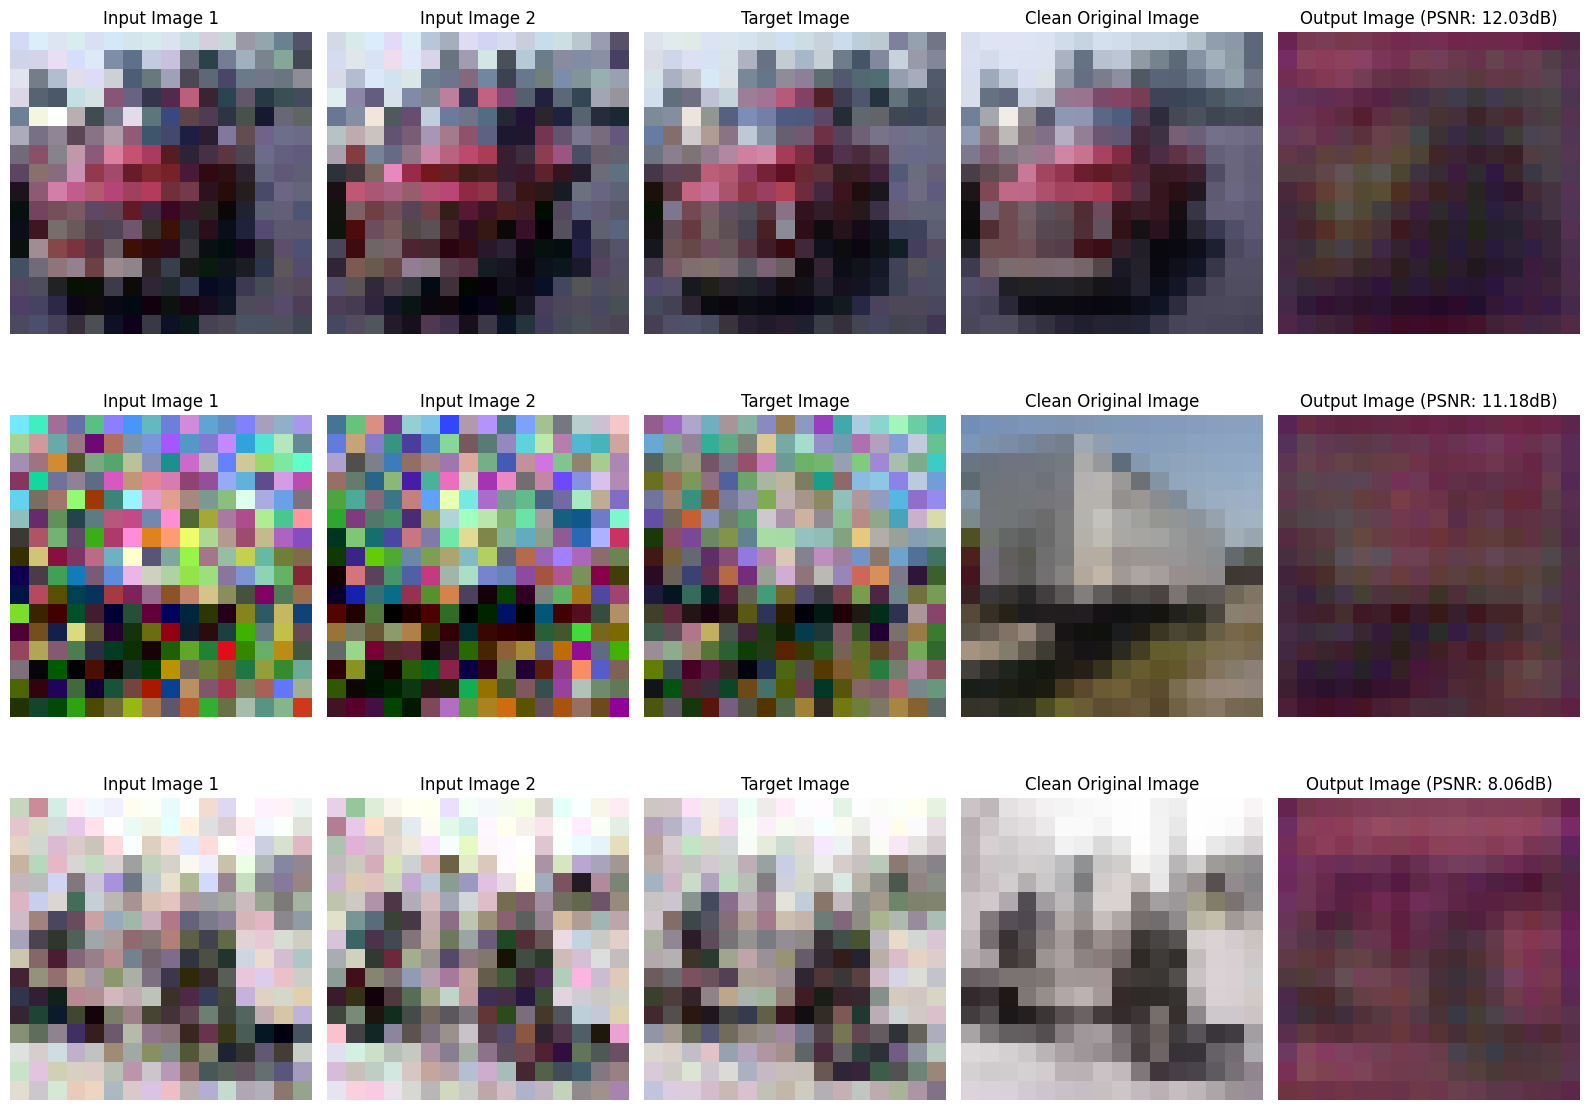

Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 2/50 - Train Loss: 0.0191, Val Loss: 0.0604, Val PSNR: 18.24dB
모델 저장됨 (Val Loss: 0.0604)


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch 3/50 - Train Loss: 0.0159, Val Loss: 0.0219, Val PSNR: 21.28dB
모델 저장됨 (Val Loss: 0.0219)


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 4/50 - Train Loss: 0.0146, Val Loss: 0.0139, Val PSNR: 22.64dB
모델 저장됨 (Val Loss: 0.0139)


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 5/50 - Train Loss: 0.0140, Val Loss: 0.0133, Val PSNR: 23.21dB
모델 저장됨 (Val Loss: 0.0133)


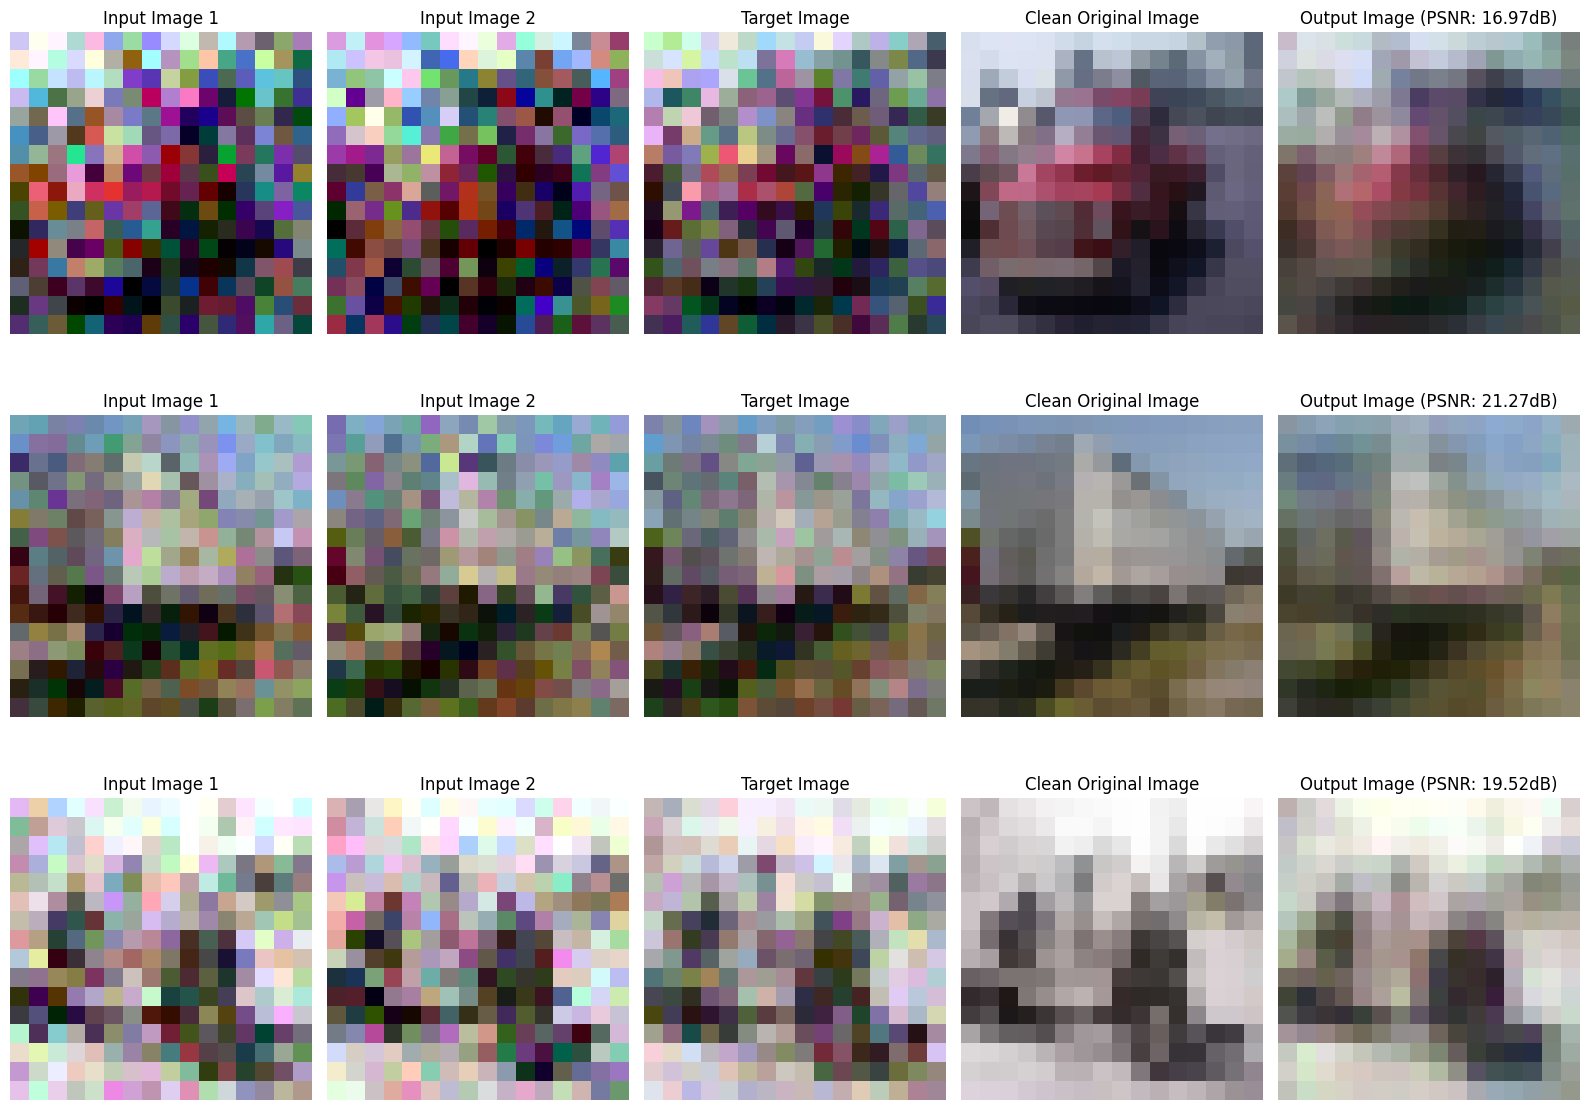

Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 6/50 - Train Loss: 0.0137, Val Loss: 0.0143, Val PSNR: 23.10dB


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 7/50 - Train Loss: 0.0135, Val Loss: 0.0130, Val PSNR: 23.68dB
모델 저장됨 (Val Loss: 0.0130)


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Epoch 8/50 - Train Loss: 0.0132, Val Loss: 0.0131, Val PSNR: 23.80dB


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.36s/it]


Epoch 9/50 - Train Loss: 0.0130, Val Loss: 0.0140, Val PSNR: 23.57dB


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 10/50 - Train Loss: 0.0131, Val Loss: 0.0130, Val PSNR: 23.77dB


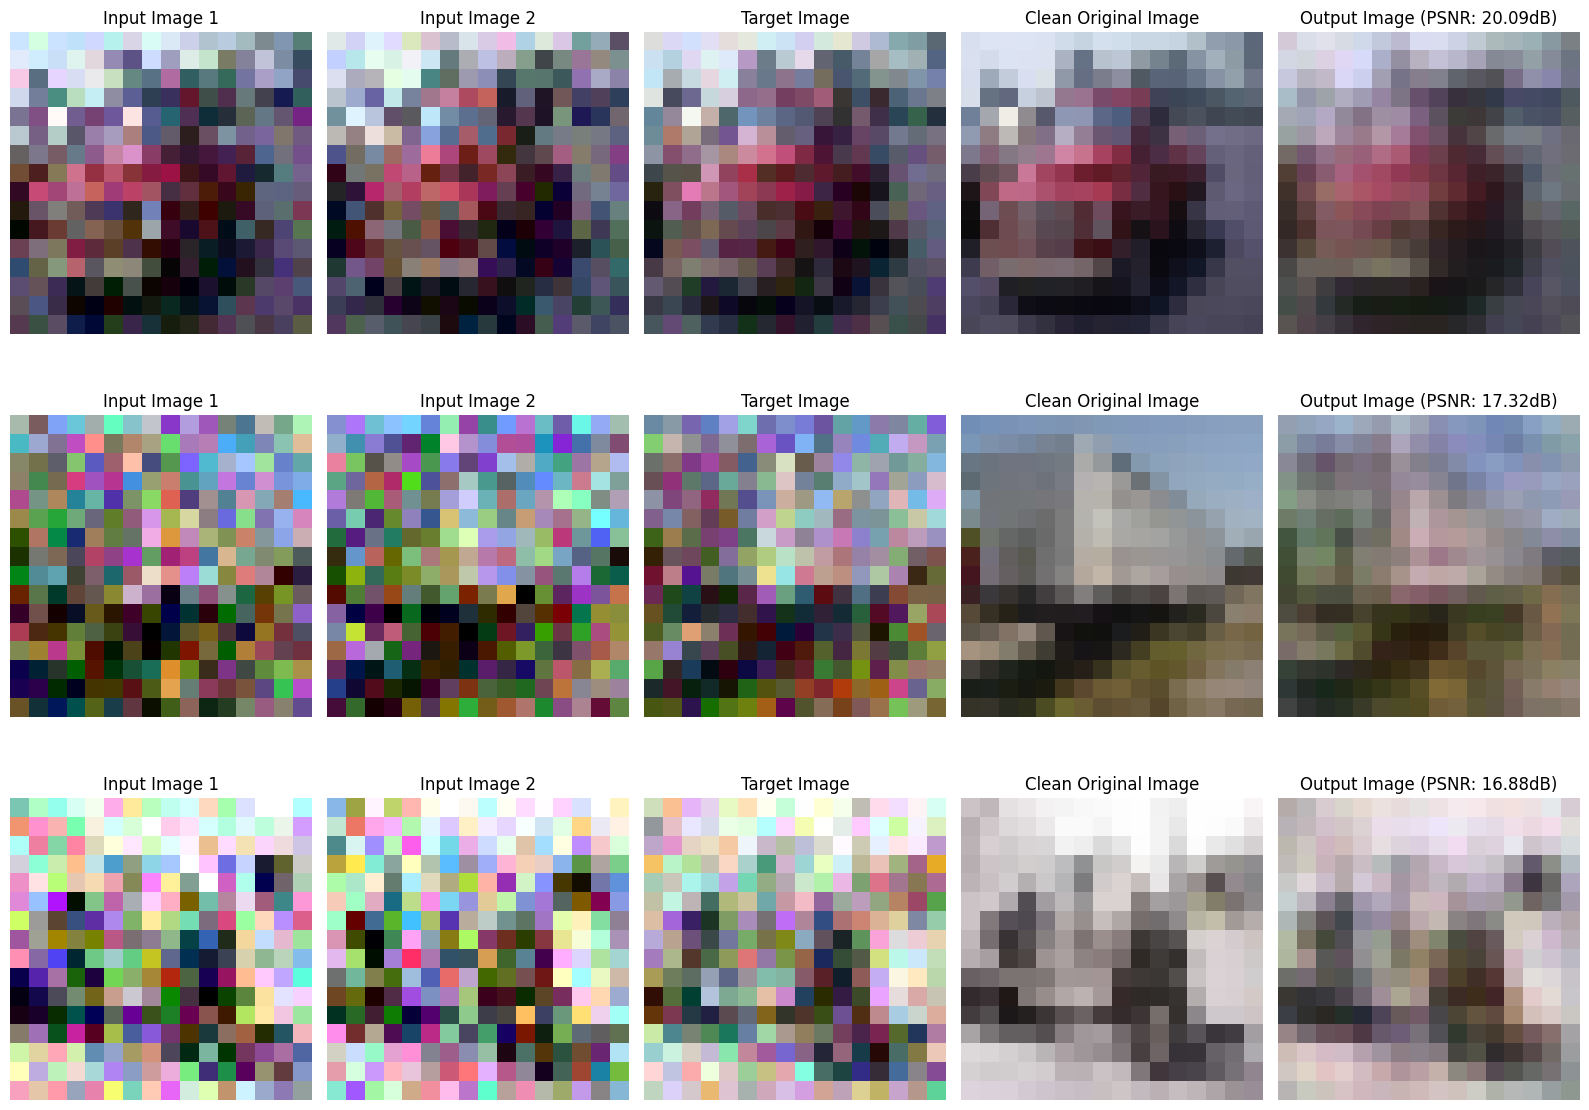

Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


Epoch 11/50 - Train Loss: 0.0131, Val Loss: 0.0125, Val PSNR: 24.14dB
모델 저장됨 (Val Loss: 0.0125)


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]


Epoch 12/50 - Train Loss: 0.0129, Val Loss: 0.0136, Val PSNR: 23.78dB


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 13/50 - Train Loss: 0.0131, Val Loss: 0.0129, Val PSNR: 23.97dB


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.38s/it]


Epoch 14/50 - Train Loss: 0.0128, Val Loss: 0.0125, Val PSNR: 24.28dB
모델 저장됨 (Val Loss: 0.0125)


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.29s/it]


Epoch 15/50 - Train Loss: 0.0129, Val Loss: 0.0124, Val PSNR: 24.55dB
모델 저장됨 (Val Loss: 0.0124)


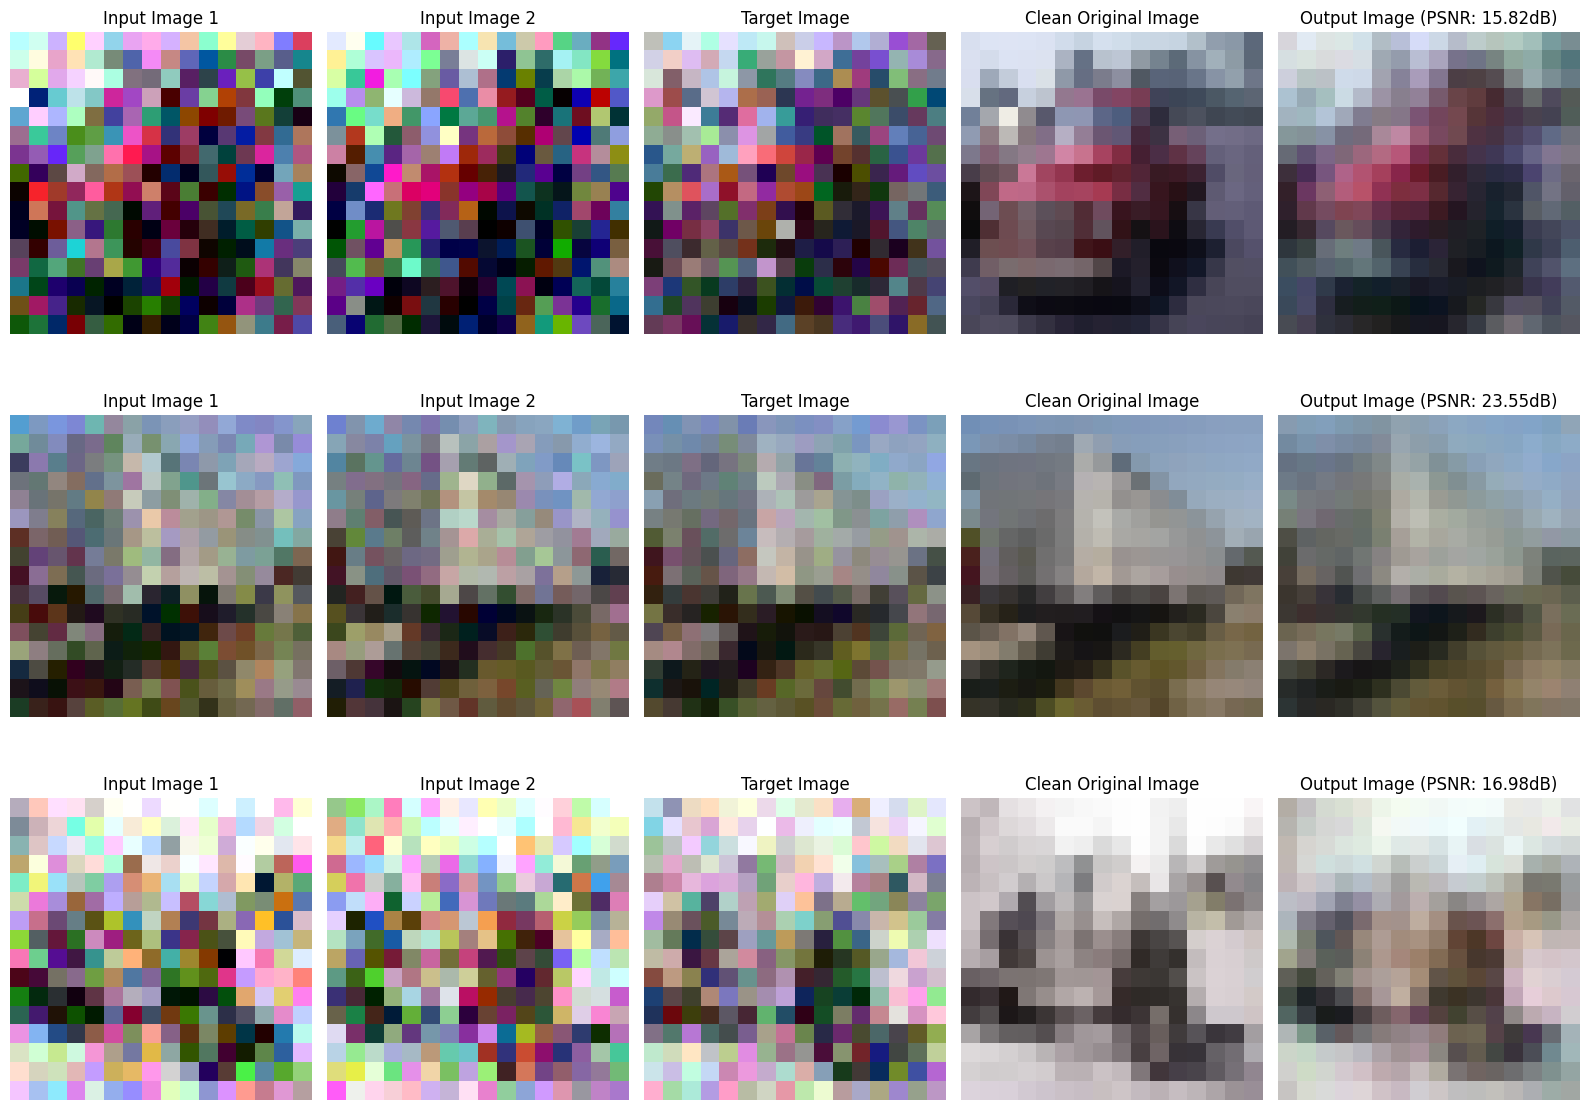

Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 16/50 - Train Loss: 0.0125, Val Loss: 0.0131, Val PSNR: 24.13dB


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 17/50 - Train Loss: 0.0125, Val Loss: 0.0124, Val PSNR: 24.25dB


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.42s/it]


Epoch 18/50 - Train Loss: 0.0128, Val Loss: 0.0125, Val PSNR: 24.60dB


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.40s/it]


Epoch 19/50 - Train Loss: 0.0124, Val Loss: 0.0132, Val PSNR: 24.26dB


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 20/50 - Train Loss: 0.0127, Val Loss: 0.0125, Val PSNR: 24.53dB


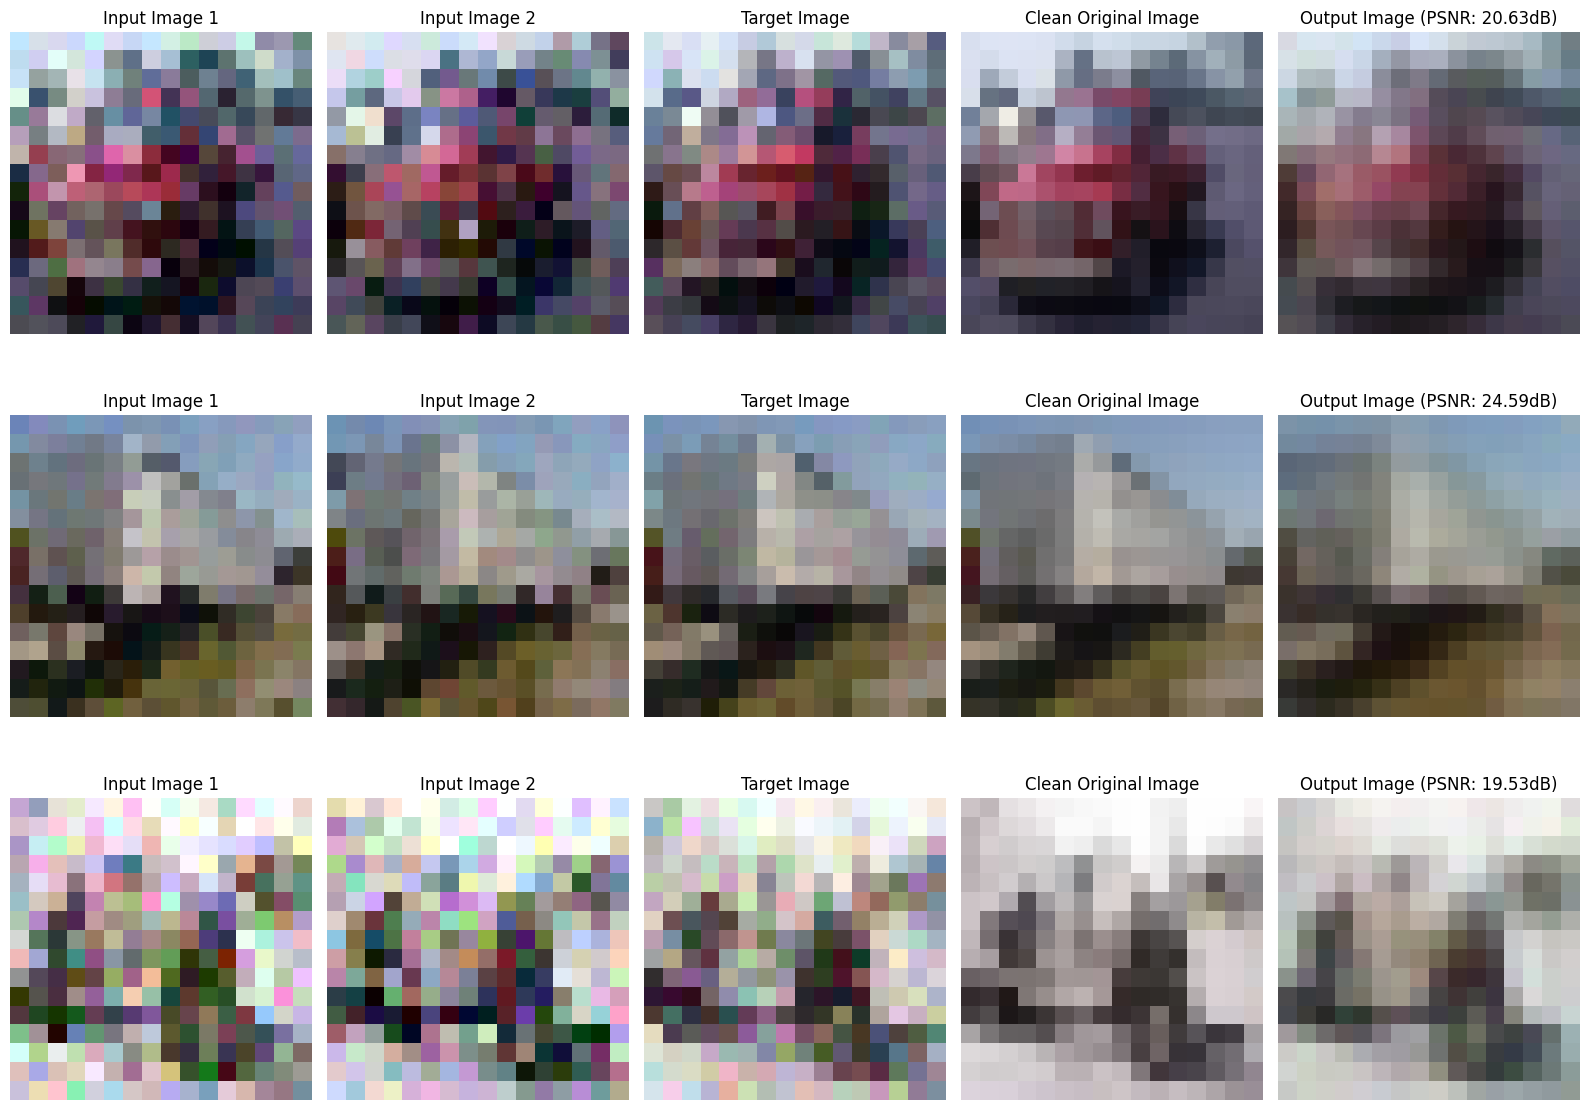

Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Epoch 21/50 - Train Loss: 0.0125, Val Loss: 0.0126, Val PSNR: 24.39dB


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.36s/it]


Epoch 22/50 - Train Loss: 0.0125, Val Loss: 0.0122, Val PSNR: 24.73dB
모델 저장됨 (Val Loss: 0.0122)


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 23/50 - Train Loss: 0.0125, Val Loss: 0.0125, Val PSNR: 24.50dB


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.40s/it]


Epoch 24/50 - Train Loss: 0.0124, Val Loss: 0.0124, Val PSNR: 24.64dB


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.38s/it]


Epoch 25/50 - Train Loss: 0.0126, Val Loss: 0.0124, Val PSNR: 24.26dB


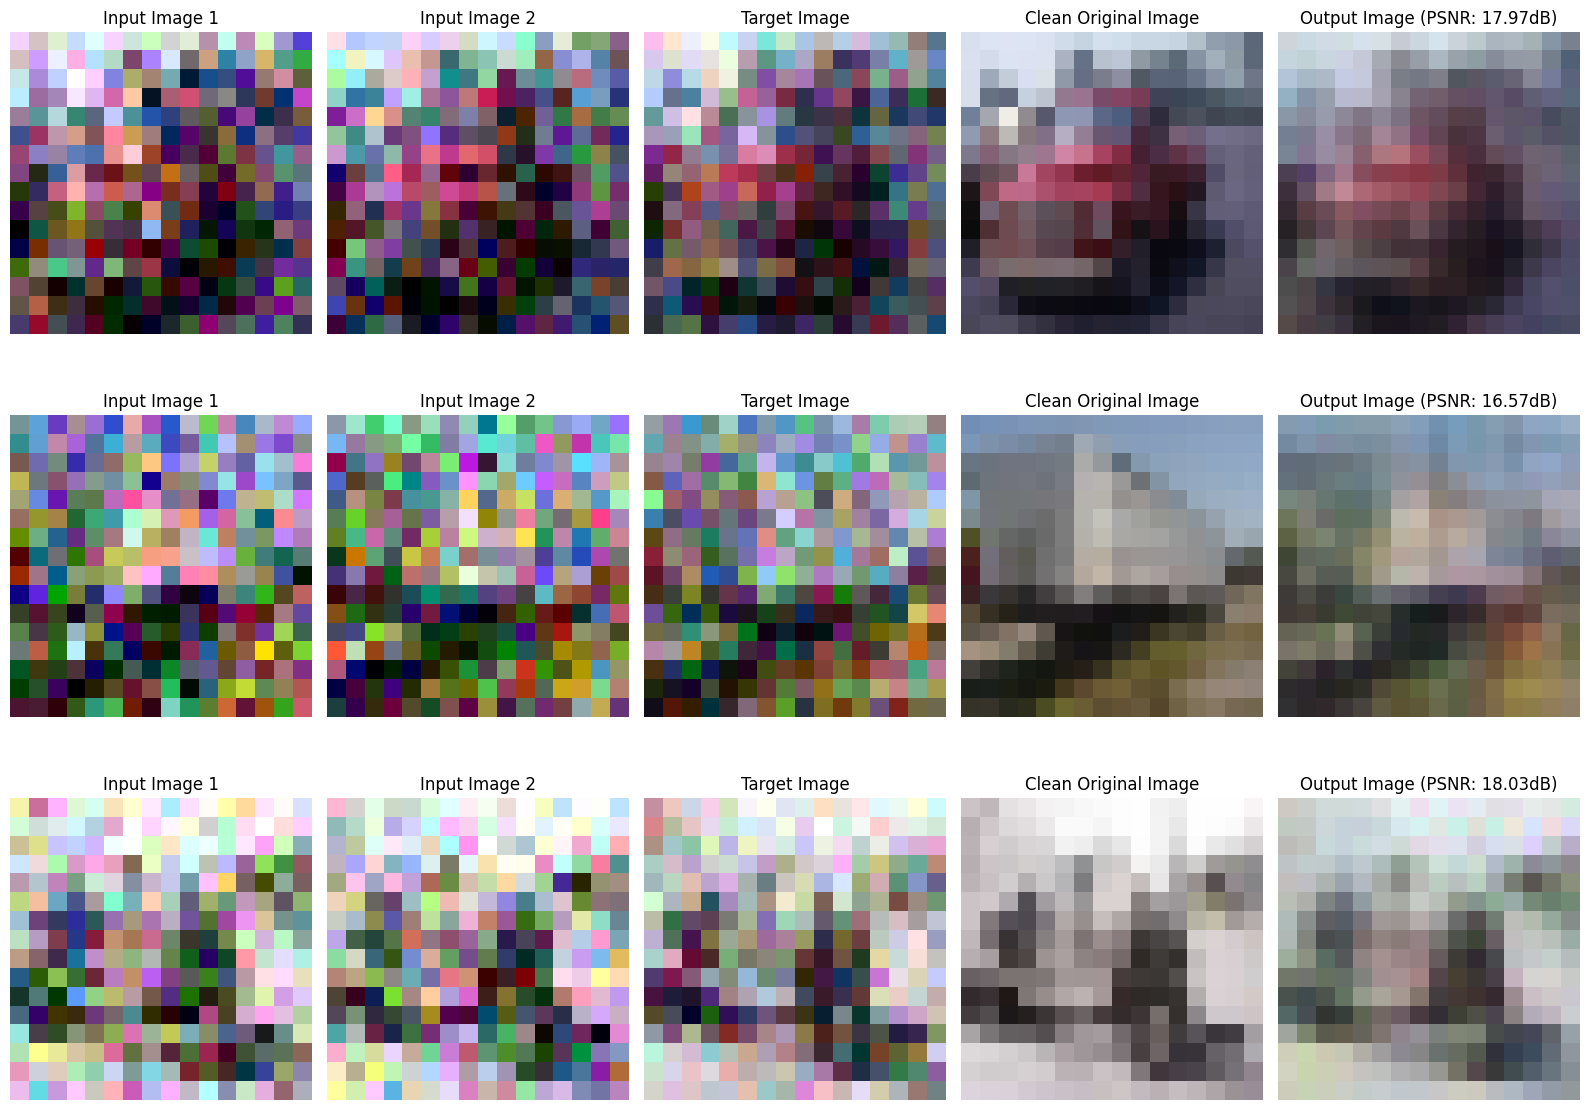

Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 26/50 - Train Loss: 0.0124, Val Loss: 0.0124, Val PSNR: 24.80dB


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.29s/it]


Epoch 27/50 - Train Loss: 0.0123, Val Loss: 0.0121, Val PSNR: 24.96dB
모델 저장됨 (Val Loss: 0.0121)


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Epoch 28/50 - Train Loss: 0.0123, Val Loss: 0.0121, Val PSNR: 24.73dB


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 29/50 - Train Loss: 0.0123, Val Loss: 0.0125, Val PSNR: 24.56dB


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.43s/it]


Epoch 30/50 - Train Loss: 0.0123, Val Loss: 0.0126, Val PSNR: 24.81dB


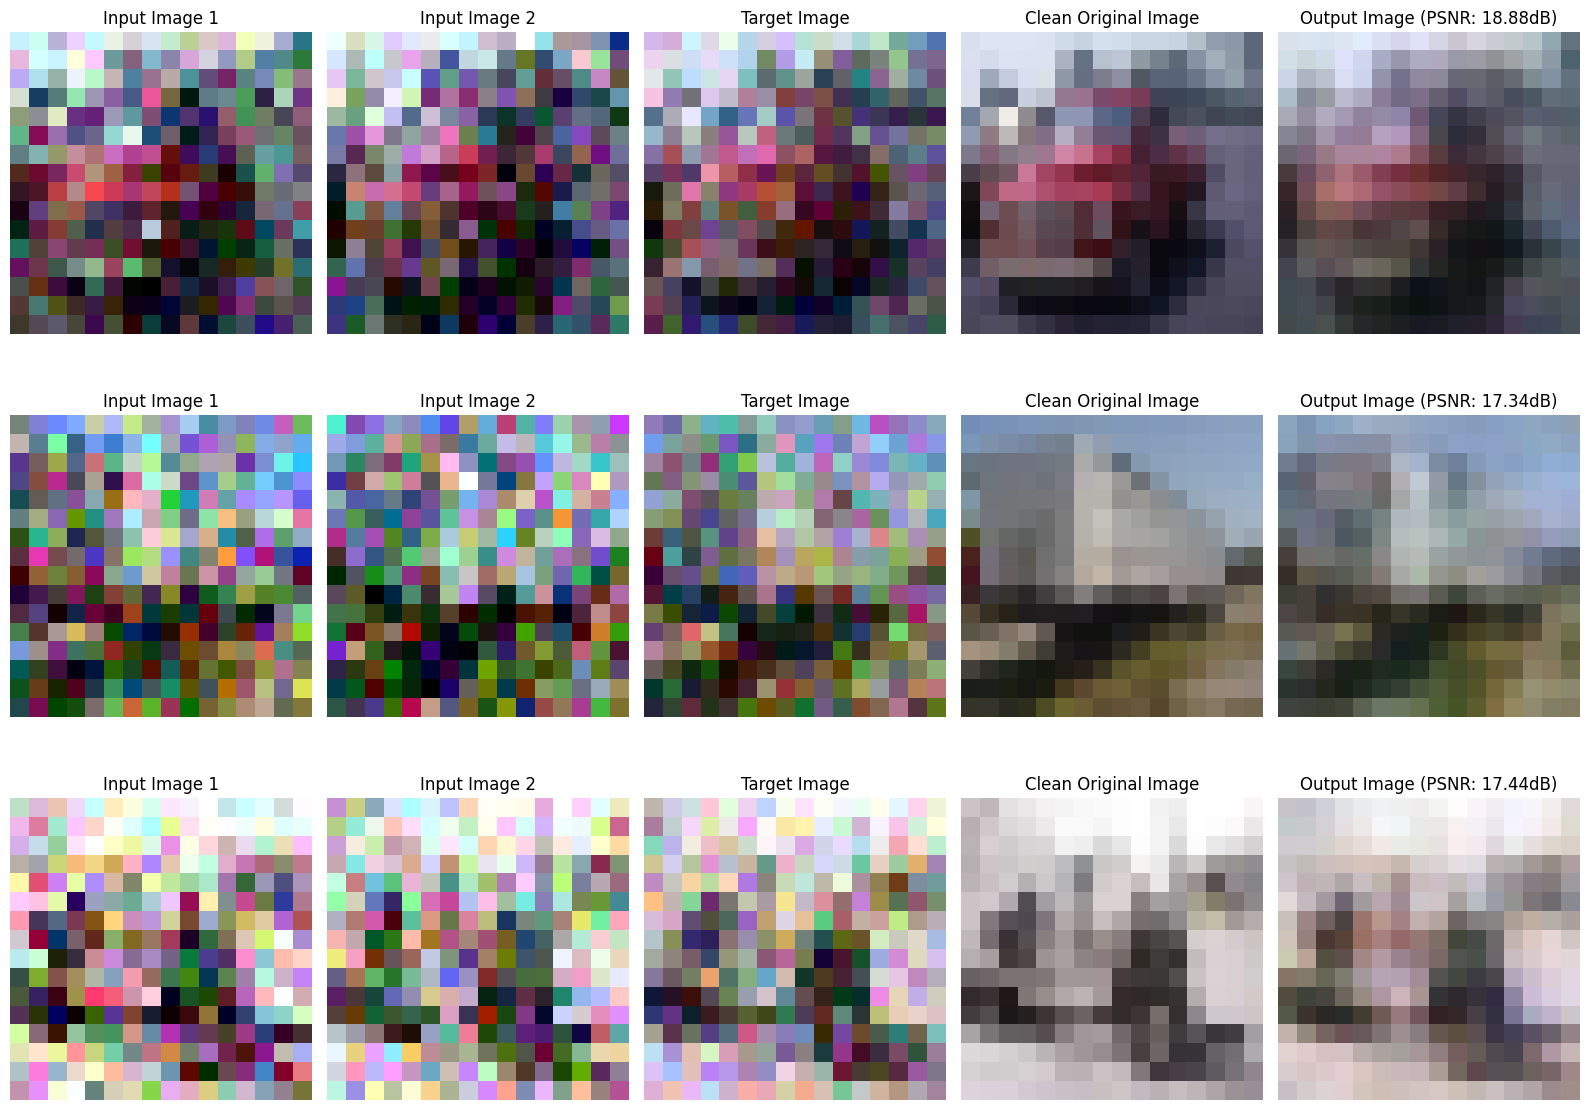

Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:21<00:00,  5.28s/it]


Epoch 31/50 - Train Loss: 0.0125, Val Loss: 0.0122, Val PSNR: 24.64dB


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 32/50 - Train Loss: 0.0123, Val Loss: 0.0136, Val PSNR: 24.29dB


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.36s/it]


Epoch 33/50 - Train Loss: 0.0122, Val Loss: 0.0132, Val PSNR: 24.22dB


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 34/50 - Train Loss: 0.0125, Val Loss: 0.0124, Val PSNR: 24.73dB


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 35/50 - Train Loss: 0.0121, Val Loss: 0.0119, Val PSNR: 24.98dB
모델 저장됨 (Val Loss: 0.0119)


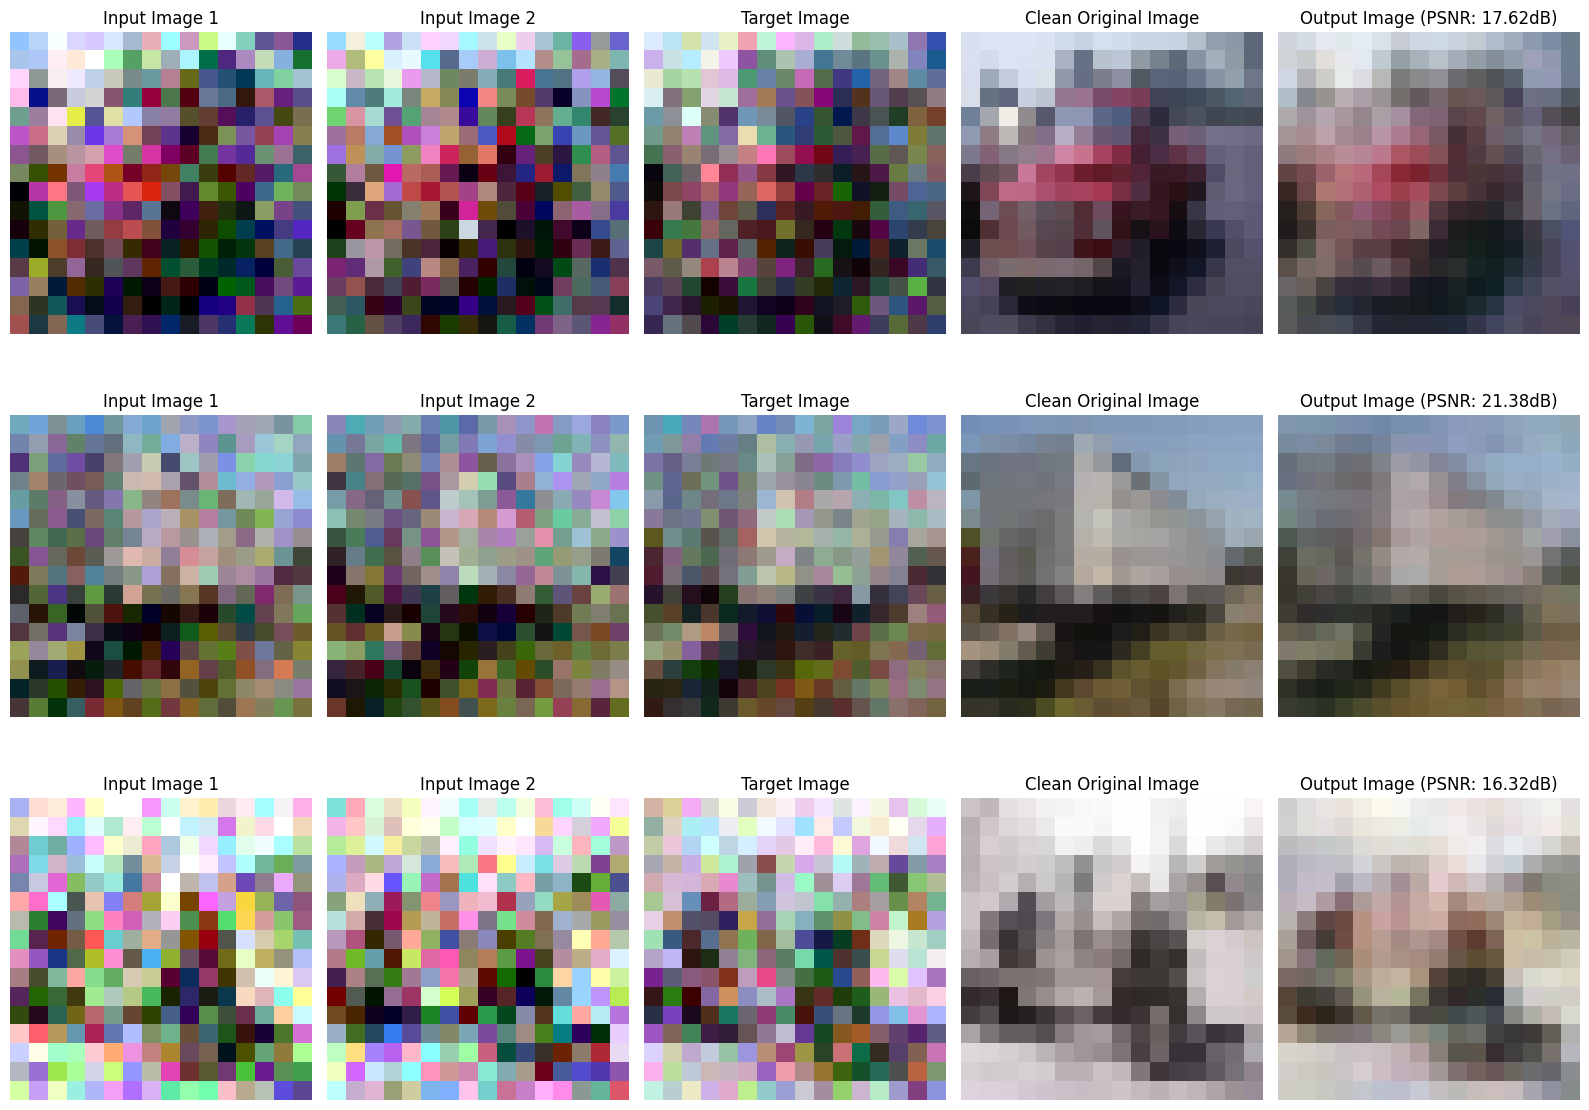

Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.40s/it]


Epoch 36/50 - Train Loss: 0.0122, Val Loss: 0.0121, Val PSNR: 25.03dB


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 37/50 - Train Loss: 0.0120, Val Loss: 0.0123, Val PSNR: 24.73dB


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 38/50 - Train Loss: 0.0122, Val Loss: 0.0128, Val PSNR: 24.47dB


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 39/50 - Train Loss: 0.0122, Val Loss: 0.0125, Val PSNR: 24.33dB


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 40/50 - Train Loss: 0.0122, Val Loss: 0.0129, Val PSNR: 24.52dB


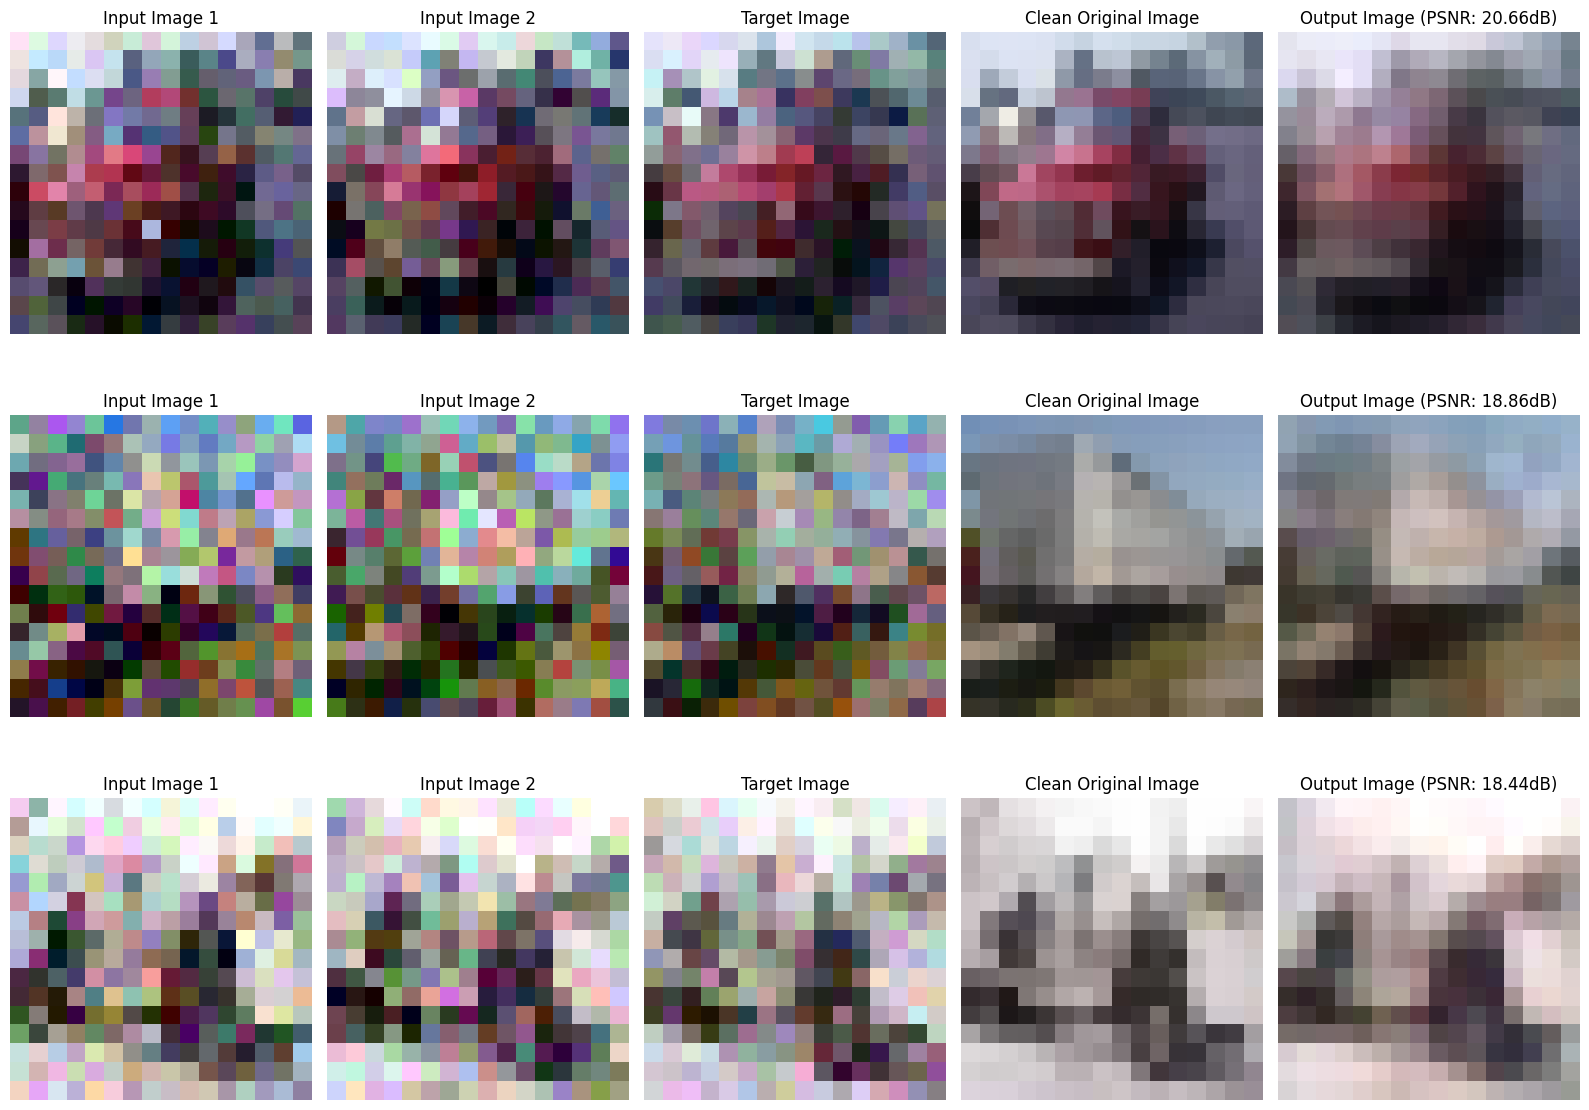

Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 41/50 - Train Loss: 0.0122, Val Loss: 0.0127, Val PSNR: 23.91dB


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 42/50 - Train Loss: 0.0124, Val Loss: 0.0121, Val PSNR: 24.68dB


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 43/50 - Train Loss: 0.0123, Val Loss: 0.0119, Val PSNR: 25.11dB
모델 저장됨 (Val Loss: 0.0119)


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 44/50 - Train Loss: 0.0124, Val Loss: 0.0118, Val PSNR: 24.73dB
모델 저장됨 (Val Loss: 0.0118)


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch 45/50 - Train Loss: 0.0123, Val Loss: 0.0118, Val PSNR: 25.13dB


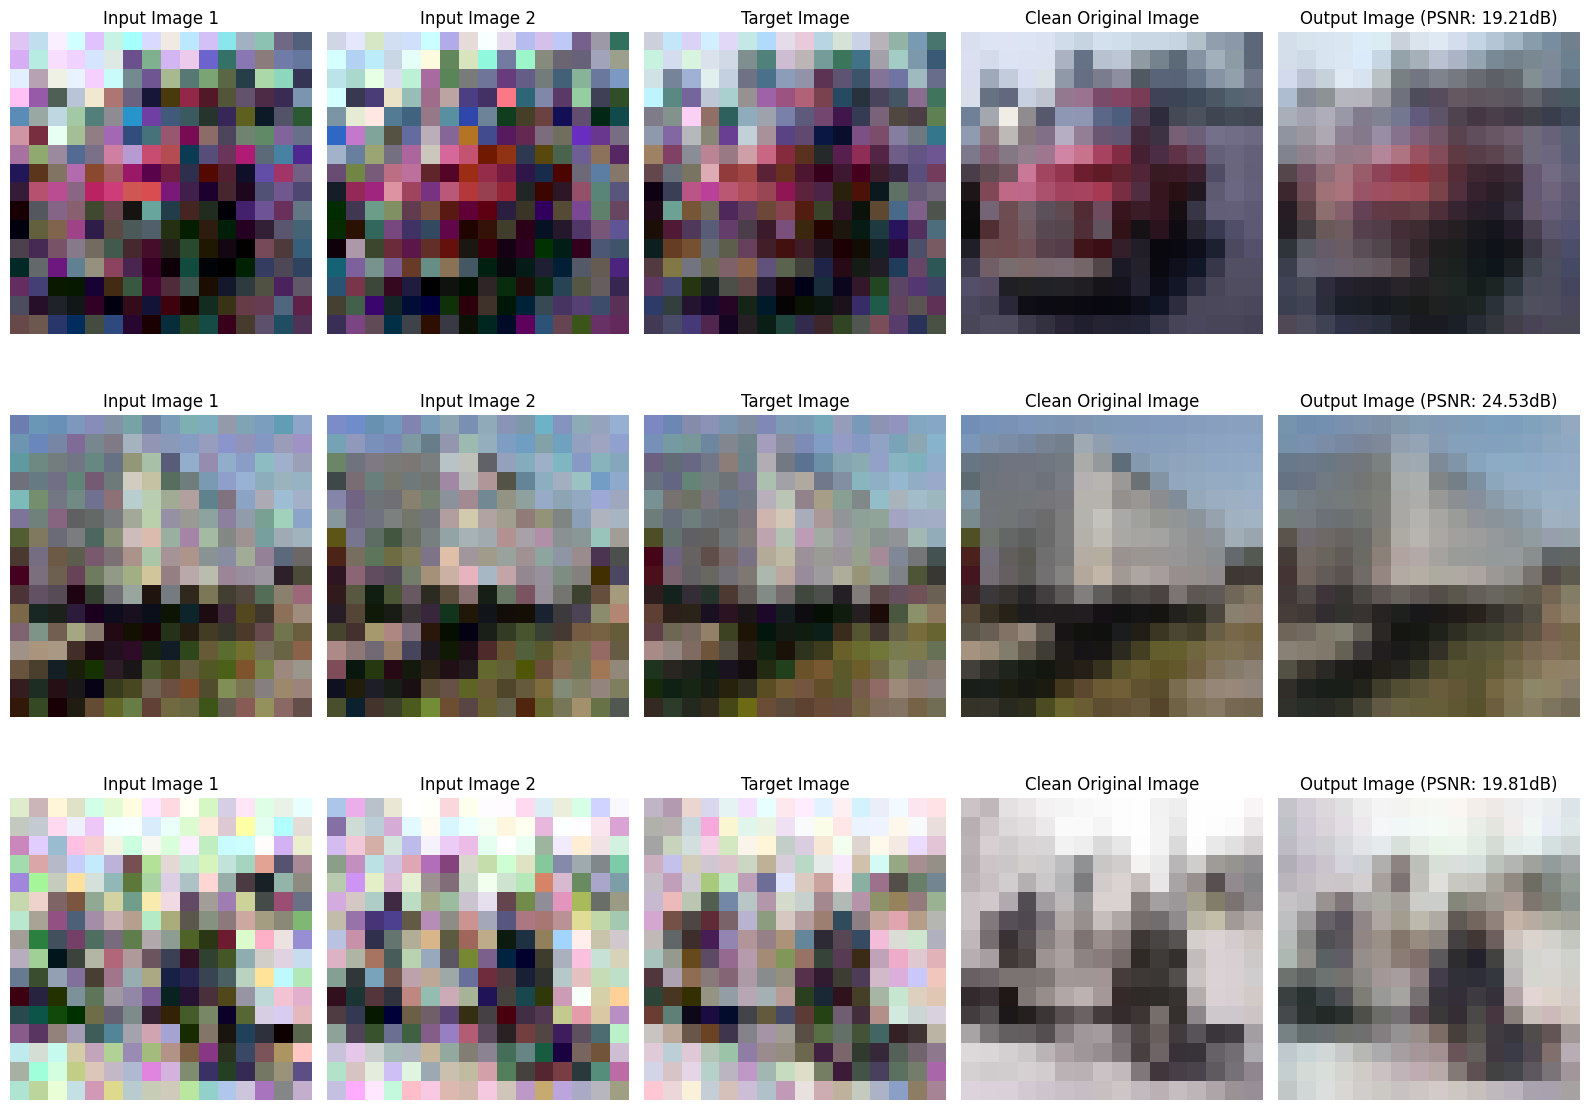

Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.38s/it]


Epoch 46/50 - Train Loss: 0.0122, Val Loss: 0.0121, Val PSNR: 25.03dB


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]


Epoch 47/50 - Train Loss: 0.0122, Val Loss: 0.0120, Val PSNR: 25.06dB


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 48/50 - Train Loss: 0.0122, Val Loss: 0.0119, Val PSNR: 25.11dB


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 49/50 - Train Loss: 0.0123, Val Loss: 0.0121, Val PSNR: 25.20dB


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 50/50 - Train Loss: 0.0123, Val Loss: 0.0125, Val PSNR: 24.99dB


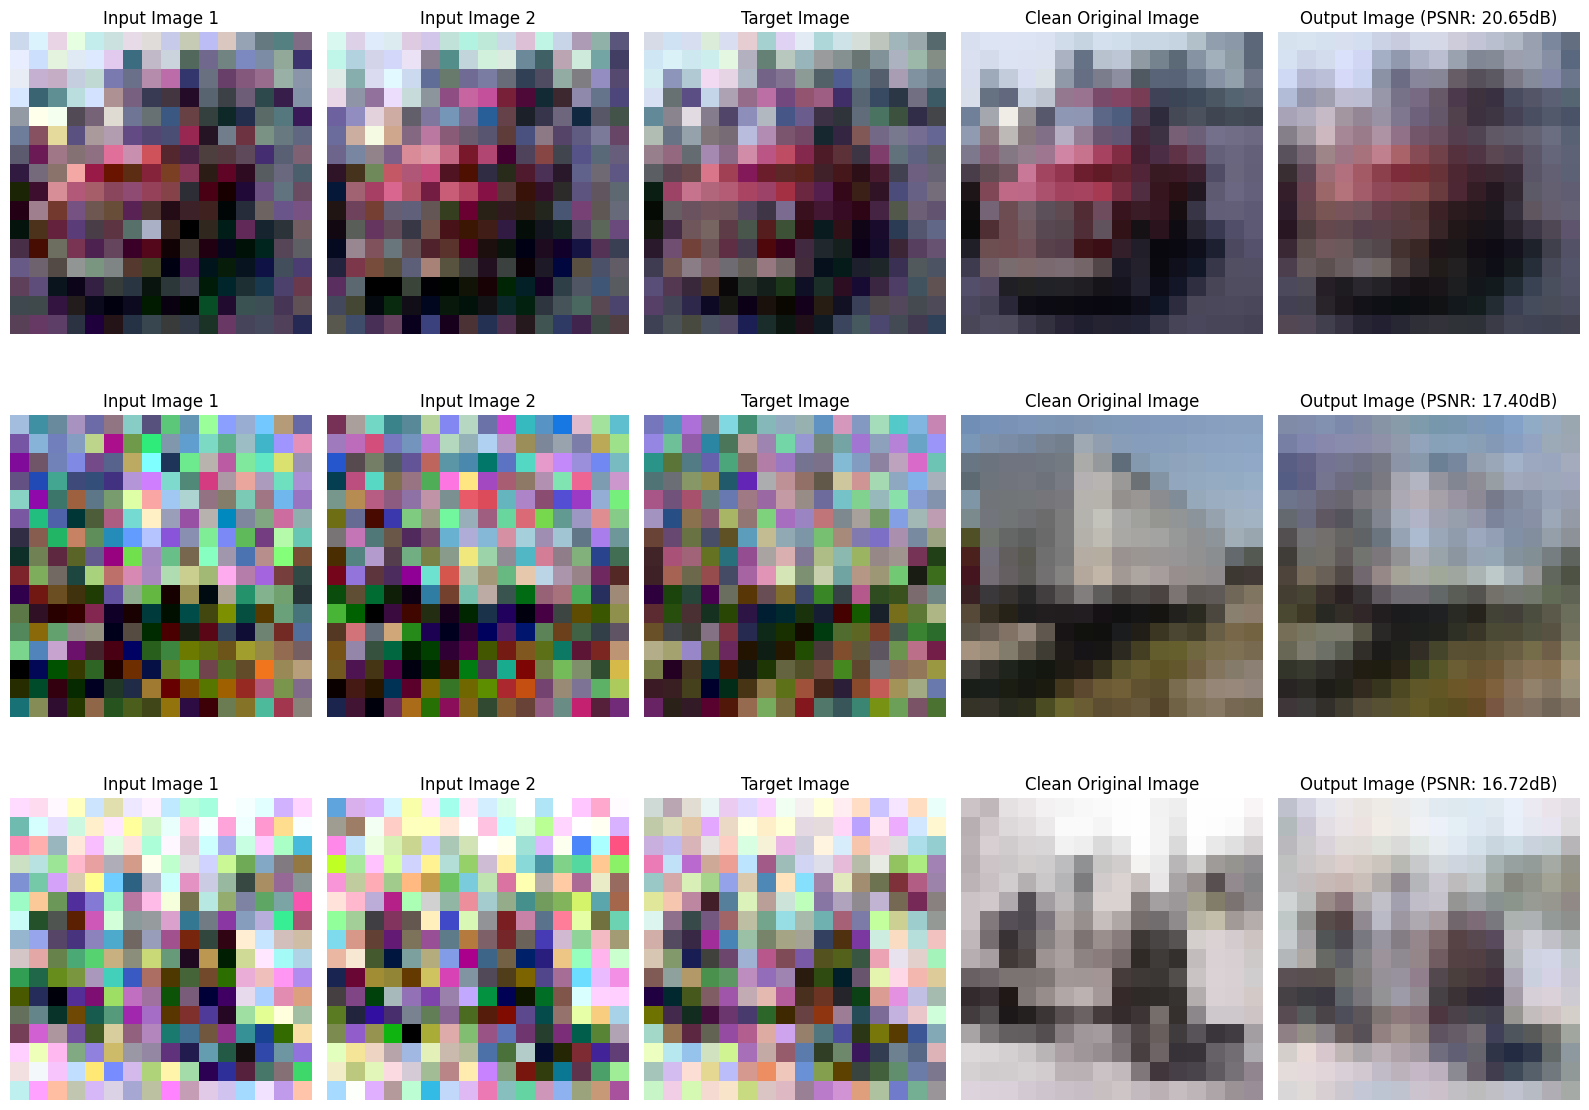

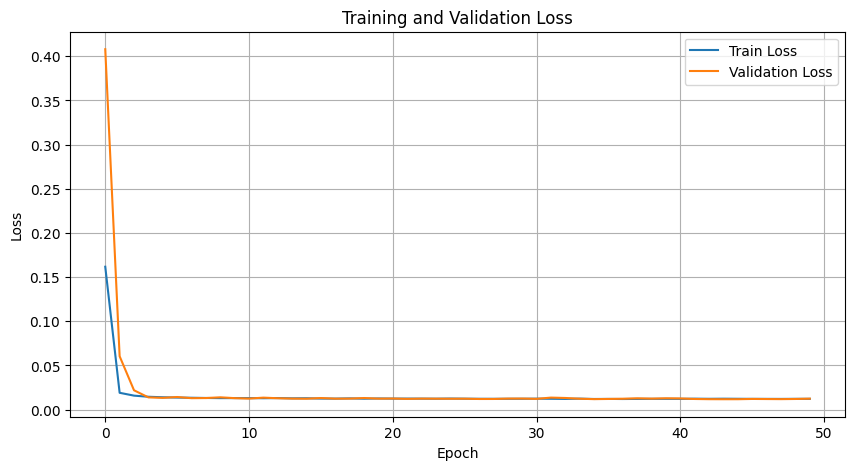

C:\Users\pook0\AppData\Local\Temp\ipykernel_9132\3251760670.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./checkpoints/best_unet_


테스트 결과:
테스트 손실: 0.0121
테스트 PSNR: 24.75dB

최종 예측 결과 시각화:


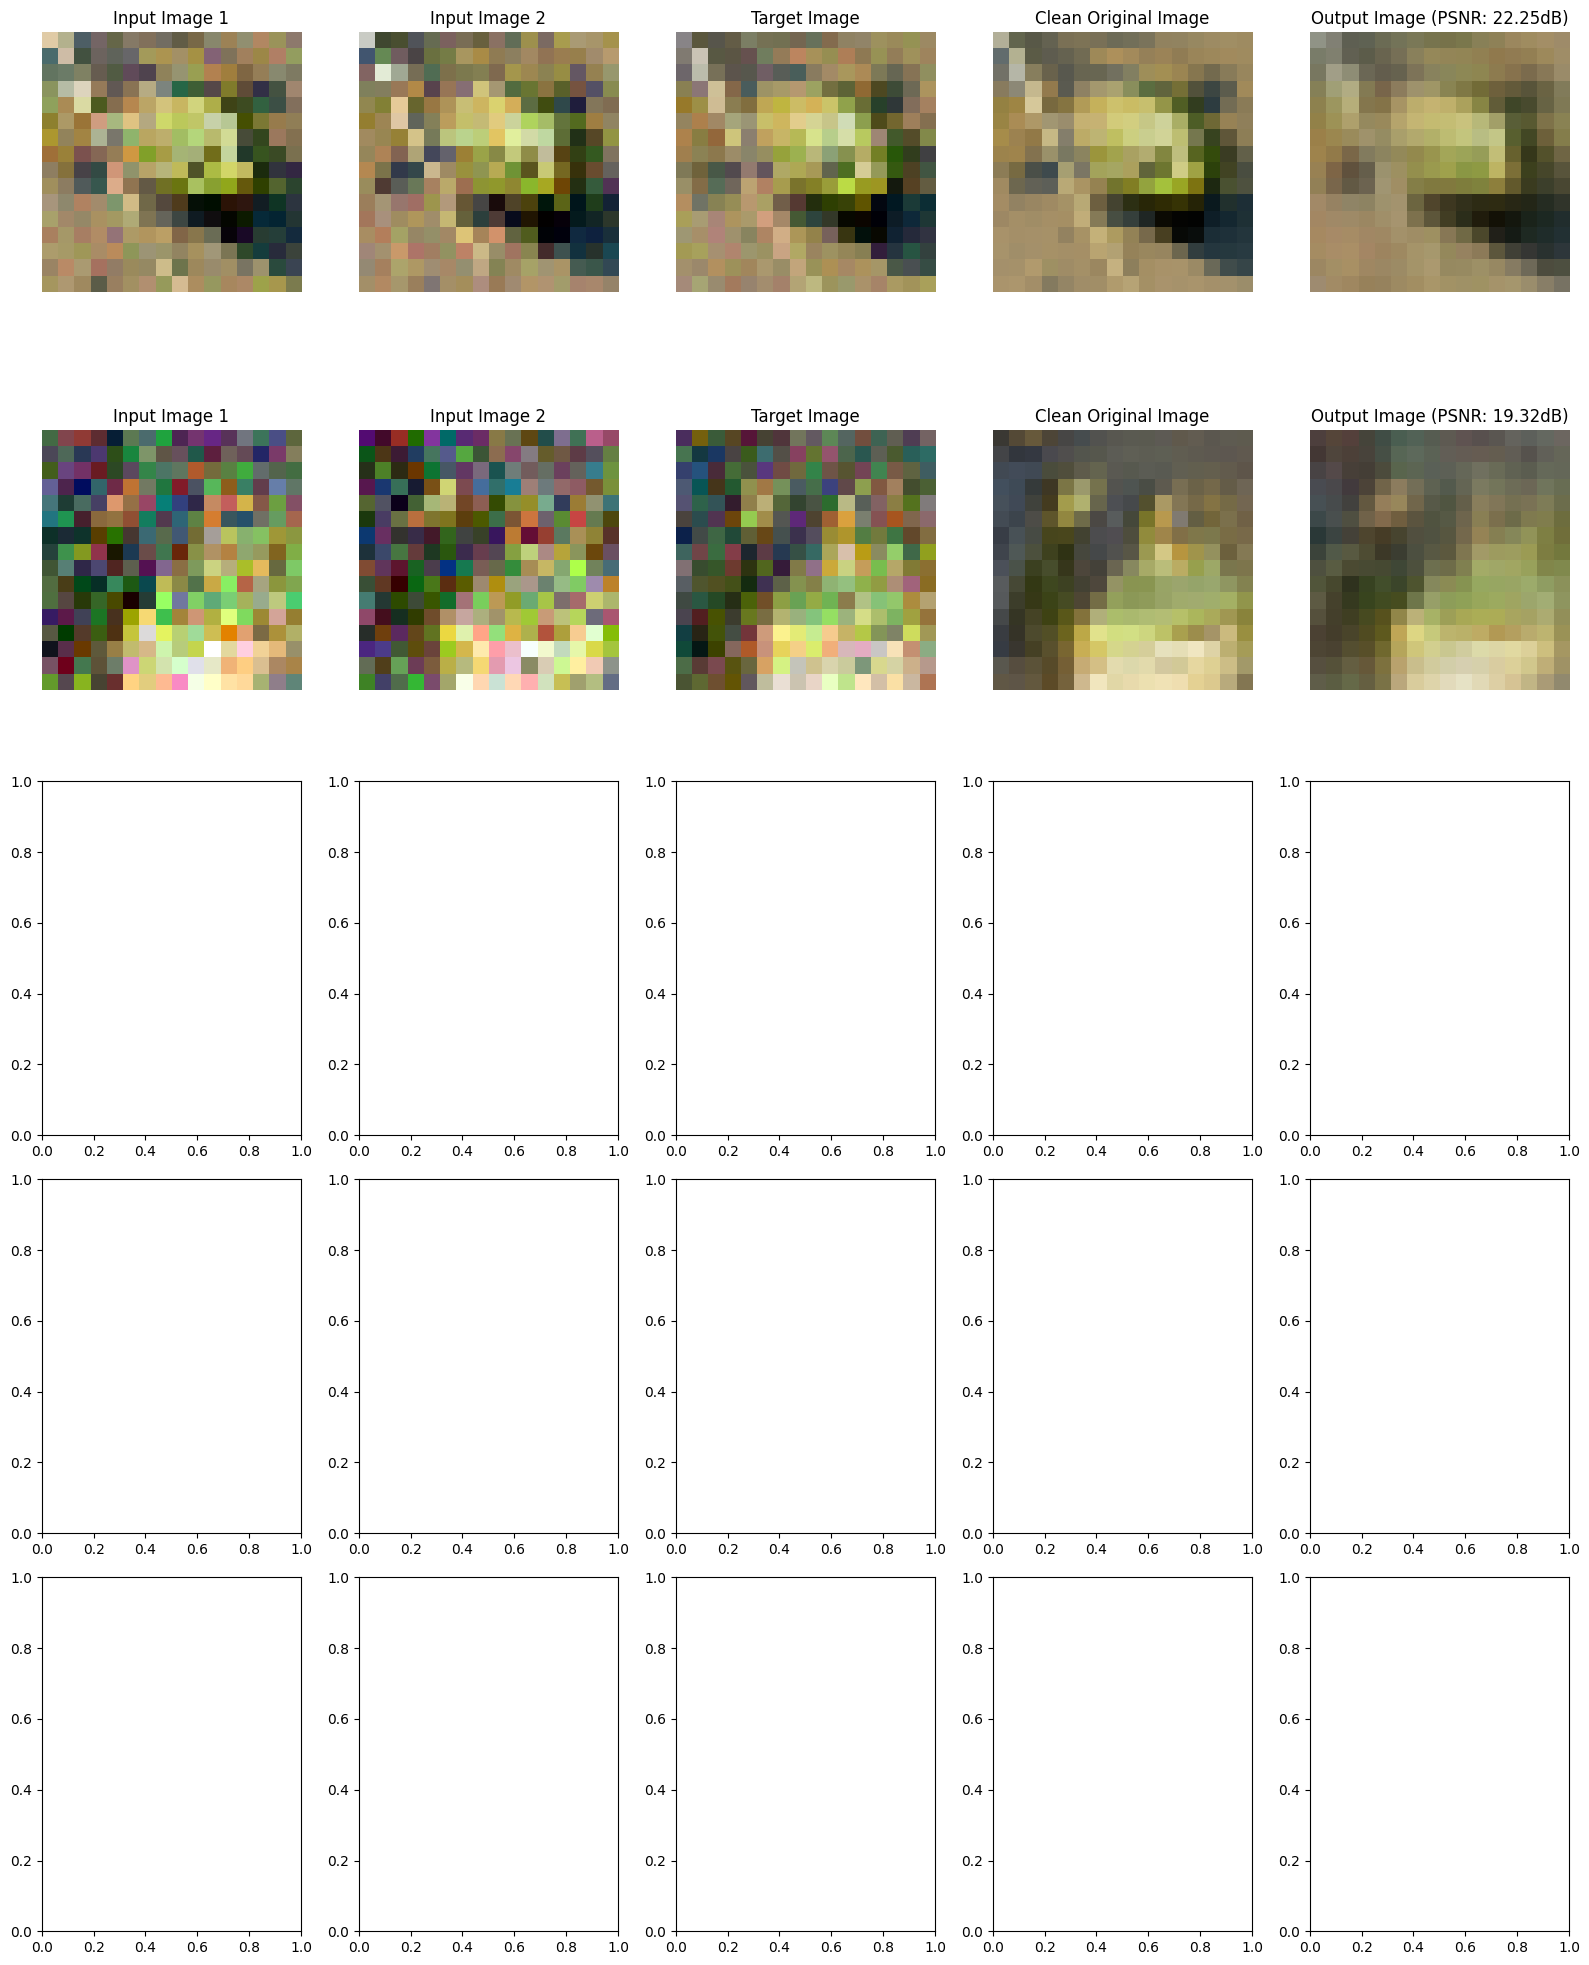

In [3]:

# UNet 모델 정의
class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, features=64):
        """
        경량화된 UNet 모델 (3단계 인코더-디코더 구조)
        
        Args:
            in_channels (int): 입력 채널 수 (2개의 RGB 이미지 concat -> 6)
            out_channels (int): 출력 채널 수 (RGB 이미지 -> 3)
            features (int): 기본 특징 맵 수
        """
        super(UNet, self).__init__()
        
        # 인코더 (다운샘플링 경로)
        self.encoder1 = self._double_conv(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = self._double_conv(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = self._double_conv(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = self._double_conv(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 병목 부분
        self.bottleneck = self._double_conv(features * 8, features * 16)
        
        # 디코더 (업샘플링 경로)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._double_conv(features * 16, features * 8)  # 스킵 연결로 채널 수 2배

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._double_conv(features * 8, features * 4)  # 스킵 연결로 채널 수 2배
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._double_conv(features * 4, features * 2)  # 스킵 연결로 채널 수 2배
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._double_conv(features * 2, features)  # 스킵 연결로 채널 수 2배
        
        # 최종 출력 레이어
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)
    
    def _double_conv(self, in_channels, out_channels):
        """두 번의 컨볼루션 레이어 (Conv -> BN -> ReLU) x 2"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        """
        순전파
        
        Args:
            x: 입력 이미지 텐서 (B, 6, H, W) - 2개의 RGB 이미지 concat
            
        Returns:
            출력 이미지 텐서 (B, 3, H, W)
        """
        # 인코더 경로
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # 병목 부분
        bottleneck = self.bottleneck(self.pool3(enc4))
        
        # 디코더 경로 (스킵 연결 포함)
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # 최종 출력
        return self.conv(dec1)

# 메인 함수
def main(num_layers, features, num_epochs, batch_size, learning_rate, noise_level, ca, device):
    # CIFAR-10 이미지 준비 (없으면 다운로드)
    image_dir = './data/cifar10'
    prepare_cifar10_dataset(output_dir=image_dir, num_images=5000)
    
    # 시드 설정
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # 커널 샘플링 데이터셋 생성
    kernel_dataset = NoisyKernelSamplingDataset_2(
        image_dir=image_dir,
        kernel_size=2,
        # num_samples=3,
        noise_level=noise_level,
    )
    
    # 데이터셋 분할 (학습:검증:테스트 = 7:2:1)
    dataset_size = len(kernel_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        kernel_dataset, [train_size, val_size, test_size]
    )
    
    # DnCNN 데이터셋 래퍼 생성
    train_dncnn_dataset = DnCNNDatasetWrapper(train_dataset, input_indices=(0, 1), target_index=2)
    val_dncnn_dataset = DnCNNDatasetWrapper(val_dataset, input_indices=(0, 1), target_index=2)
    test_dncnn_dataset = DnCNNDatasetWrapper(test_dataset, input_indices=(0, 1), target_index=2)
    
    # 데이터로더 생성
    batch_size = batch_size
    train_loader = DataLoader(train_dncnn_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dncnn_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dncnn_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # 샘플 확인
    print("데이터 형태 확인:")
    inputs, targets, cleans = next(iter(train_loader))
    print(f"입력 형태: {inputs.shape} (배치, 채널, 높이, 너비)")  # [B, 6, H, W]
    print(f"타겟 형태: {targets.shape} (배치, 채널, 높이, 너비)")  # [B, 3, H, W]
    print(f"깨끗한 원본 형태: {cleans.shape} (배치, 채널, 높이, 너비)")  # [B, 3, H, W]
    
    if torch.equal(targets, cleans):
        print("Target and clean images are the same.")
    else:
        print("Target and clean images are different.")
    
    # 장치 설정
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"사용 장치: {device}")
    
    # DnCNN 모델 생성
    model = UNet(in_channels=6, out_channels=3, features=features)
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters())}")
    
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # 학습 실행
    num_epochs = num_epochs
    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, ca=ca, noise_level=noise_level)
    
    # 최적 모델 로드
    model.load_state_dict(torch.load(f'./checkpoints/best_unet_model_{noise_level}.pth'))
    
    # 테스트 셋 평가
    model.eval()
    test_loss = 0.0
    test_psnr = 0.0
    
    with torch.no_grad():
        for inputs, targets, cleans in tqdm(test_loader, desc="테스트 중"):
            inputs, targets, cleans = inputs.to(device), targets.to(device), cleans.to(device)
            
            # 순전파
            outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            # PSNR 계산
            for i in range(outputs.size(0)):
                mse = F.mse_loss(outputs[i], cleans[i]).item()
                psnr = -10 * np.log10(mse) if mse > 0 else 100
                test_psnr += psnr
    
    # 평균 테스트 손실 및 PSNR
    test_loss = test_loss / len(test_loader.dataset)
    test_psnr = test_psnr / len(test_loader.dataset)
    
    print(f"\n테스트 결과:")
    print(f"테스트 손실: {test_loss:.4f}")
    print(f"테스트 PSNR: {test_psnr:.2f}dB")
    
    # 최종 결과 시각화
    print("\n최종 예측 결과 시각화:")
    visualize_input_target_output(model, test_loader, device, num_samples=5)

if __name__ == "__main__":
    num_layers = 17
    features = 64
    num_epochs = 50
    batch_size = 256
    learning_rate = 0.001
    noise_level = 0.2
    ca = None
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    main(num_layers, features, num_epochs, batch_size, learning_rate, noise_level, ca, device)
    

## DnCNN with Self_Attention 모델 학습 및 시각화

./data/cifar10에 이미 5000개의 이미지가 있습니다.
총 5000개 이미지 로드됨
데이터 형태 확인:
입력 형태: torch.Size([256, 6, 16, 16]) (배치, 채널, 높이, 너비)
타겟 형태: torch.Size([256, 3, 16, 16]) (배치, 채널, 높이, 너비)
깨끗한 원본 형태: torch.Size([256, 3, 16, 16]) (배치, 채널, 높이, 너비)
Target and clean images are different.
사용 장치: cuda
모델 파라미터 수: 21011715


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 1/50 - Train Loss: 0.1518, Val Loss: 0.1284, Val PSNR: 9.92dB
모델 저장됨 (Val Loss: 0.1284)


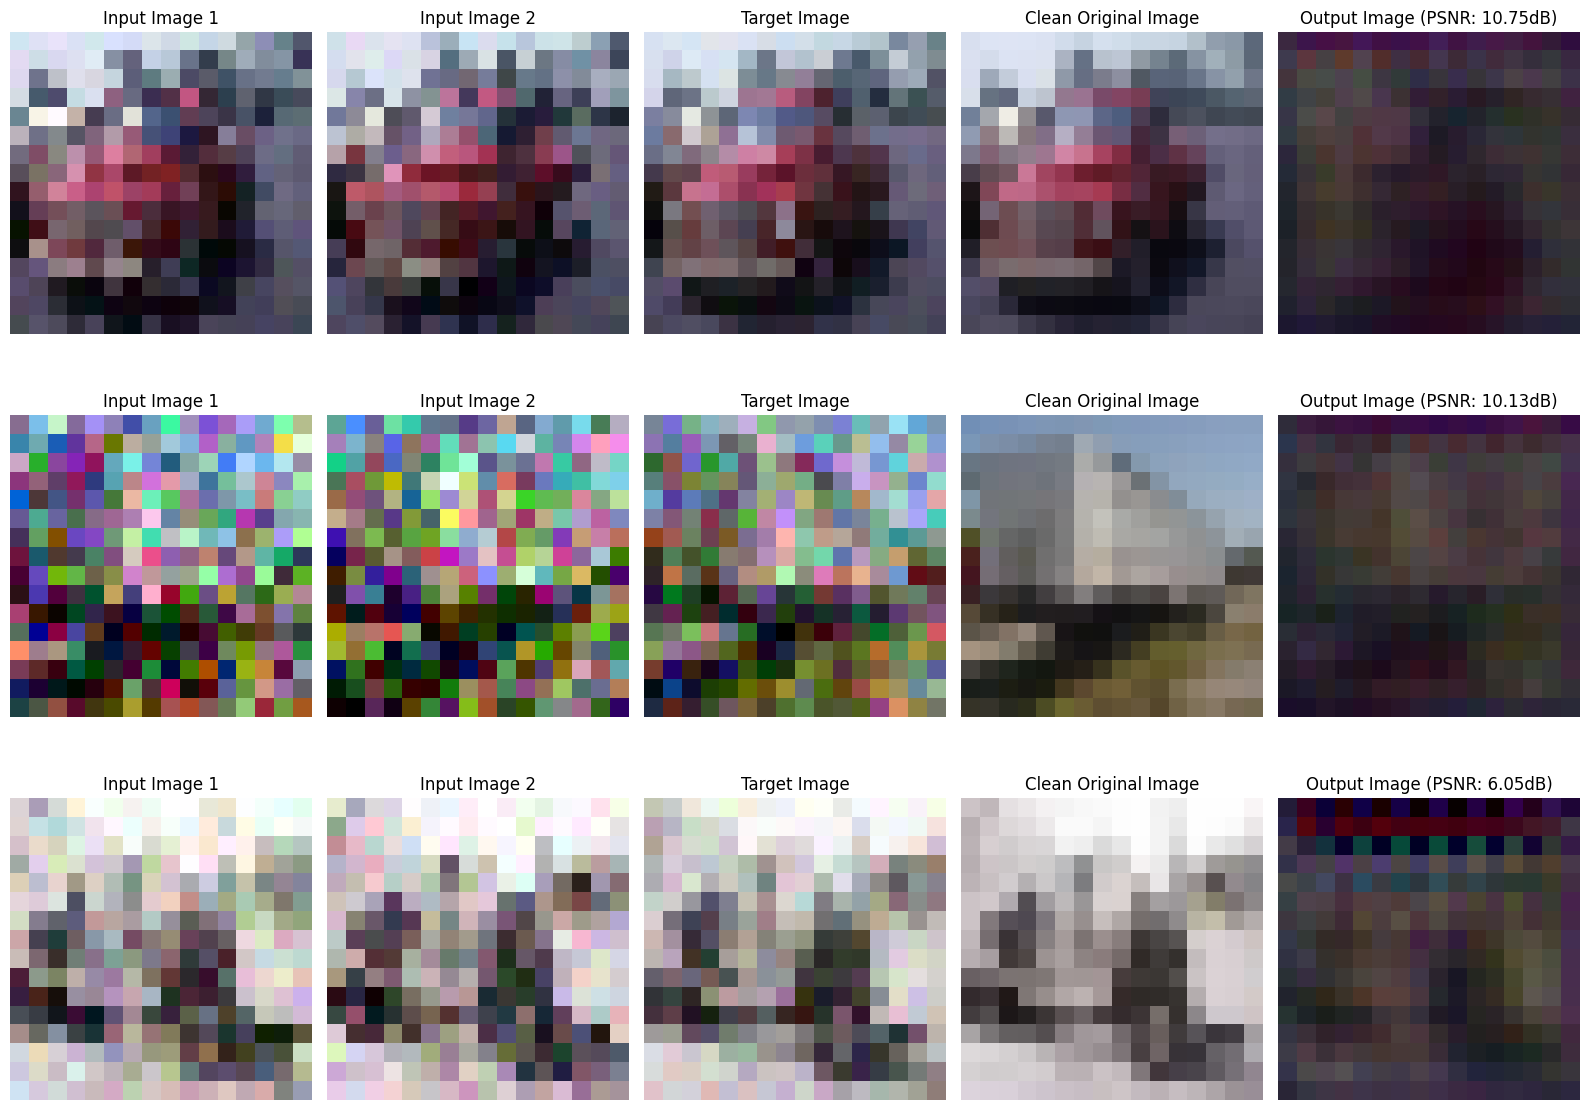

Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]


Epoch 2/50 - Train Loss: 0.0198, Val Loss: 0.0437, Val PSNR: 16.82dB
모델 저장됨 (Val Loss: 0.0437)


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:16<00:00,  4.23s/it]


Epoch 3/50 - Train Loss: 0.0159, Val Loss: 0.0168, Val PSNR: 20.97dB
모델 저장됨 (Val Loss: 0.0168)


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.26s/it]


Epoch 4/50 - Train Loss: 0.0145, Val Loss: 0.0143, Val PSNR: 22.46dB
모델 저장됨 (Val Loss: 0.0143)


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 5/50 - Train Loss: 0.0140, Val Loss: 0.0134, Val PSNR: 23.13dB
모델 저장됨 (Val Loss: 0.0134)


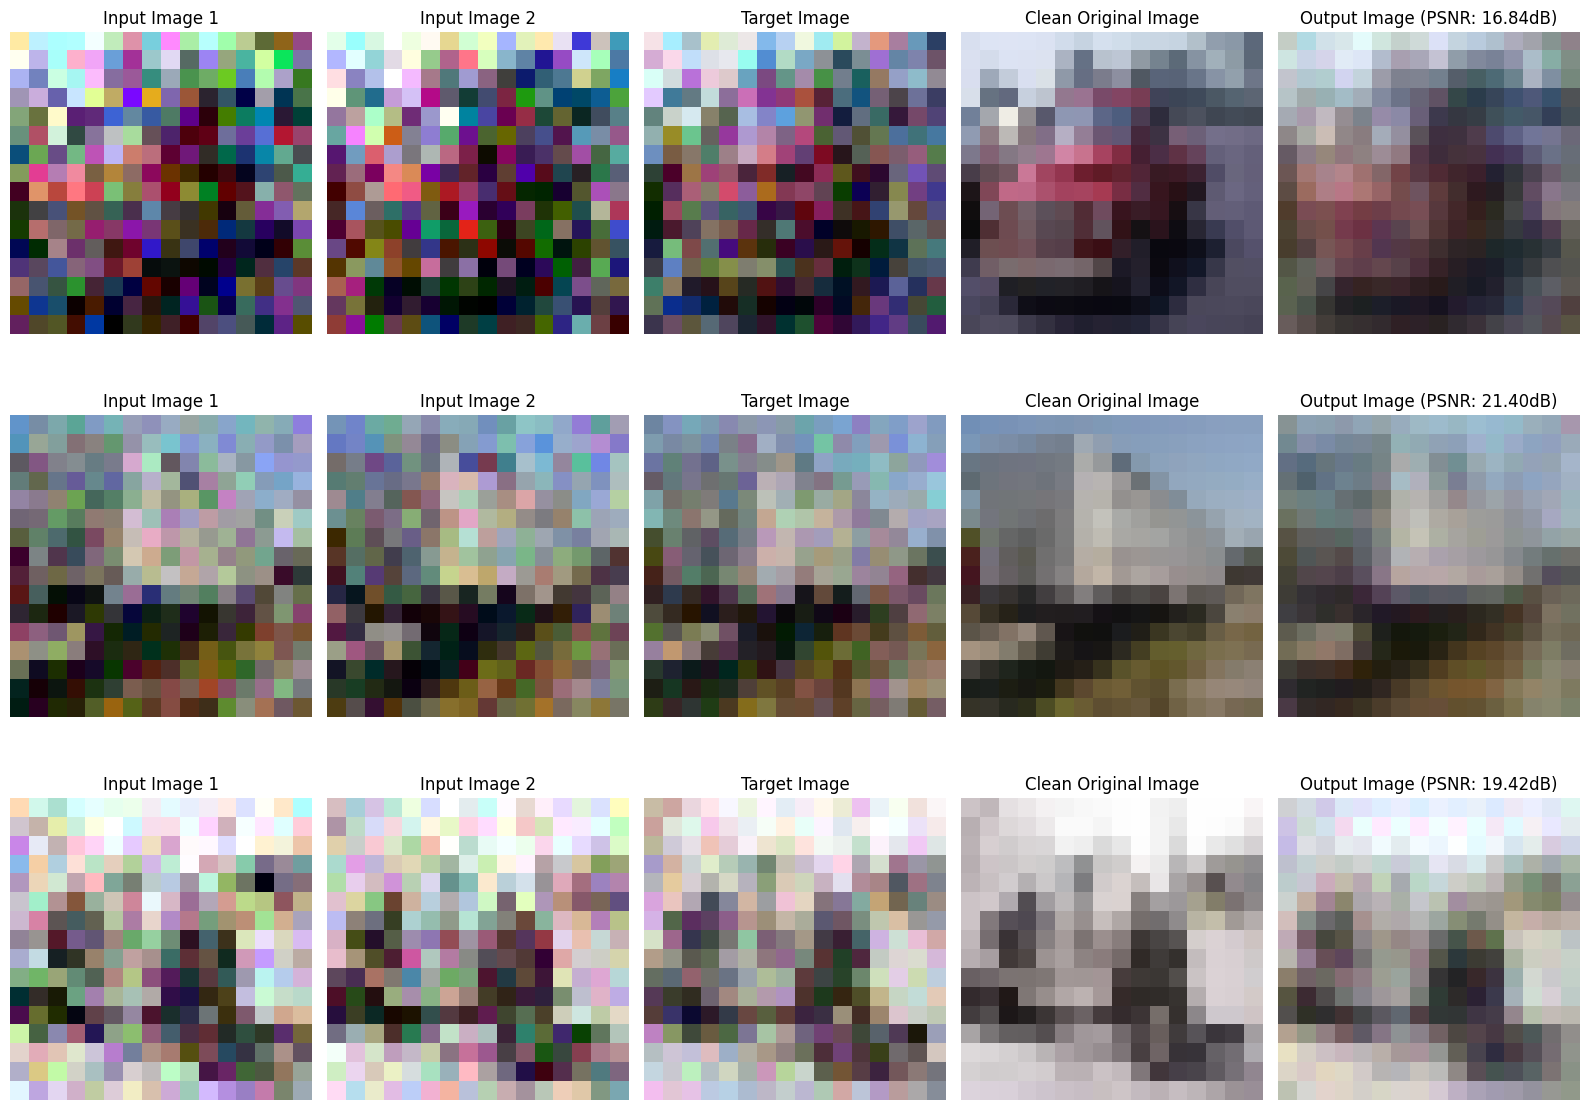

Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


Epoch 6/50 - Train Loss: 0.0136, Val Loss: 0.0138, Val PSNR: 23.27dB


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:16<00:00,  4.24s/it]


Epoch 7/50 - Train Loss: 0.0134, Val Loss: 0.0130, Val PSNR: 23.37dB
모델 저장됨 (Val Loss: 0.0130)


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:16<00:00,  4.23s/it]


Epoch 8/50 - Train Loss: 0.0134, Val Loss: 0.0132, Val PSNR: 23.66dB


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]


Epoch 9/50 - Train Loss: 0.0133, Val Loss: 0.0131, Val PSNR: 23.70dB


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:16<00:00,  4.18s/it]


Epoch 10/50 - Train Loss: 0.0130, Val Loss: 0.0129, Val PSNR: 23.84dB
모델 저장됨 (Val Loss: 0.0129)


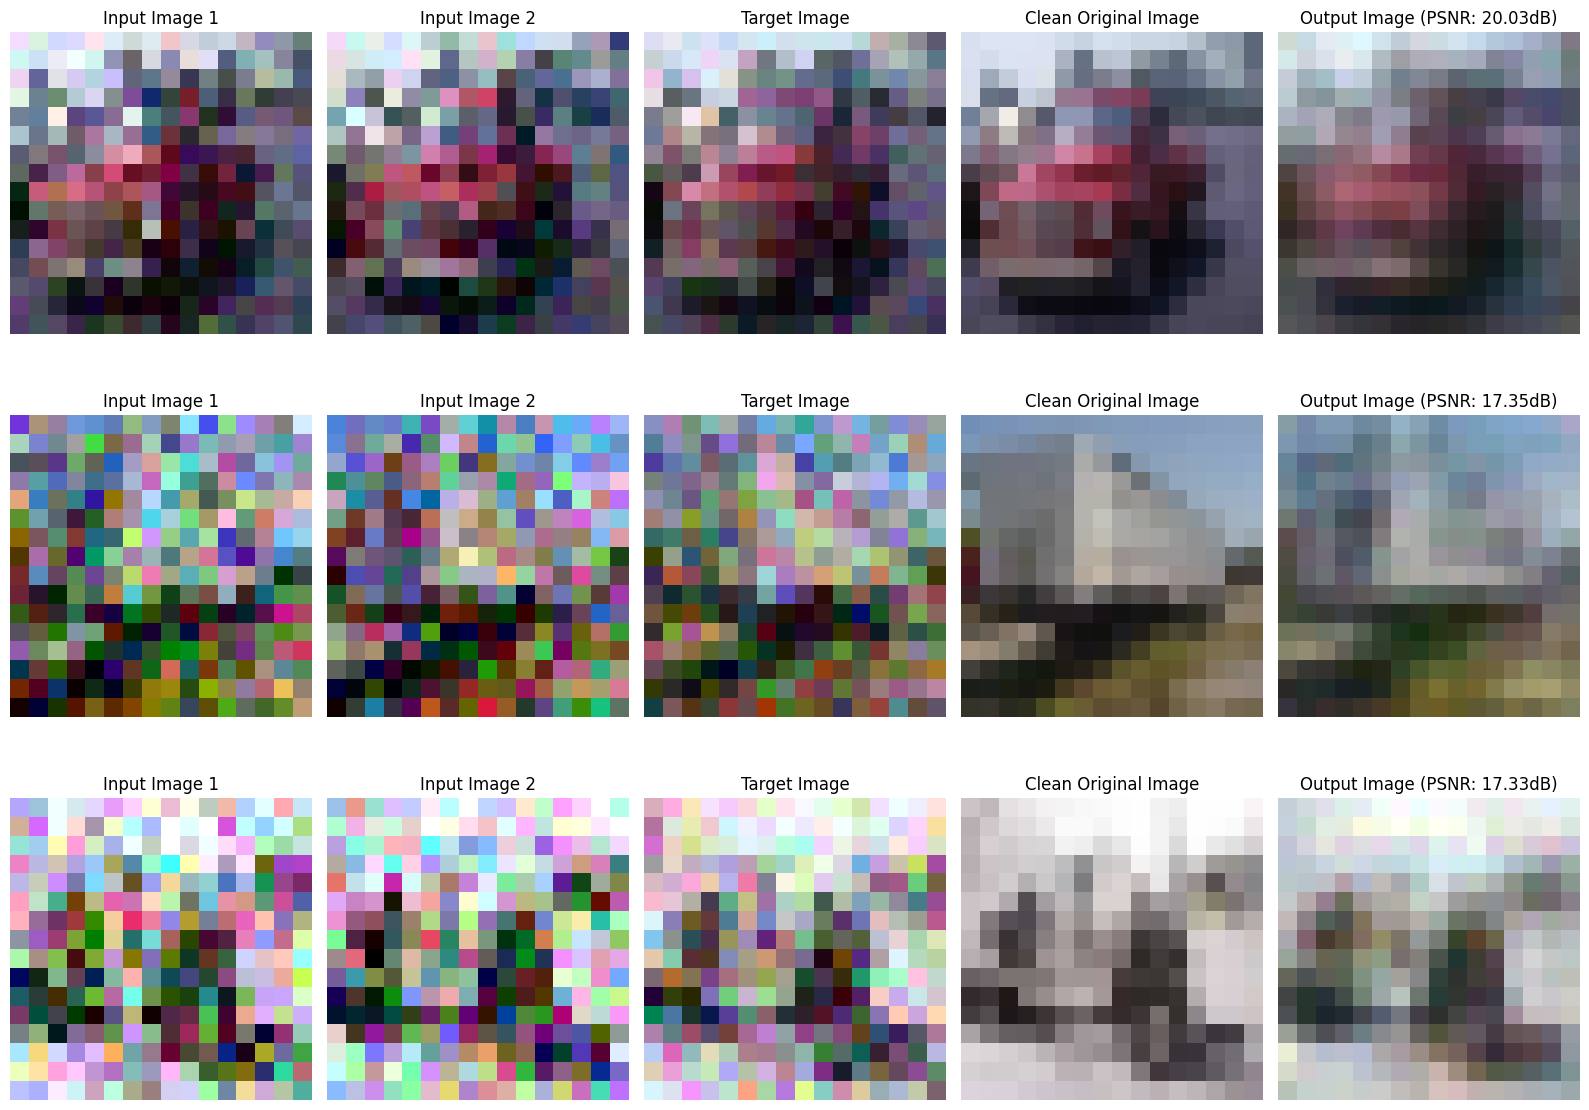

Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.38s/it]


Epoch 11/50 - Train Loss: 0.0131, Val Loss: 0.0126, Val PSNR: 24.06dB
모델 저장됨 (Val Loss: 0.0126)


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 12/50 - Train Loss: 0.0127, Val Loss: 0.0127, Val PSNR: 24.11dB


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 13/50 - Train Loss: 0.0128, Val Loss: 0.0127, Val PSNR: 24.01dB


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 14/50 - Train Loss: 0.0127, Val Loss: 0.0126, Val PSNR: 24.34dB
모델 저장됨 (Val Loss: 0.0126)


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 15/50 - Train Loss: 0.0128, Val Loss: 0.0125, Val PSNR: 24.39dB
모델 저장됨 (Val Loss: 0.0125)


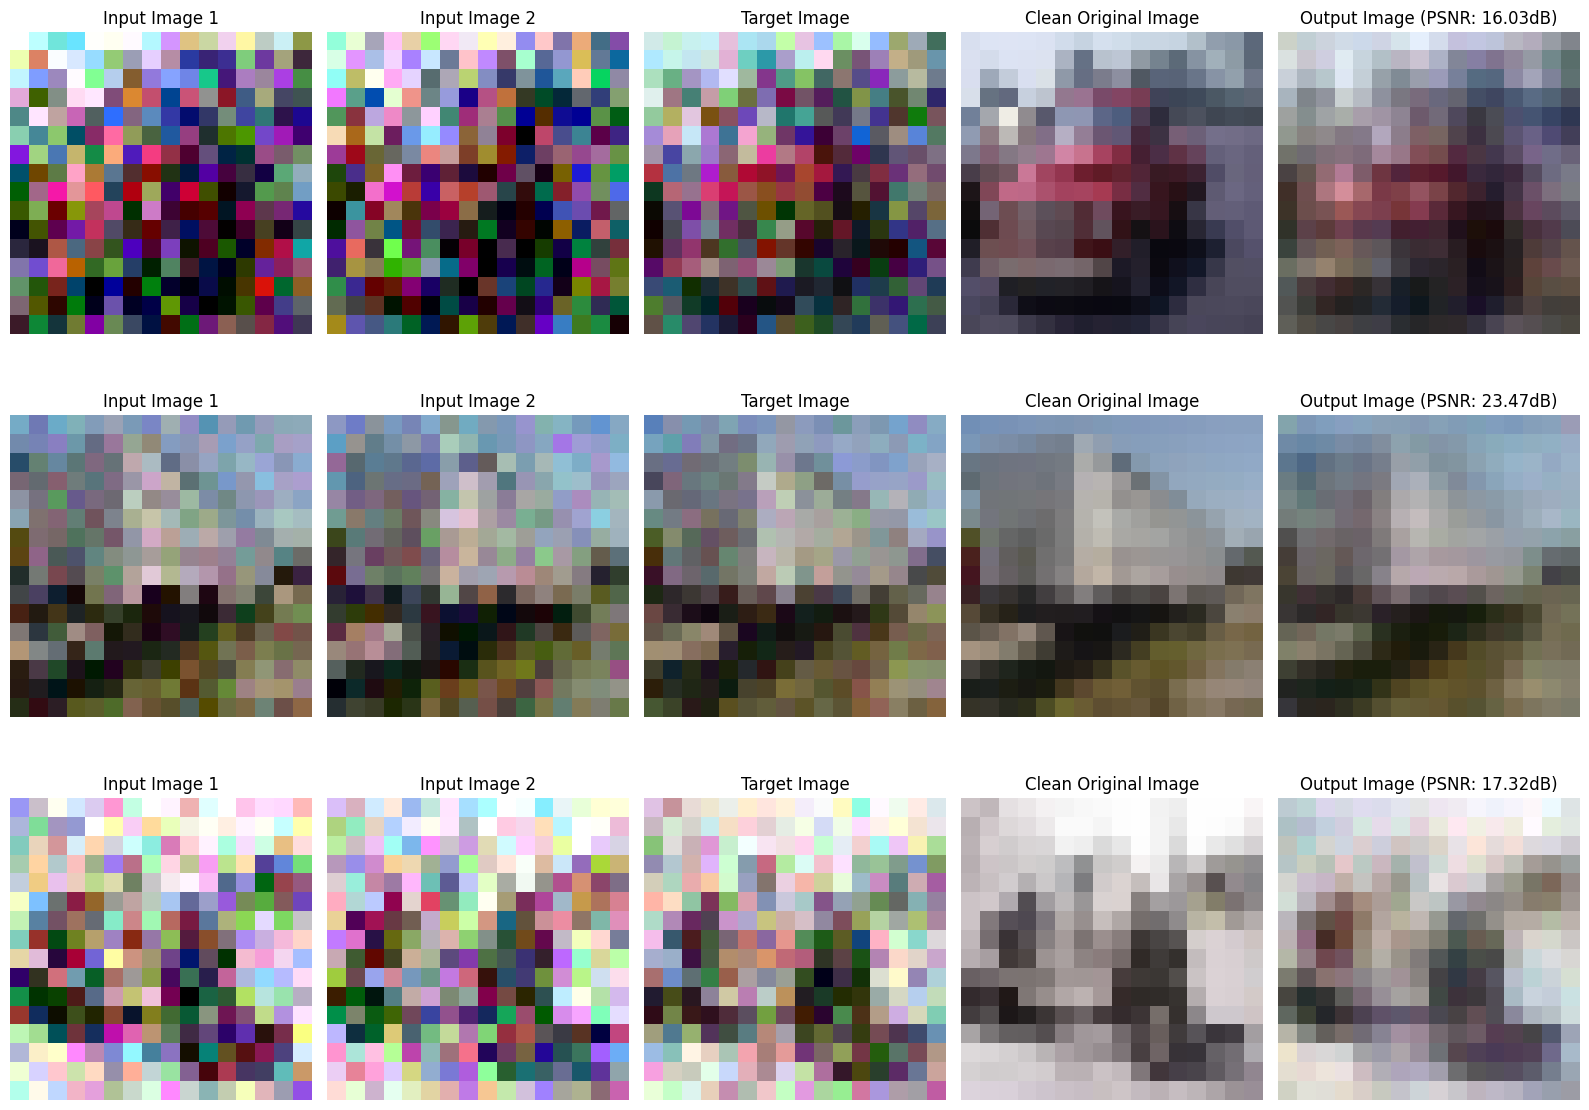

Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 16/50 - Train Loss: 0.0127, Val Loss: 0.0128, Val PSNR: 24.30dB


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Epoch 17/50 - Train Loss: 0.0127, Val Loss: 0.0130, Val PSNR: 23.81dB


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


Epoch 18/50 - Train Loss: 0.0128, Val Loss: 0.0127, Val PSNR: 24.42dB


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 19/50 - Train Loss: 0.0126, Val Loss: 0.0127, Val PSNR: 24.24dB


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch 20/50 - Train Loss: 0.0127, Val Loss: 0.0125, Val PSNR: 24.56dB


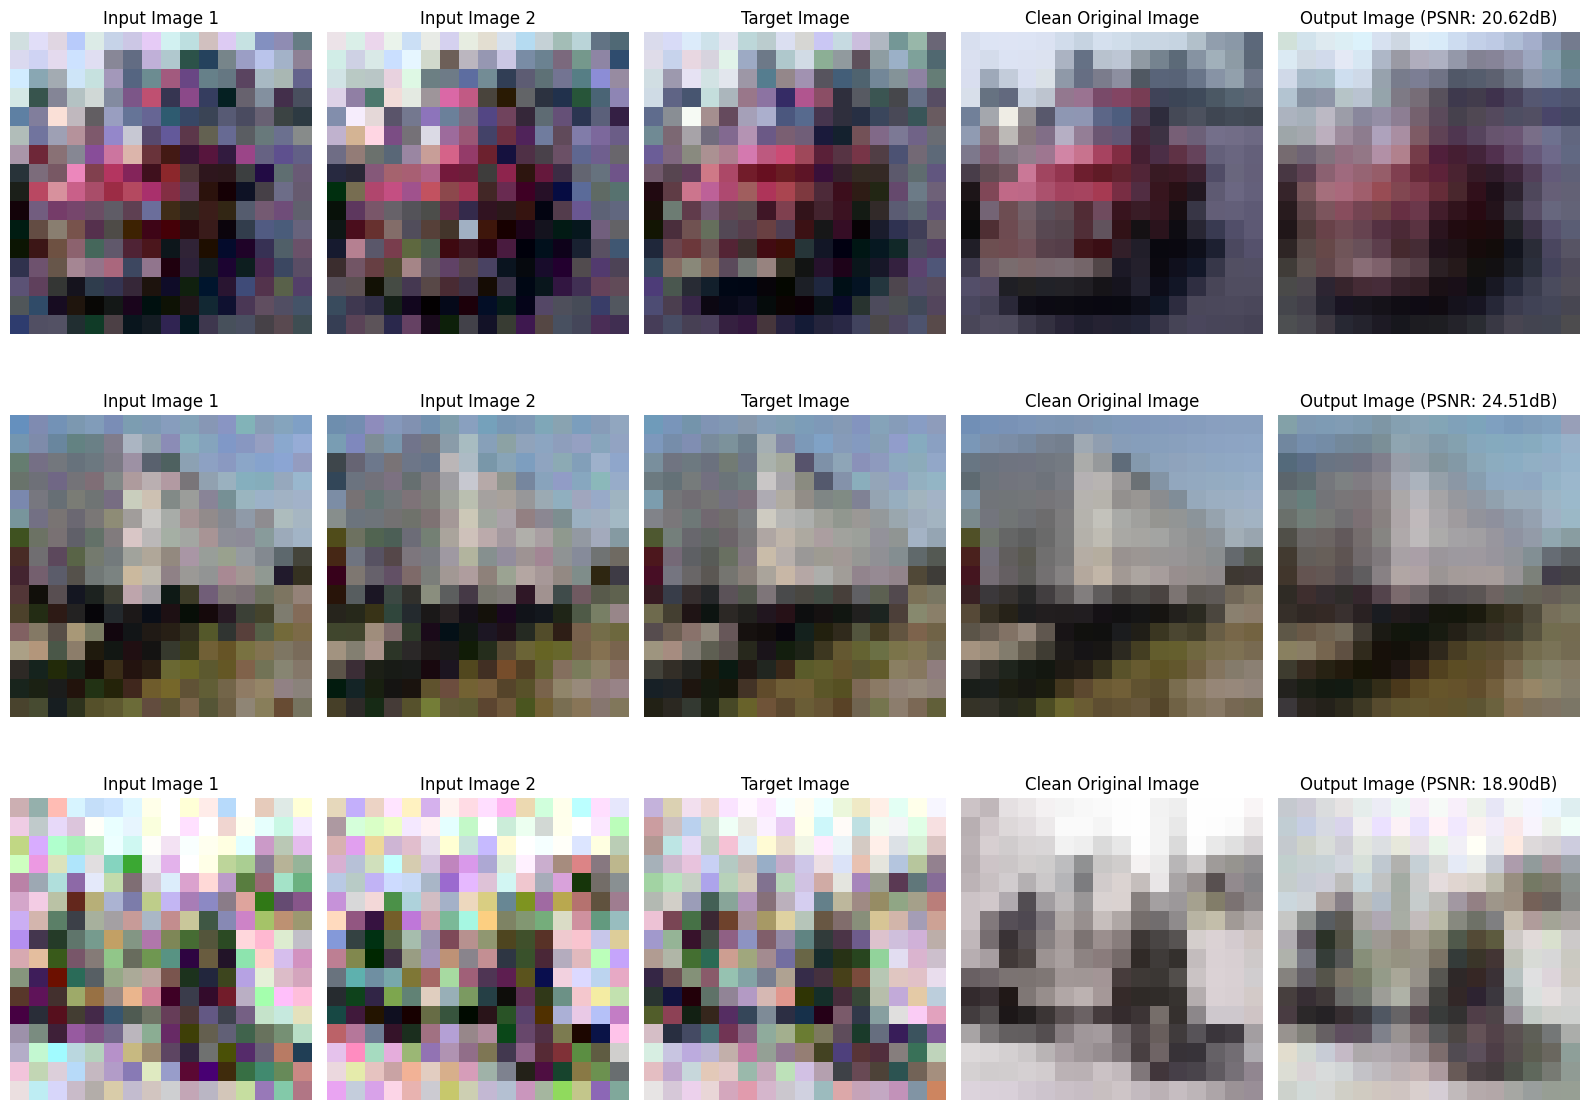

Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 21/50 - Train Loss: 0.0125, Val Loss: 0.0123, Val PSNR: 24.70dB
모델 저장됨 (Val Loss: 0.0123)


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 22/50 - Train Loss: 0.0126, Val Loss: 0.0121, Val PSNR: 24.69dB
모델 저장됨 (Val Loss: 0.0121)


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 23/50 - Train Loss: 0.0126, Val Loss: 0.0120, Val PSNR: 24.75dB
모델 저장됨 (Val Loss: 0.0120)


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


Epoch 24/50 - Train Loss: 0.0123, Val Loss: 0.0125, Val PSNR: 24.68dB


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.33s/it]


Epoch 25/50 - Train Loss: 0.0124, Val Loss: 0.0122, Val PSNR: 24.51dB


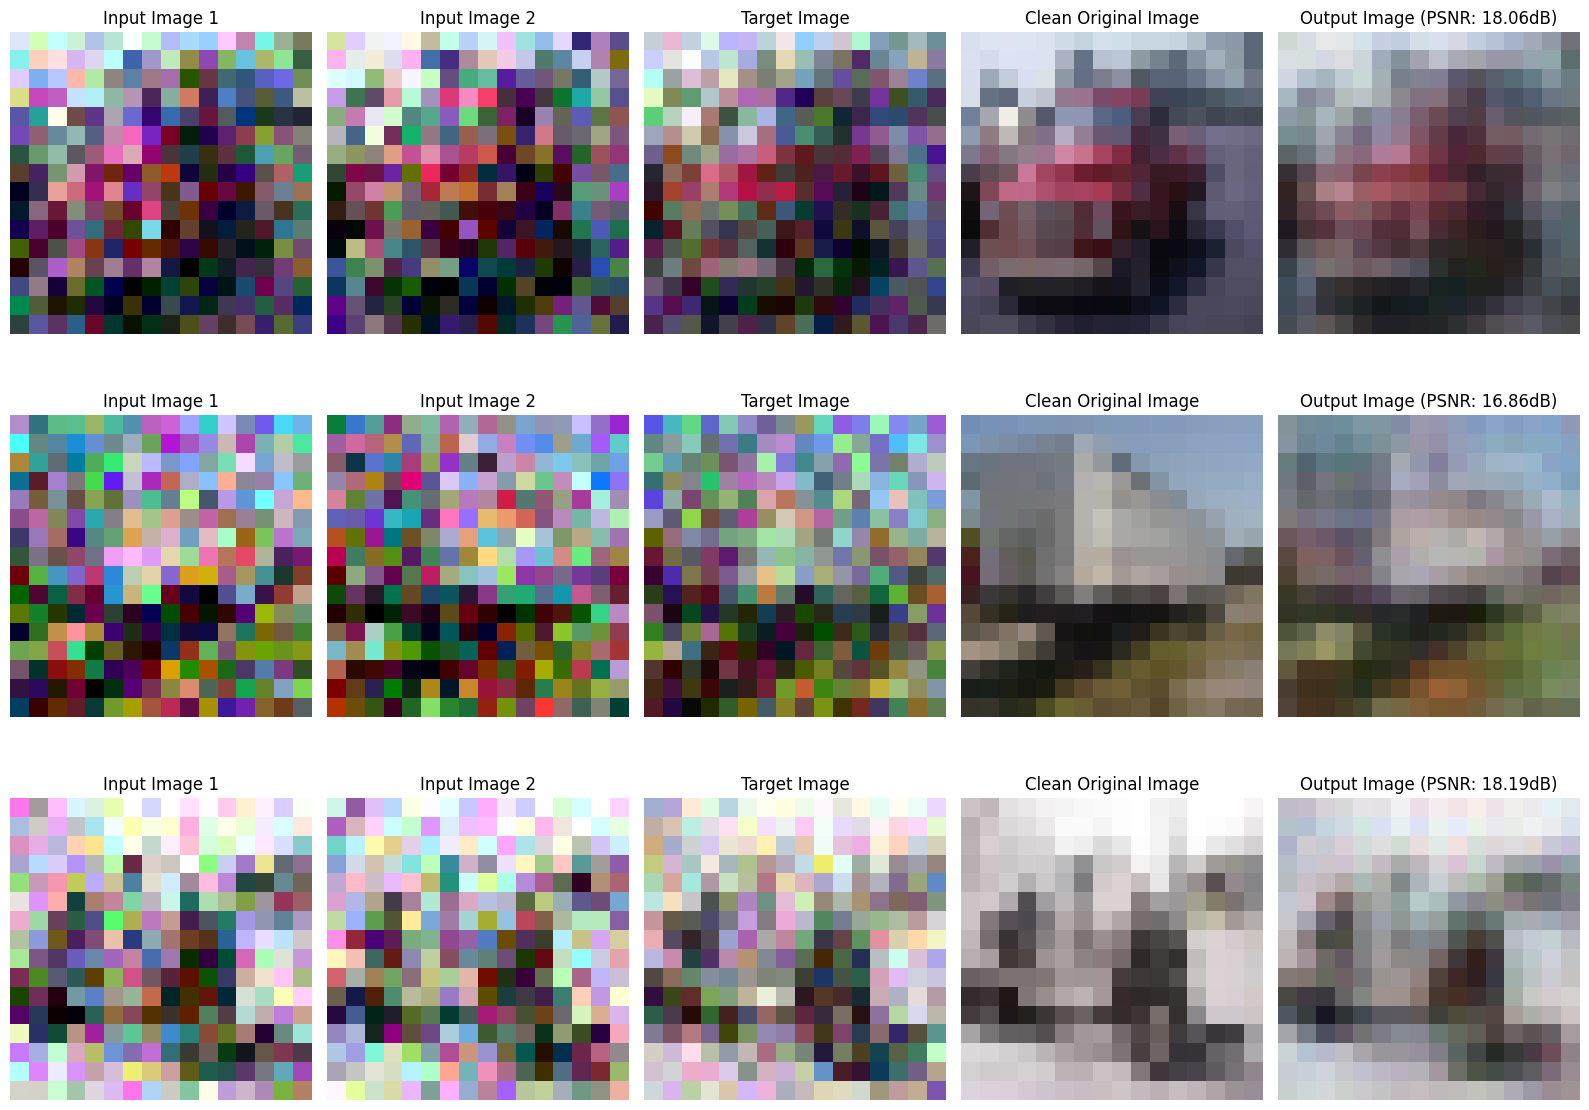

Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.36s/it]


Epoch 26/50 - Train Loss: 0.0125, Val Loss: 0.0125, Val PSNR: 24.47dB


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 27/50 - Train Loss: 0.0126, Val Loss: 0.0124, Val PSNR: 24.66dB


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.40s/it]


Epoch 28/50 - Train Loss: 0.0124, Val Loss: 0.0121, Val PSNR: 24.75dB


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 29/50 - Train Loss: 0.0122, Val Loss: 0.0123, Val PSNR: 24.74dB


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 30/50 - Train Loss: 0.0122, Val Loss: 0.0123, Val PSNR: 24.88dB


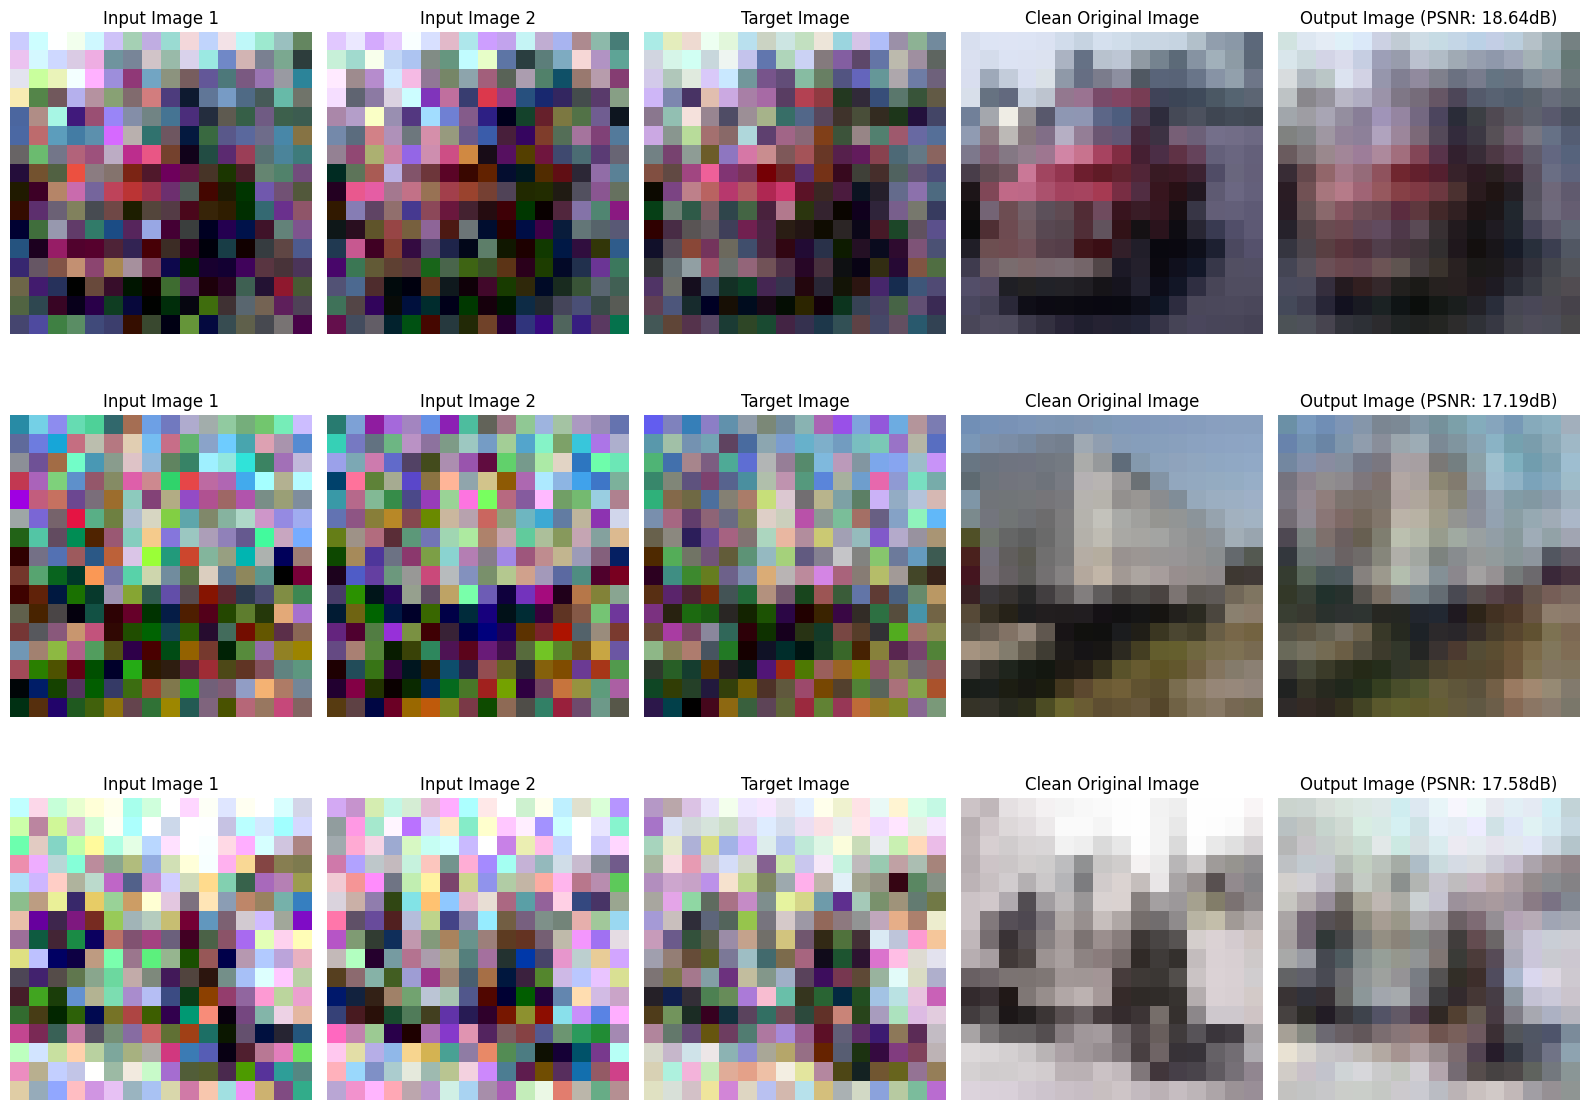

Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.34s/it]


Epoch 31/50 - Train Loss: 0.0123, Val Loss: 0.0127, Val PSNR: 23.96dB


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Epoch 32/50 - Train Loss: 0.0126, Val Loss: 0.0136, Val PSNR: 24.05dB


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Epoch 33/50 - Train Loss: 0.0124, Val Loss: 0.0128, Val PSNR: 24.32dB


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.40s/it]


Epoch 34/50 - Train Loss: 0.0126, Val Loss: 0.0123, Val PSNR: 24.83dB


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 35/50 - Train Loss: 0.0122, Val Loss: 0.0121, Val PSNR: 24.80dB


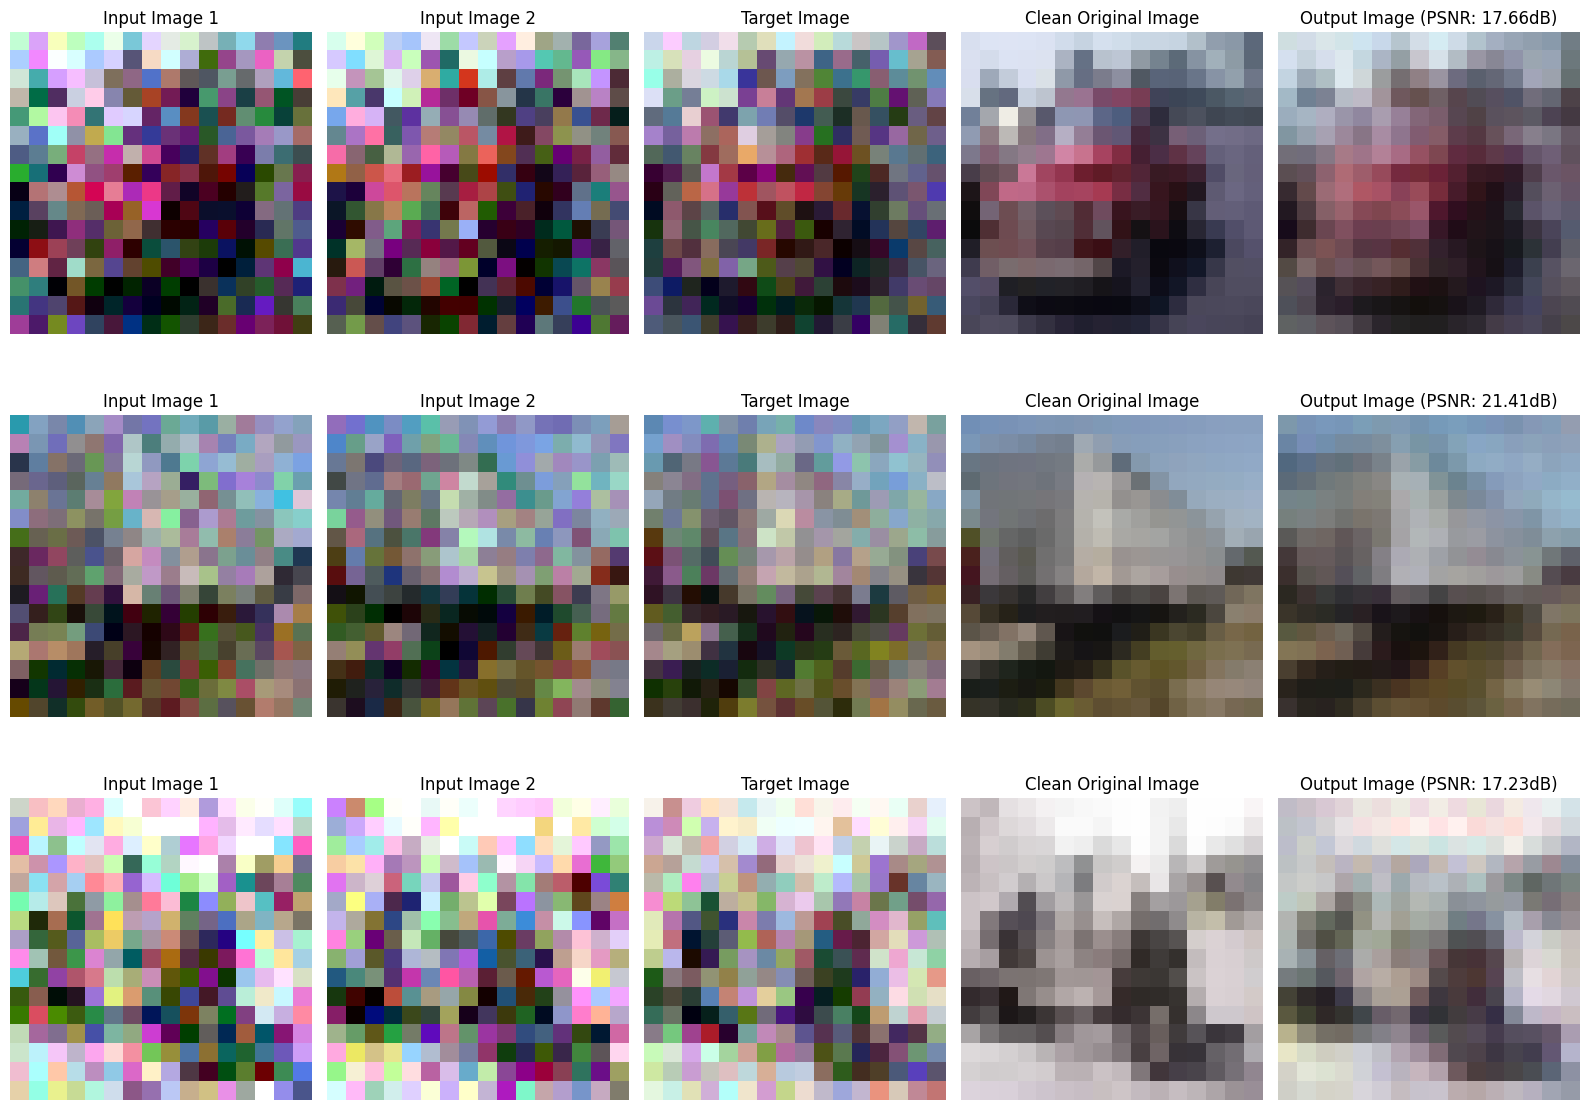

Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]


Epoch 36/50 - Train Loss: 0.0123, Val Loss: 0.0121, Val PSNR: 24.91dB


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Epoch 37/50 - Train Loss: 0.0121, Val Loss: 0.0123, Val PSNR: 24.54dB


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.26s/it]


Epoch 38/50 - Train Loss: 0.0123, Val Loss: 0.0122, Val PSNR: 24.91dB


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 39/50 - Train Loss: 0.0123, Val Loss: 0.0122, Val PSNR: 24.80dB


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch 40/50 - Train Loss: 0.0123, Val Loss: 0.0123, Val PSNR: 25.02dB


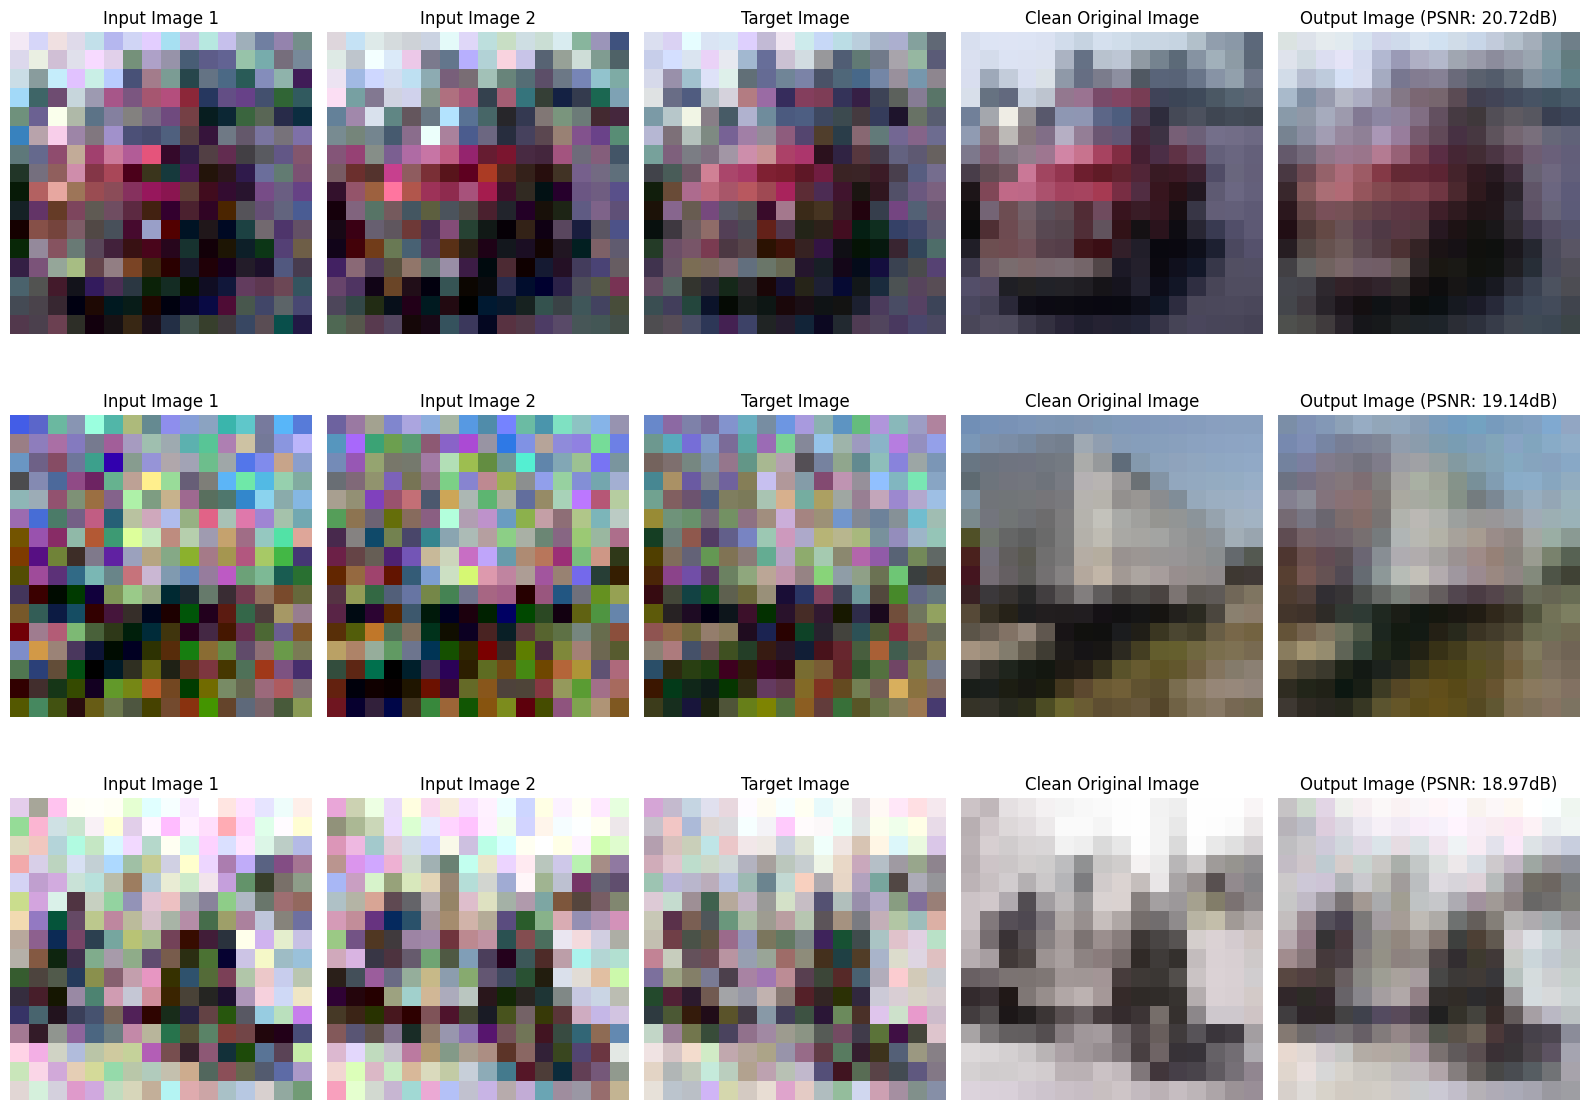

Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]


Epoch 41/50 - Train Loss: 0.0121, Val Loss: 0.0121, Val PSNR: 24.95dB


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch 42/50 - Train Loss: 0.0122, Val Loss: 0.0121, Val PSNR: 24.66dB


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.26s/it]


Epoch 43/50 - Train Loss: 0.0124, Val Loss: 0.0121, Val PSNR: 24.85dB


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 44/50 - Train Loss: 0.0124, Val Loss: 0.0117, Val PSNR: 25.03dB
모델 저장됨 (Val Loss: 0.0117)


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.29s/it]


Epoch 45/50 - Train Loss: 0.0122, Val Loss: 0.0119, Val PSNR: 24.97dB


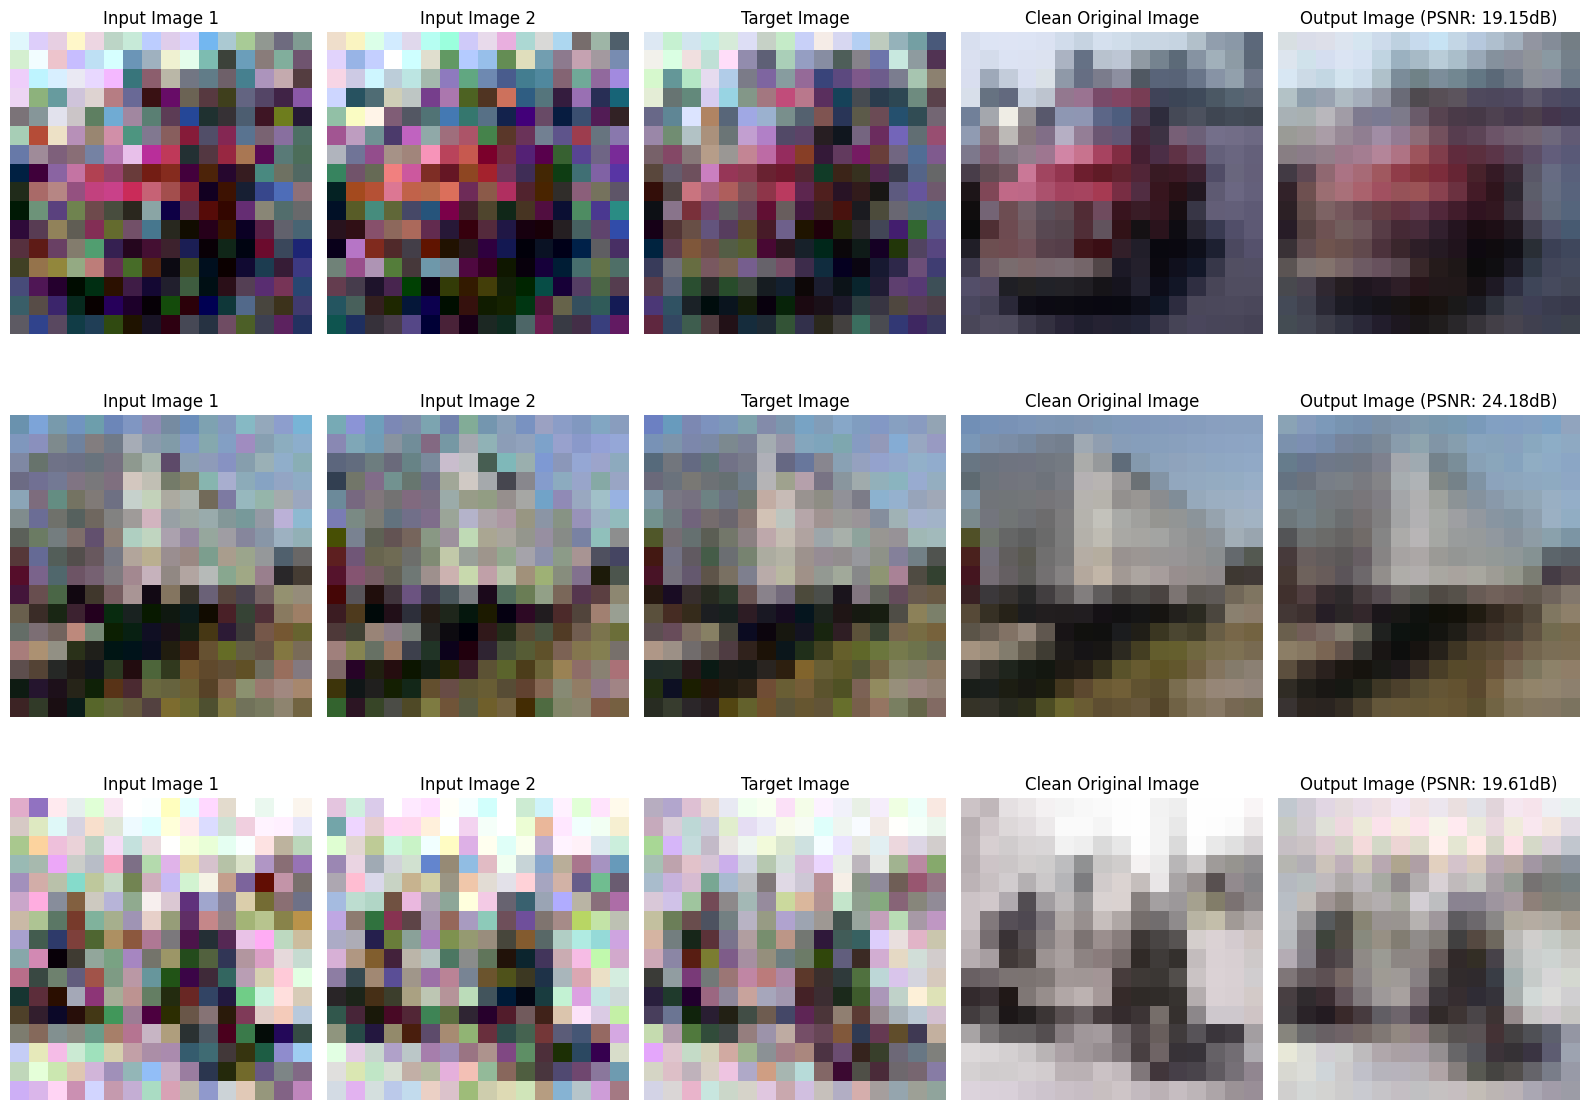

Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 46/50 - Train Loss: 0.0121, Val Loss: 0.0121, Val PSNR: 25.04dB


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.26s/it]


Epoch 47/50 - Train Loss: 0.0121, Val Loss: 0.0120, Val PSNR: 24.82dB


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


Epoch 48/50 - Train Loss: 0.0123, Val Loss: 0.0119, Val PSNR: 25.14dB


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.29s/it]


Epoch 49/50 - Train Loss: 0.0122, Val Loss: 0.0122, Val PSNR: 24.80dB


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]


Epoch 50/50 - Train Loss: 0.0122, Val Loss: 0.0126, Val PSNR: 24.35dB


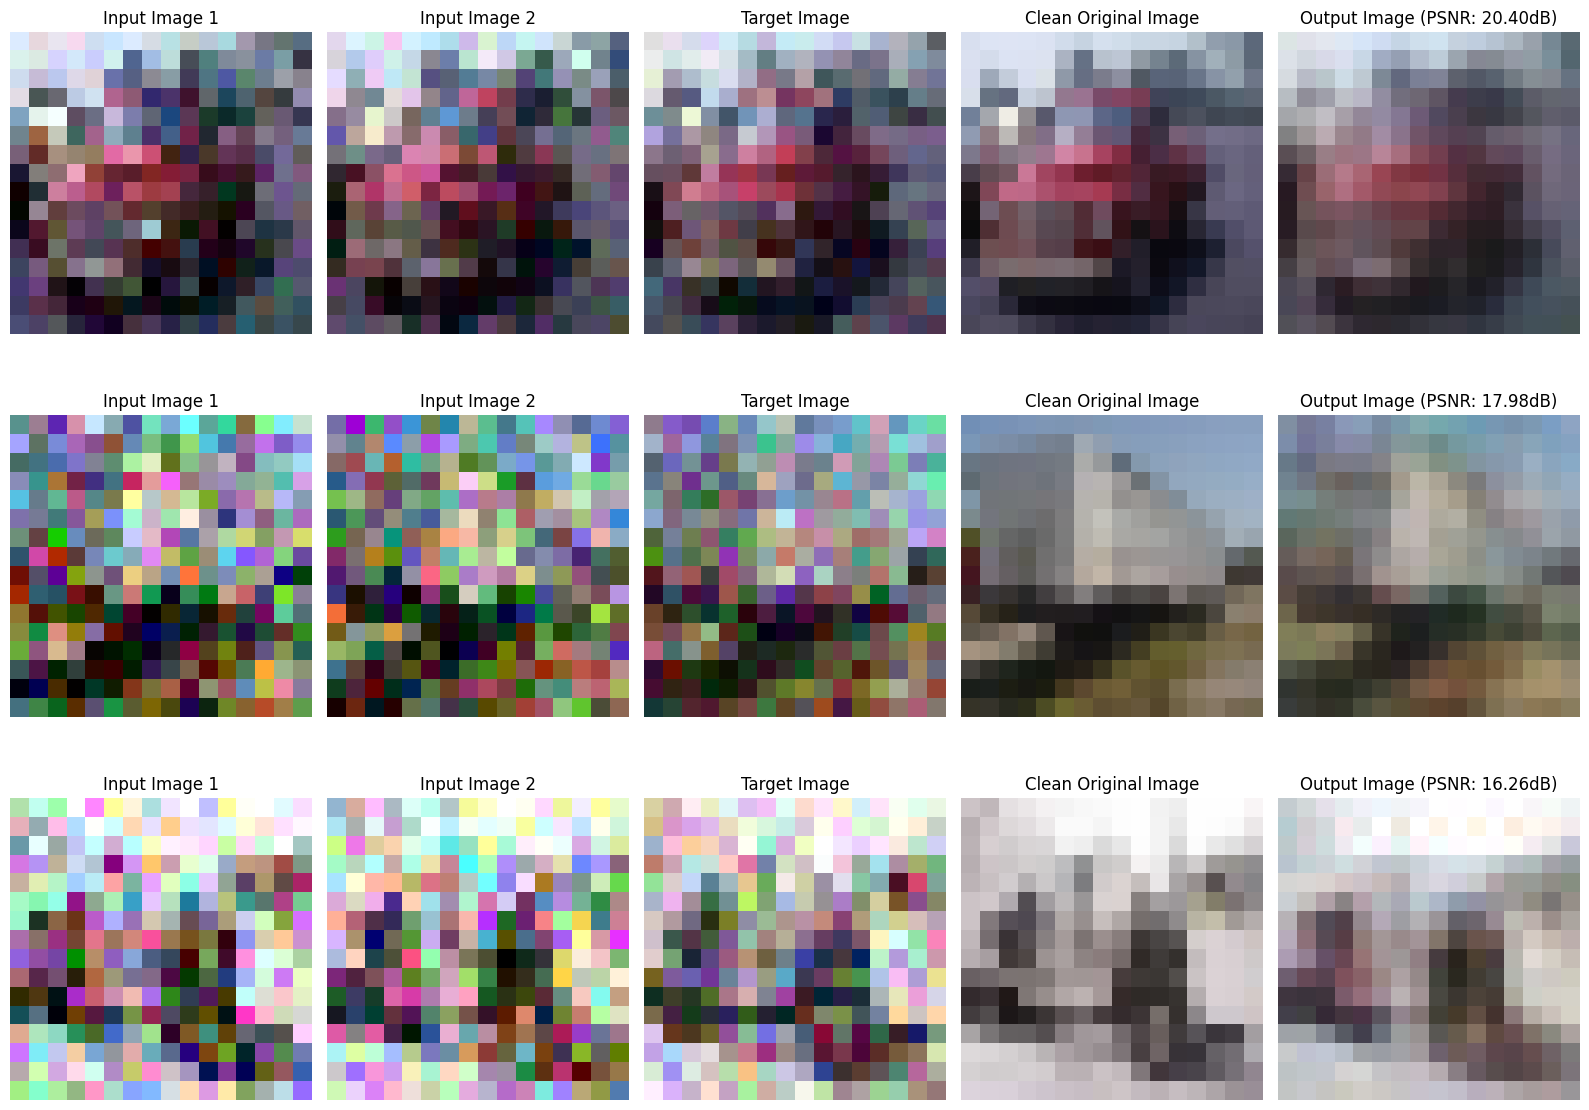

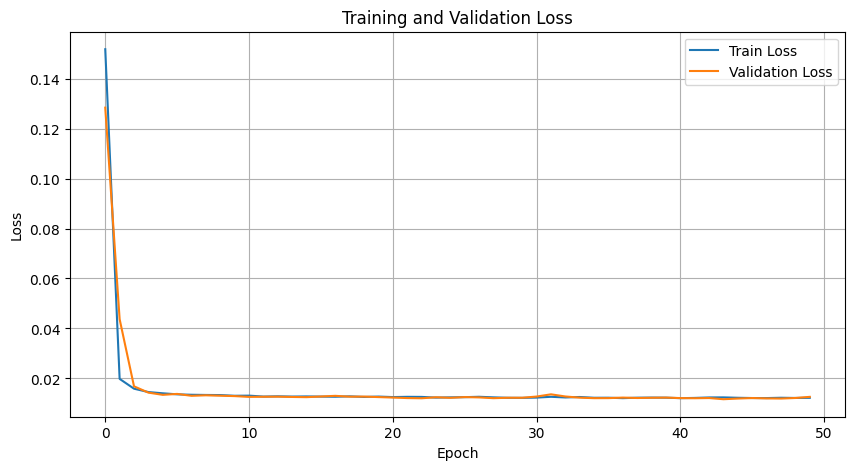

C:\Users\pook0\AppData\Local\Temp\ipykernel_9132\1344151917.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./checkpoints/best_unet_


테스트 결과:
테스트 손실: 0.0120
테스트 PSNR: 24.99dB

최종 예측 결과 시각화:


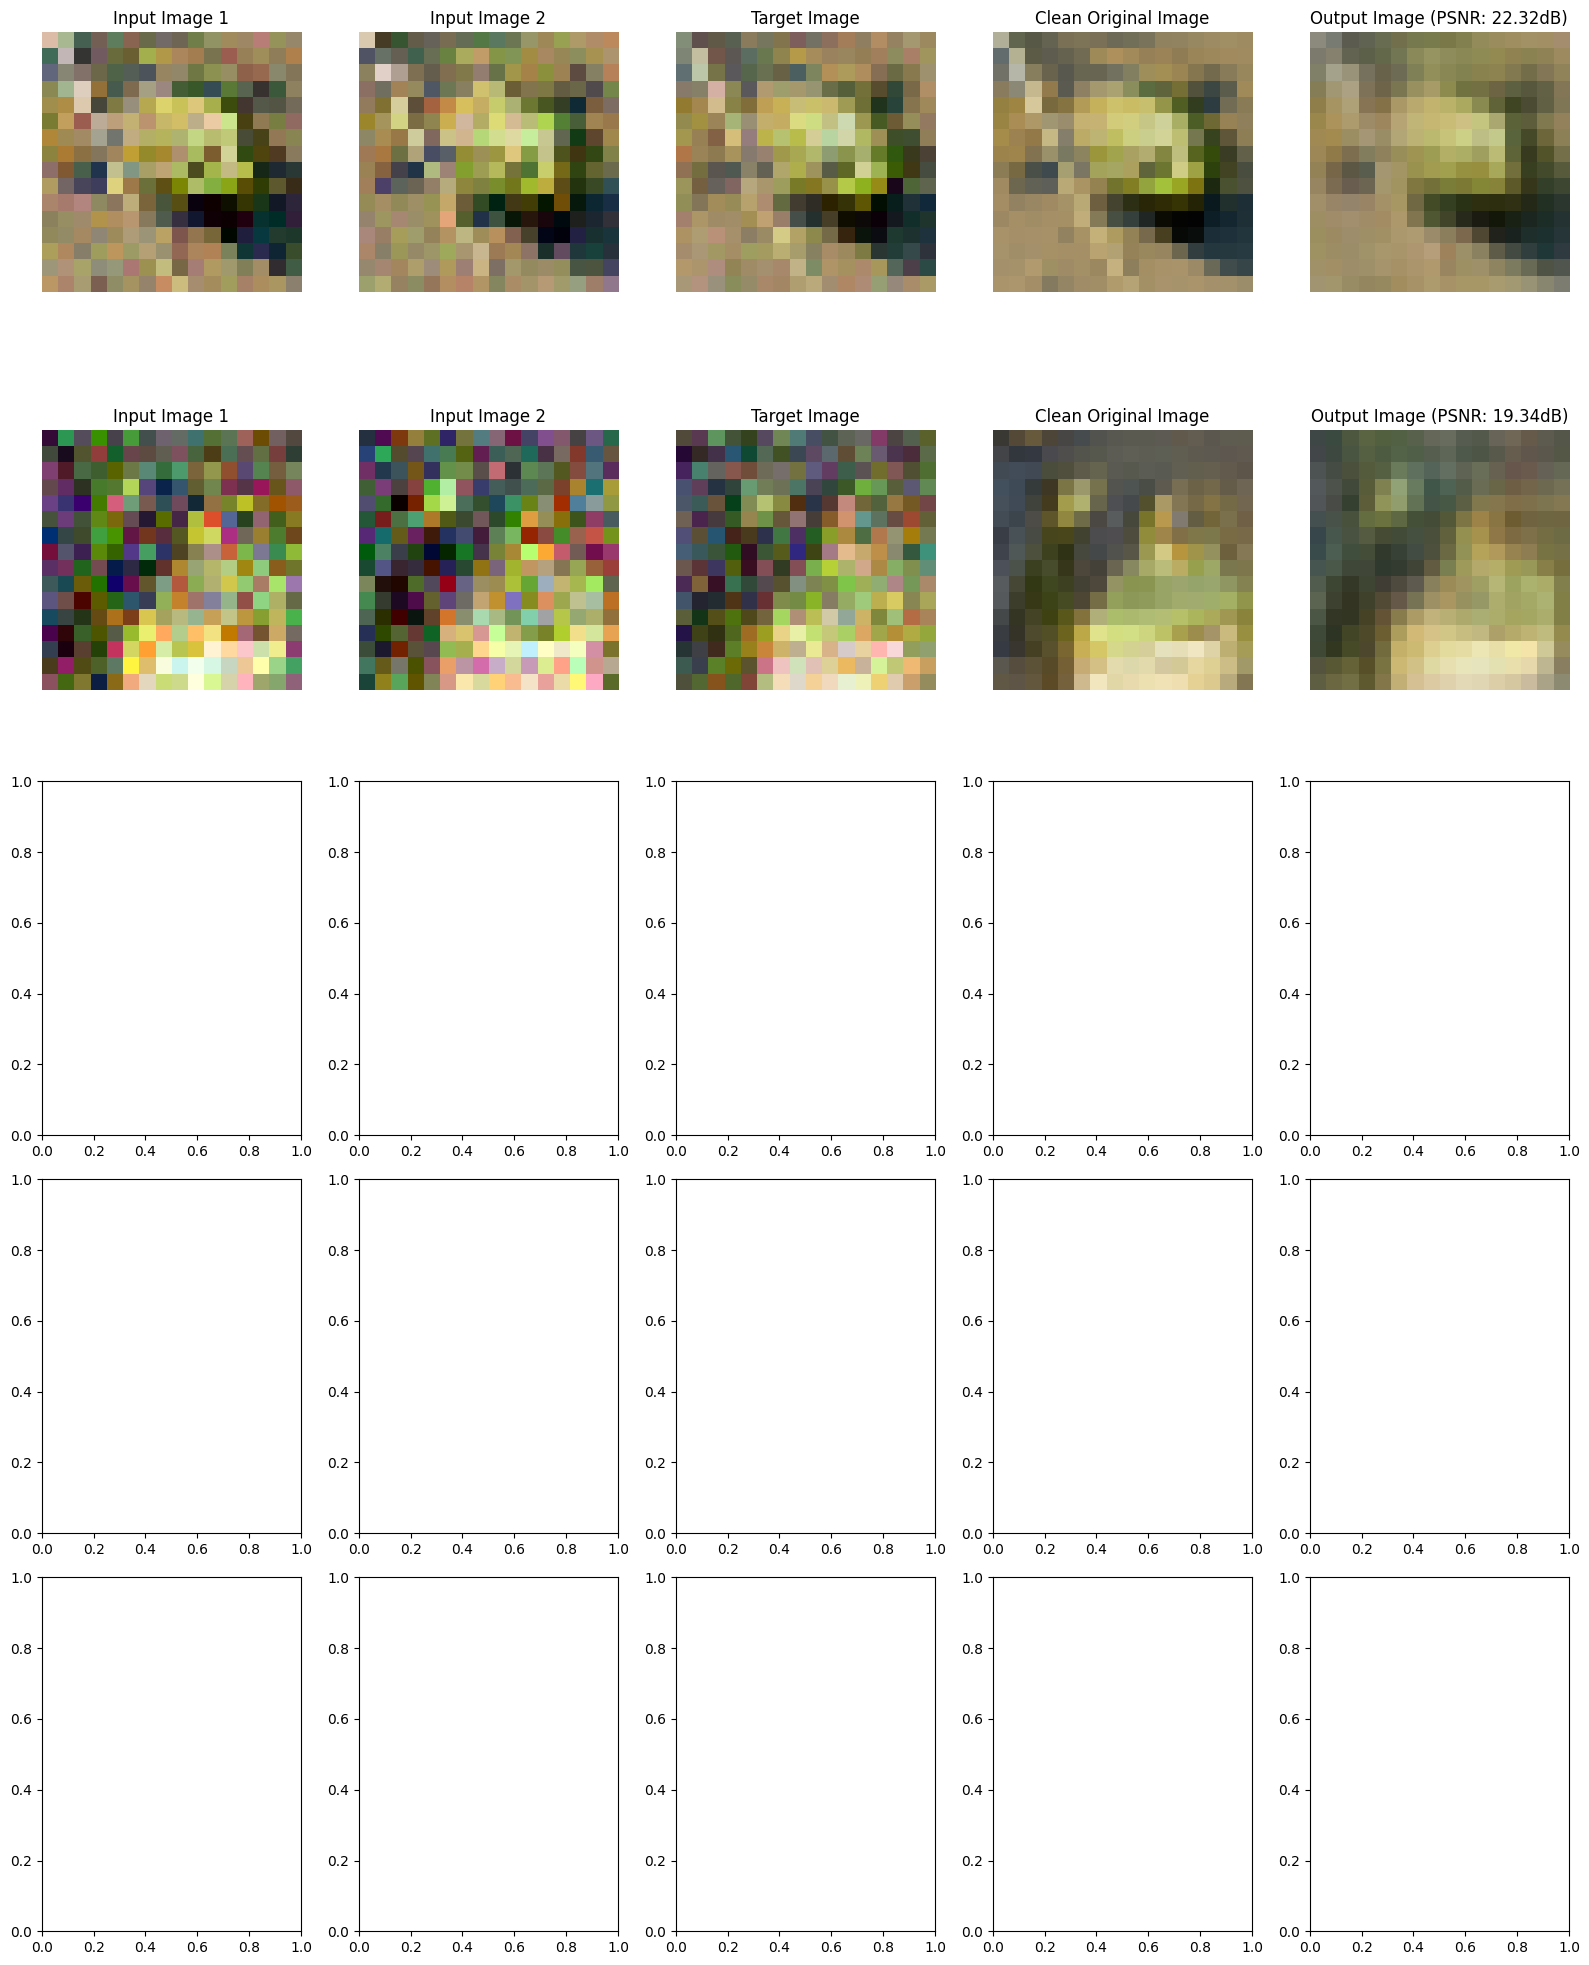

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time

# UNet_CA 모델 정의
class UNet_CA(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, features=64):
        """
        경량화된 UNet 모델 (3단계 인코더-디코더 구조)
        
        Args:
            in_channels (int): 입력 채널 수 (2개의 RGB 이미지 concat -> 6)
            out_channels (int): 출력 채널 수 (RGB 이미지 -> 3)
            features (int): 기본 특징 맵 수
        """
        super(UNet_CA, self).__init__()
        
        # 인코더 (다운샘플링 경로)
        self.encoder1 = self._double_conv(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = self._double_conv(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = self._double_conv(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder4 = self._double_conv(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 병목 부분
        self.bottleneck = self._double_conv(features * 8, features * 8)
        
        # 디코더 (업샘플링 경로)
        self.upconv4 = nn.ConvTranspose2d(features * 8, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._double_conv(features * 16, features * 8)
        
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._double_conv(features * 8, features * 4)  # 스킵 연결로 채널 수 2배
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._double_conv(features * 4, features * 2)  # 스킵 연결로 채널 수 2배
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._double_conv(features * 2, features)  # 스킵 연결로 채널 수 2배
        
        # 최종 출력 레이어
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

        
        # Cross Attention을 위한 변환 레이어
        self.q_proj1 = nn.Conv2d(features * 4, features * 4, kernel_size=1)
        self.k_proj1 = nn.Conv2d(features * 4, features * 4, kernel_size=1)
        self.v_proj1 = nn.Conv2d(features * 4, features * 4, kernel_size=1)

        # 출력 조정을 위한 레이어
        self.out_proj1 = nn.Conv2d(features * 8, features * 8, kernel_size=1)
        
        
    
    def _double_conv(self, in_channels, out_channels):
        """두 번의 컨볼루션 레이어 (Conv -> BN -> ReLU) x 2"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def cross_attention(self, x):
        """
        Cross Attention 레이어
        
        Args:
            x: Query 텐서 (B, C, H, W)
            y: Key, Value 텐서 (B, C, H, W)
        
        Returns:
            Cross Attention 적용 결과
        """
        # Query, Key, Value 텐서 생성
        
        features_half = x.shape[1] // 2
        q_features = x[:, :features_half, ...]
        kv_features = x[:, features_half:, ...]
        
        q = self.q_proj1(q_features)
        k = self.k_proj1(kv_features)
        v = self.v_proj1(kv_features)
        
        # Attention Map 계산
        attn_map = F.softmax(torch.matmul(q, k.transpose(-2, -1)), dim=-1)
        
        # Weighted Sum 계산
        out = torch.matmul(attn_map, v)
        
        out = torch.cat((out, q_features), dim=1)
        
        # 출력 조정
        out = self.out_proj1(out)
        
        return out
    
    def forward(self, x):
        """
        순전파
        
        Args:
            x: 입력 이미지 텐서 (B, 6, H, W) - 2개의 RGB 이미지 concat
            
        Returns:
            출력 이미지 텐서 (B, 3, H, W)
        """
        # 인코더 경로
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # 병목 부분
        bottleneck = self.bottleneck(self.pool3(enc4))
        bottleneck = self.cross_attention(bottleneck)
        
        # 디코더 경로 (스킵 연결 포함)
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
    
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # 최종 출력
        return self.conv(dec1)

# 메인 함수
def main(num_layers, features, num_epochs, batch_size, learning_rate, noise_level, ca, device):
    # CIFAR-10 이미지 준비 (없으면 다운로드)
    image_dir = './data/cifar10'
    prepare_cifar10_dataset(output_dir=image_dir, num_images=5000)
    
    # 시드 설정
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # 커널 샘플링 데이터셋 생성
    kernel_dataset = NoisyKernelSamplingDataset_2(
        image_dir=image_dir,
        kernel_size=2,
        # num_samples=3,
        noise_level=noise_level,
    )
    
    # 데이터셋 분할 (학습:검증:테스트 = 7:2:1)
    dataset_size = len(kernel_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        kernel_dataset, [train_size, val_size, test_size]
    )
    
    # DnCNN 데이터셋 래퍼 생성
    train_dncnn_dataset = DnCNNDatasetWrapper(train_dataset, input_indices=(0, 1), target_index=2)
    val_dncnn_dataset = DnCNNDatasetWrapper(val_dataset, input_indices=(0, 1), target_index=2)
    test_dncnn_dataset = DnCNNDatasetWrapper(test_dataset, input_indices=(0, 1), target_index=2)
    
    # 데이터로더 생성
    batch_size = batch_size
    train_loader = DataLoader(train_dncnn_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dncnn_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dncnn_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # 샘플 확인
    print("데이터 형태 확인:")
    inputs, targets, cleans = next(iter(train_loader))
    print(f"입력 형태: {inputs.shape} (배치, 채널, 높이, 너비)")  # [B, 6, H, W]
    print(f"타겟 형태: {targets.shape} (배치, 채널, 높이, 너비)")  # [B, 3, H, W]
    print(f"깨끗한 원본 형태: {cleans.shape} (배치, 채널, 높이, 너비)")  # [B, 3, H, W]
    
    if torch.equal(targets, cleans):
        print("Target and clean images are the same.")
    else:
        print("Target and clean images are different.")
    
    # 장치 설정
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"사용 장치: {device}")
    
    # DnCNN 모델 생성
    model = UNet_CA(in_channels=6, out_channels=3, features=features)
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters())}")
    
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # 학습 실행
    num_epochs = num_epochs
    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, ca=ca, noise_level=noise_level)
    
    # 최적 모델 로드
    model.load_state_dict(torch.load(f'./checkpoints/best_unet_model_ca_{noise_level}.pth'))
    
    # 테스트 셋 평가
    model.eval()
    test_loss = 0.0
    test_psnr = 0.0
    
    with torch.no_grad():
        for inputs, targets, cleans in tqdm(test_loader, desc="테스트 중"):
            inputs, targets, cleans = inputs.to(device), targets.to(device), cleans.to(device)
            
            # 순전파
            outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            # PSNR 계산
            for i in range(outputs.size(0)):
                mse = F.mse_loss(outputs[i], cleans[i]).item()
                psnr = -10 * np.log10(mse) if mse > 0 else 100
                test_psnr += psnr
    
    # 평균 테스트 손실 및 PSNR
    test_loss = test_loss / len(test_loader.dataset)
    test_psnr = test_psnr / len(test_loader.dataset)
    
    print(f"\n테스트 결과:")
    print(f"테스트 손실: {test_loss:.4f}")
    print(f"테스트 PSNR: {test_psnr:.2f}dB")
    
    # 최종 결과 시각화
    print("\n최종 예측 결과 시각화:")
    visualize_input_target_output(model, test_loader, device, num_samples=5)

if __name__ == "__main__":
    num_layers = 15
    features = 64
    num_epochs = 50
    batch_size = 256
    learning_rate = 0.001
    noise_level = 0.2
    ca = 'ca'
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    main(num_layers, features, num_epochs, batch_size, learning_rate, noise_level, ca, device)
    

## 학습이 끝난 두 모델 불러와서 비교 및 시각화

사용 디바이스: cuda


C:\Users\pook0\AppData\Local\Temp\ipykernel_9132\1072396488.py:429: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dncnn_model.load_state_dict(torch.load(dncnn_path, map_loca

DnCNN 모델 로드 성공: ./checkpoints/best_unet_model_0.2.pth
DnCNN+CA 모델 로드 성공: ./checkpoints/best_unet_model_ca_0.2.pth
총 5000개 이미지 로드됨

UNet 모델 테스트 중...


Testing: 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]



UNet+CA 모델 테스트 중...


Testing: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]



===== 테스트 결과 =====
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
DnCNN 모델 파라미터 수: 31039491, GFLOPs: 0.857178112
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn

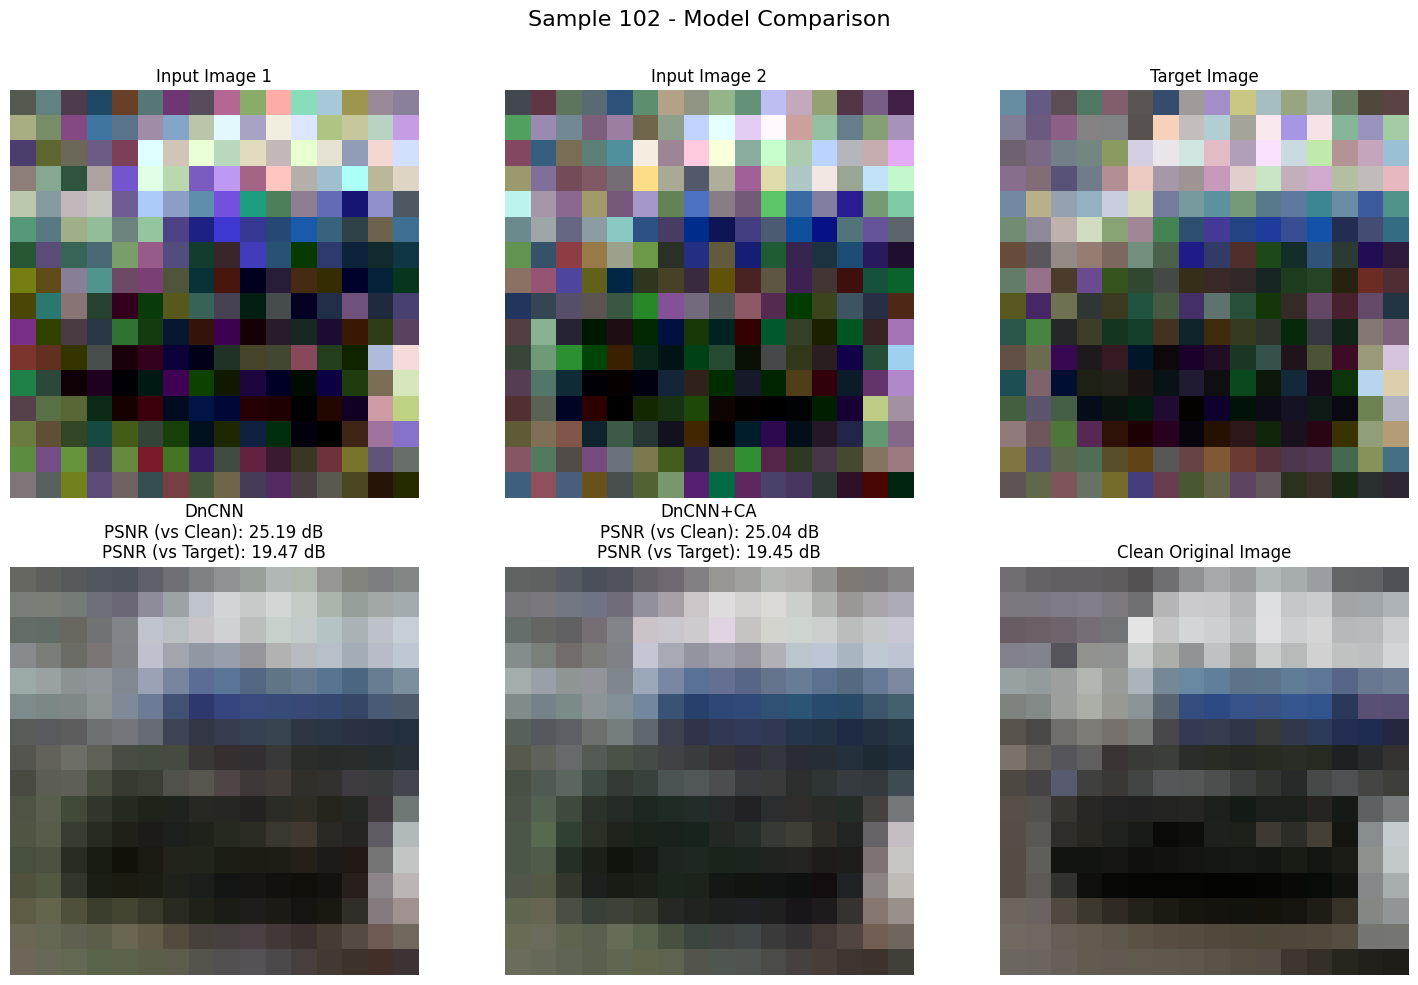

Sample 102:
  DnCNN PSNR vs Clean: 25.19 dB, vs Target: 19.47 dB
  DnCNN+CA PSNR vs Clean: 25.04 dB, vs Target: 19.45 dB
  PSNR 향상 (vs Clean): -0.16 dB (-0.62%)
--------------------------------------------------


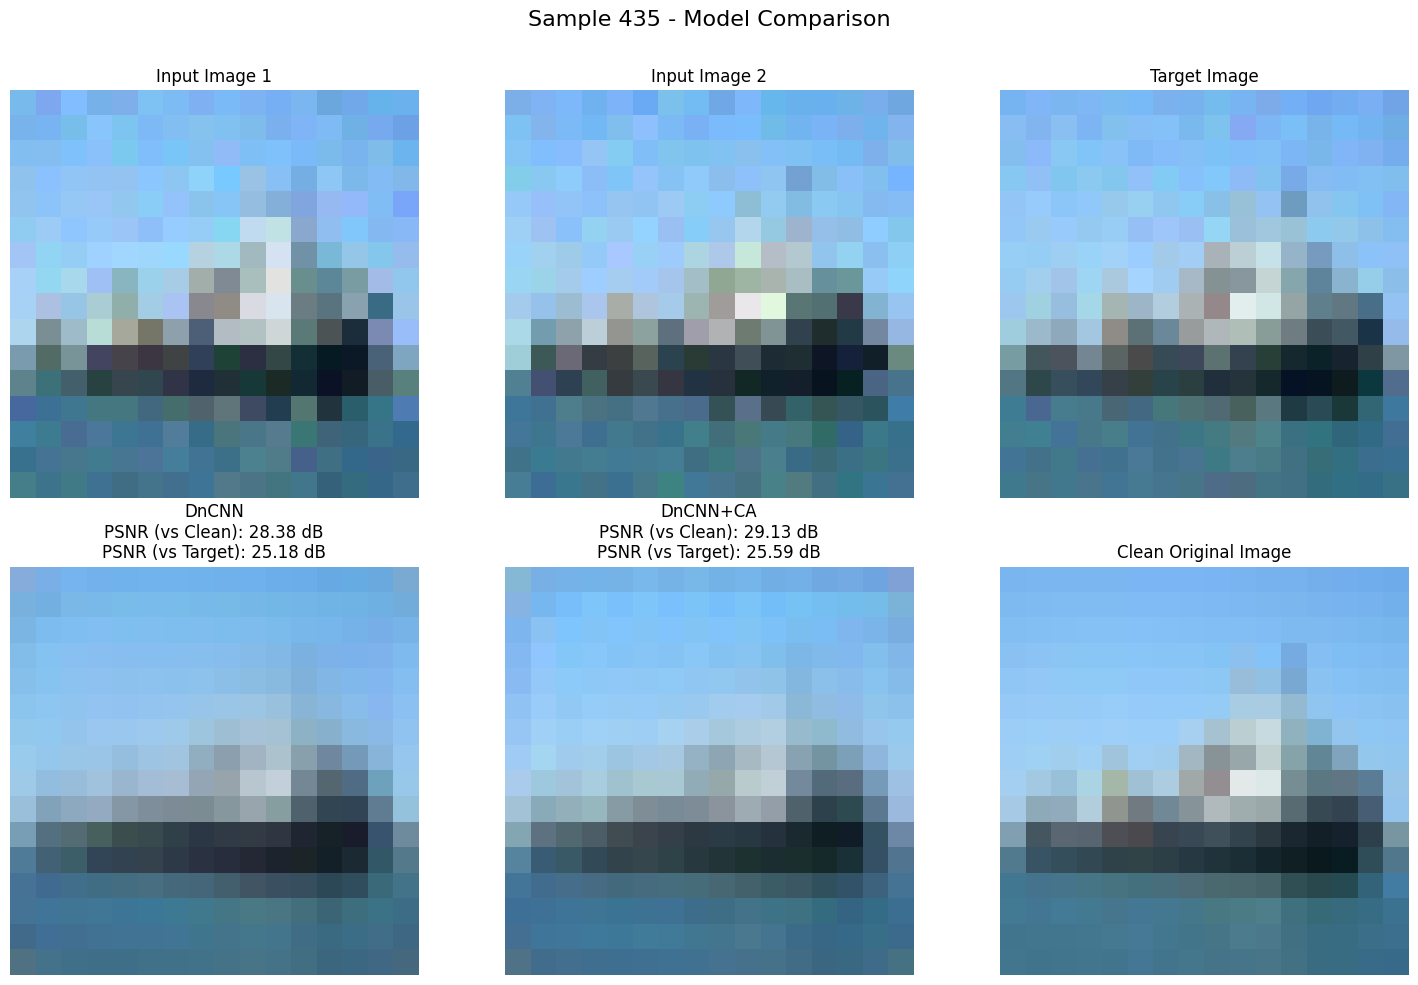

Sample 435:
  DnCNN PSNR vs Clean: 28.38 dB, vs Target: 25.18 dB
  DnCNN+CA PSNR vs Clean: 29.13 dB, vs Target: 25.59 dB
  PSNR 향상 (vs Clean): 0.75 dB (2.65%)
--------------------------------------------------


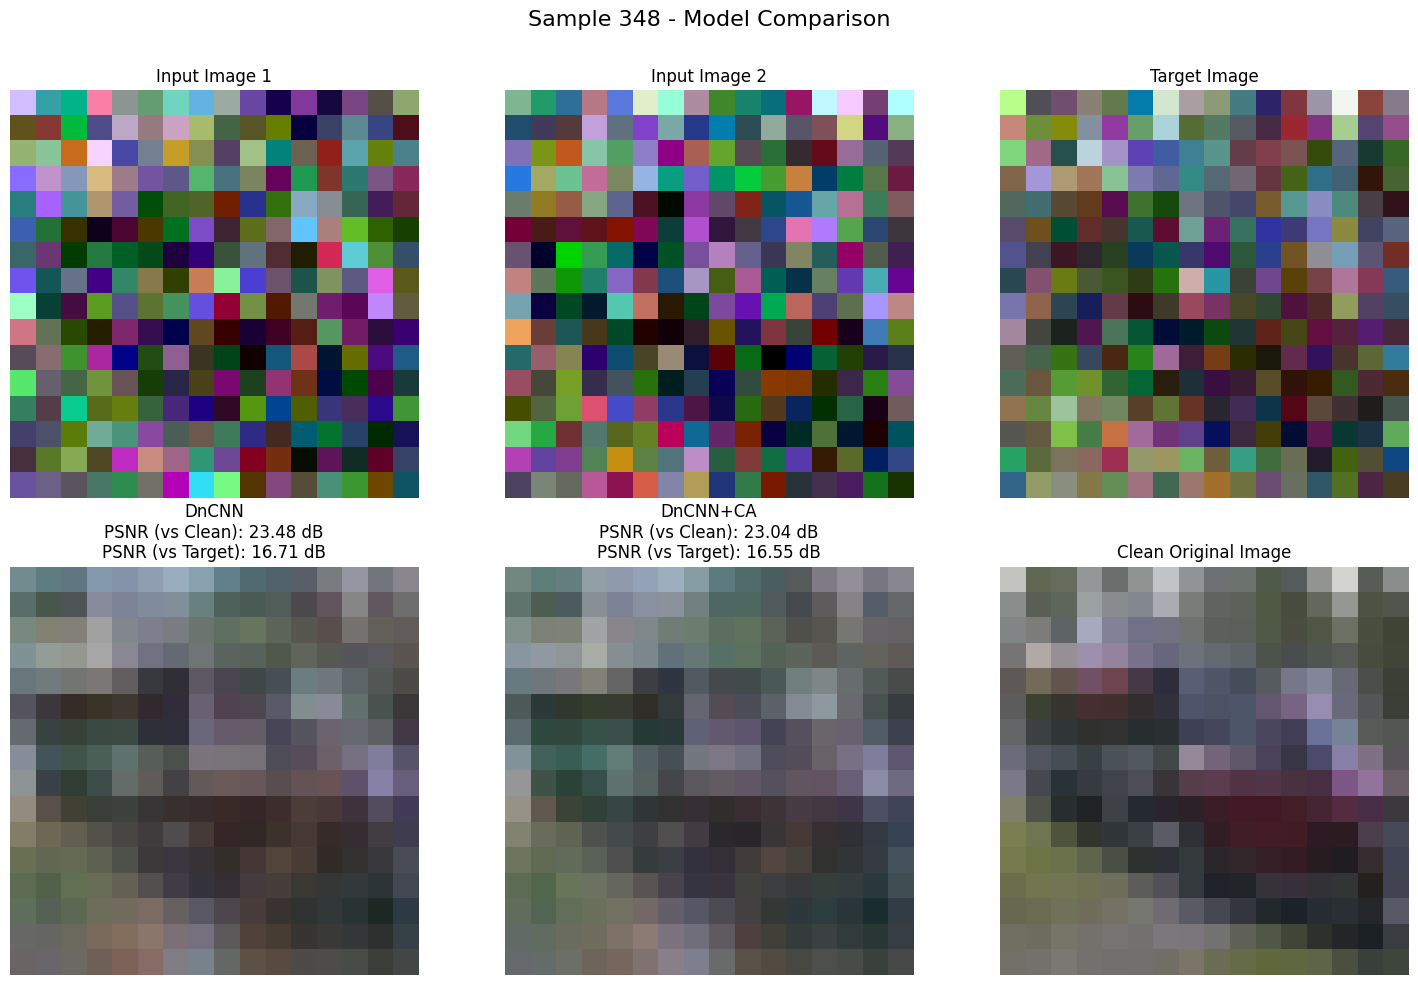

Sample 348:
  DnCNN PSNR vs Clean: 23.48 dB, vs Target: 16.71 dB
  DnCNN+CA PSNR vs Clean: 23.04 dB, vs Target: 16.55 dB
  PSNR 향상 (vs Clean): -0.45 dB (-1.90%)
--------------------------------------------------


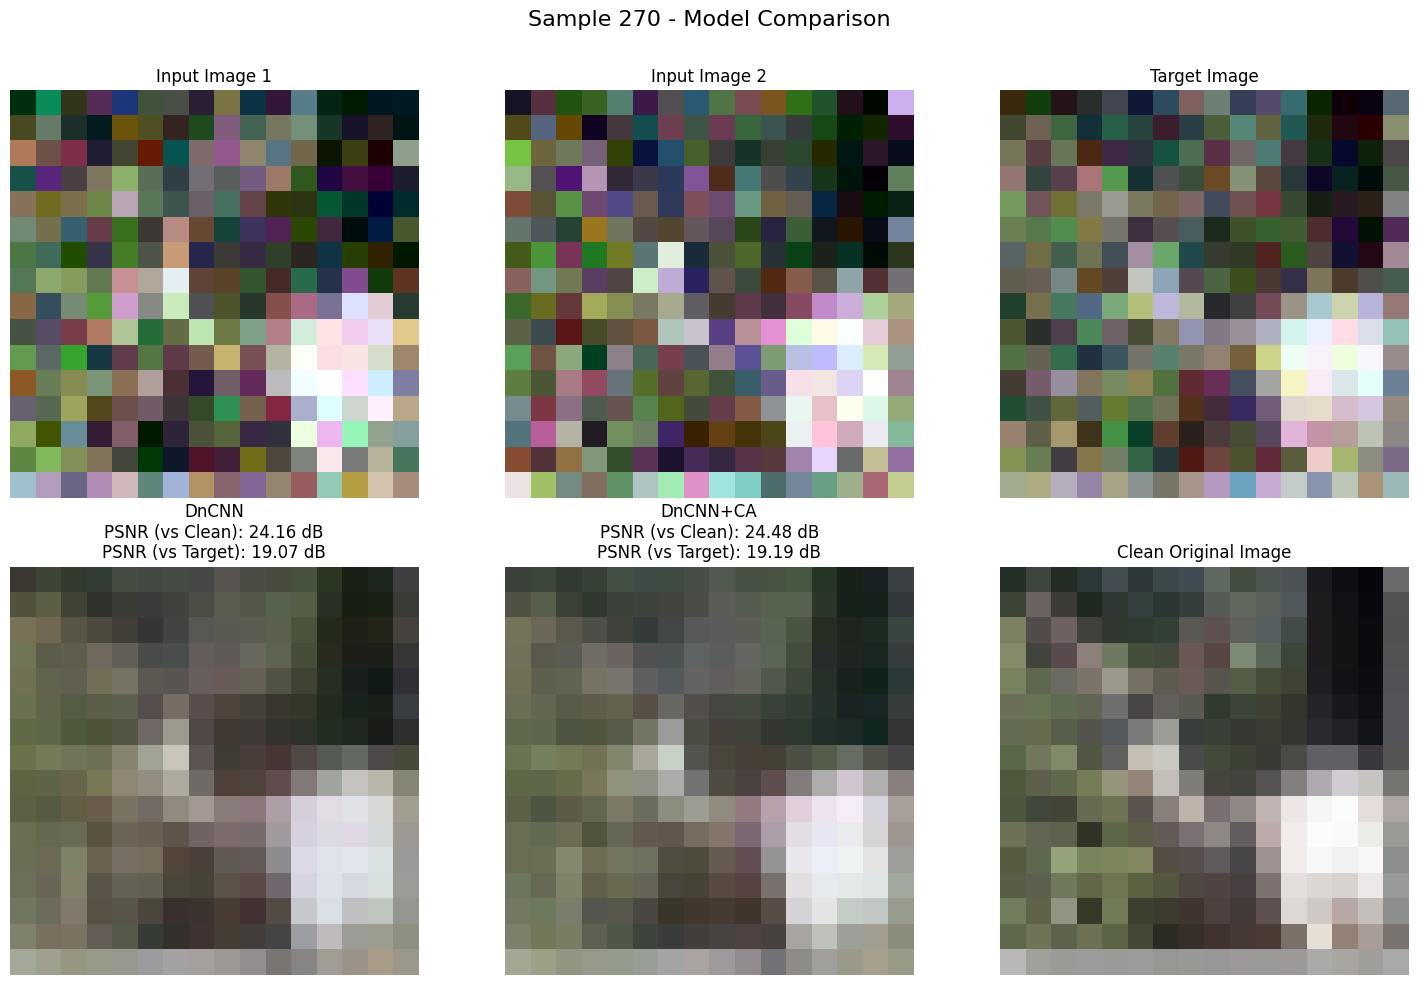

Sample 270:
  DnCNN PSNR vs Clean: 24.16 dB, vs Target: 19.07 dB
  DnCNN+CA PSNR vs Clean: 24.48 dB, vs Target: 19.19 dB
  PSNR 향상 (vs Clean): 0.32 dB (1.32%)
--------------------------------------------------


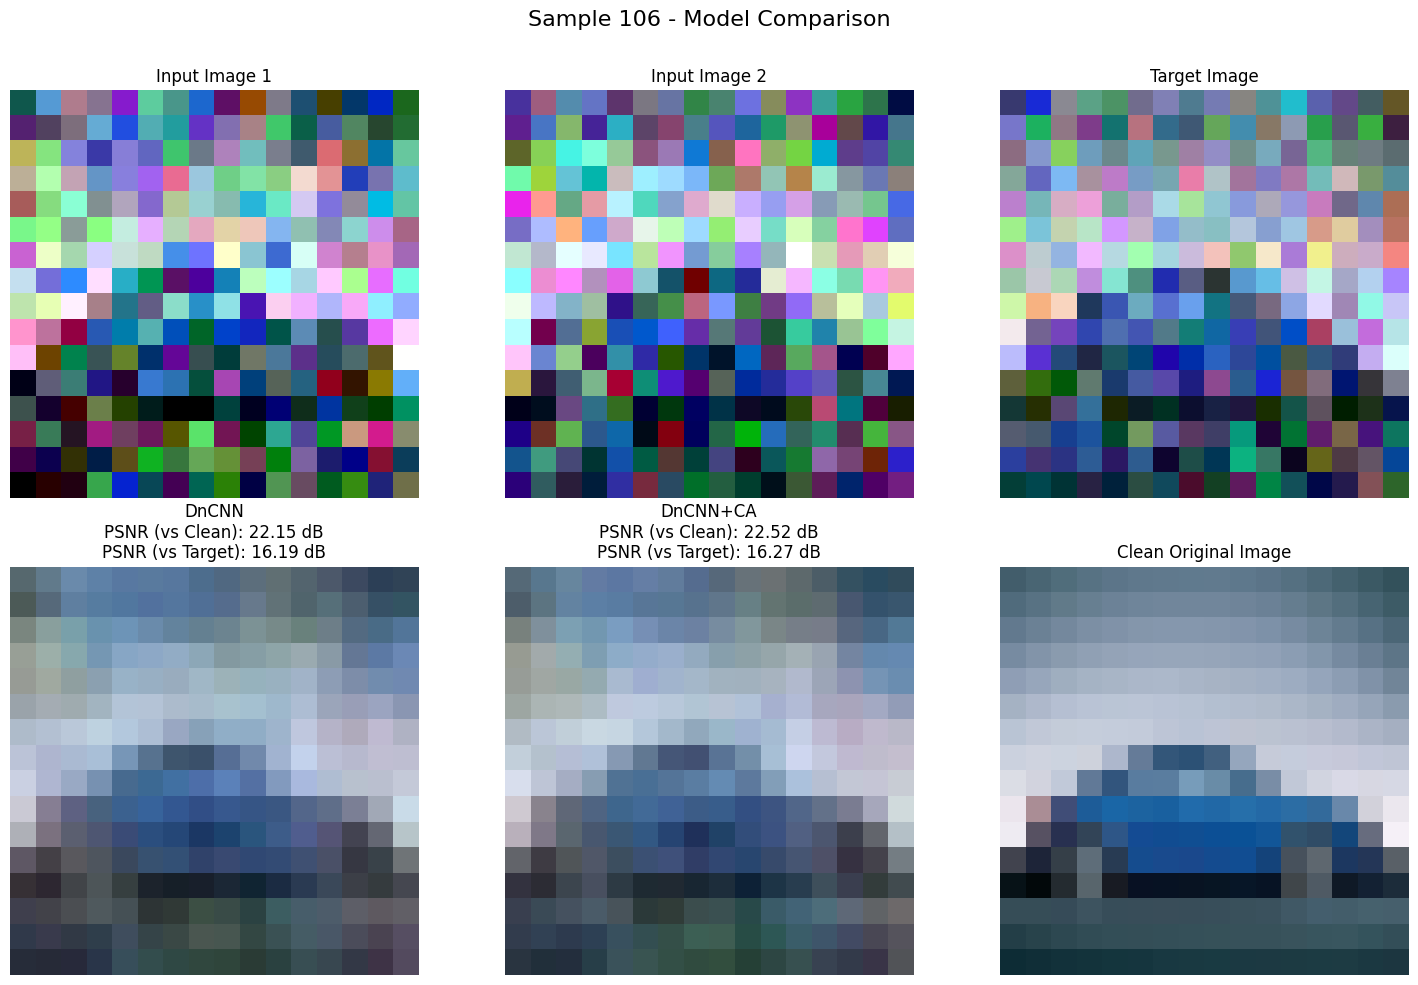

Sample 106:
  DnCNN PSNR vs Clean: 22.15 dB, vs Target: 16.19 dB
  DnCNN+CA PSNR vs Clean: 22.52 dB, vs Target: 16.27 dB
  PSNR 향상 (vs Clean): 0.37 dB (1.65%)
--------------------------------------------------


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import random
from thop import profile

# UNet 모델 정의
class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, features=64):
        """
        경량화된 UNet 모델 (3단계 인코더-디코더 구조)
        
        Args:
            in_channels (int): 입력 채널 수 (2개의 RGB 이미지 concat -> 6)
            out_channels (int): 출력 채널 수 (RGB 이미지 -> 3)
            features (int): 기본 특징 맵 수
        """
        super(UNet, self).__init__()
        
        # 인코더 (다운샘플링 경로)
        self.encoder1 = self._double_conv(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = self._double_conv(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = self._double_conv(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = self._double_conv(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 병목 부분
        self.bottleneck = self._double_conv(features * 8, features * 16)
        
        # 디코더 (업샘플링 경로)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._double_conv(features * 16, features * 8)  # 스킵 연결로 채널 수 2배

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._double_conv(features * 8, features * 4)  # 스킵 연결로 채널 수 2배
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._double_conv(features * 4, features * 2)  # 스킵 연결로 채널 수 2배
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._double_conv(features * 2, features)  # 스킵 연결로 채널 수 2배
        
        # 최종 출력 레이어
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)
    
    def _double_conv(self, in_channels, out_channels):
        """두 번의 컨볼루션 레이어 (Conv -> BN -> ReLU) x 2"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        """
        순전파
        
        Args:
            x: 입력 이미지 텐서 (B, 6, H, W) - 2개의 RGB 이미지 concat
            
        Returns:
            출력 이미지 텐서 (B, 3, H, W)
        """
        # 인코더 경로
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # 병목 부분
        bottleneck = self.bottleneck(self.pool3(enc4))
        
        # 디코더 경로 (스킵 연결 포함)
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # 최종 출력
        return self.conv(dec1)
    
# UNet_CA 모델 정의
class UNet_CA(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, features=64):
        """
        경량화된 UNet 모델 (3단계 인코더-디코더 구조)
        
        Args:
            in_channels (int): 입력 채널 수 (2개의 RGB 이미지 concat -> 6)
            out_channels (int): 출력 채널 수 (RGB 이미지 -> 3)
            features (int): 기본 특징 맵 수
        """
        super(UNet_CA, self).__init__()
        
        # 인코더 (다운샘플링 경로)
        self.encoder1 = self._double_conv(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = self._double_conv(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder3 = self._double_conv(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder4 = self._double_conv(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 병목 부분
        self.bottleneck = self._double_conv(features * 8, features * 8)
        
        # 디코더 (업샘플링 경로)
        self.upconv4 = nn.ConvTranspose2d(features * 8, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._double_conv(features * 16, features * 8)
        
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._double_conv(features * 8, features * 4)  # 스킵 연결로 채널 수 2배
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._double_conv(features * 4, features * 2)  # 스킵 연결로 채널 수 2배
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._double_conv(features * 2, features)  # 스킵 연결로 채널 수 2배
        
        # 최종 출력 레이어
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

        
        # Cross Attention을 위한 변환 레이어
        self.q_proj1 = nn.Conv2d(features * 4, features * 4, kernel_size=1)
        self.k_proj1 = nn.Conv2d(features * 4, features * 4, kernel_size=1)
        self.v_proj1 = nn.Conv2d(features * 4, features * 4, kernel_size=1)

        # 출력 조정을 위한 레이어
        self.out_proj1 = nn.Conv2d(features * 8, features * 8, kernel_size=1)
        
        
    
    def _double_conv(self, in_channels, out_channels):
        """두 번의 컨볼루션 레이어 (Conv -> BN -> ReLU) x 2"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def cross_attention(self, x):
        """
        Cross Attention 레이어
        
        Args:
            x: Query 텐서 (B, C, H, W)
            y: Key, Value 텐서 (B, C, H, W)
        
        Returns:
            Cross Attention 적용 결과
        """
        # Query, Key, Value 텐서 생성
        
        features_half = x.shape[1] // 2
        q_features = x[:, :features_half, ...]
        kv_features = x[:, features_half:, ...]
        
        q = self.q_proj1(q_features)
        k = self.k_proj1(kv_features)
        v = self.v_proj1(kv_features)
        
        # Attention Map 계산
        attn_map = F.softmax(torch.matmul(q, k.transpose(-2, -1)), dim=-1)
        
        # Weighted Sum 계산
        out = torch.matmul(attn_map, v)
        
        out = torch.cat((out, q_features), dim=1)
        
        # 출력 조정
        out = self.out_proj1(out)
        
        return out
    
    def forward(self, x):
        """
        순전파
        
        Args:
            x: 입력 이미지 텐서 (B, 6, H, W) - 2개의 RGB 이미지 concat
            
        Returns:
            출력 이미지 텐서 (B, 3, H, W)
        """
        # 인코더 경로
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # 병목 부분
        bottleneck = self.bottleneck(self.pool3(enc4))
        bottleneck = self.cross_attention(bottleneck)
        
        # 디코더 경로 (스킵 연결 포함)
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
    
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # 최종 출력
        return self.conv(dec1)
    
# PSNR 계산 함수
def calculate_psnr(pred, target, max_val=1.0):
    """
    PSNR(Peak Signal-to-Noise Ratio) 계산 함수
    
    Args:
        pred: 예측 이미지 텐서
        target: 타겟(정답) 이미지 텐서
        max_val: 최대 픽셀 값 (보통 1.0 또는 255)
    
    Returns:
        float: PSNR 값 (dB)
    """
    mse = F.mse_loss(pred, target)
    if mse == 0:
        return float('inf')
    
    return 20 * math.log10(max_val / math.sqrt(mse.item()))

# 테스트 함수
def test_model(model, test_loader, device):
    """
    모델 테스트 및 PSNR 계산
    
    Args:
        model: 테스트할 모델
        test_loader: 테스트 데이터 로더
        device: 디바이스 (CPU/GPU)
        
    Returns:
        tuple: (vs clean PSNR, vs target PSNR)
    """
    model.eval()
    total_psnr_clean = 0.0
    total_psnr_target = 0.0
    count = 0
    
    with torch.no_grad():
        for inputs, targets, cleans in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            cleans = cleans.to(device)
            
            # 모델 예측
            outputs = model(inputs)
            
            # 각 샘플에 대해 PSNR 계산
            batch_size = inputs.size(0)
            for b in range(batch_size):
                # vs 클린 이미지
                psnr_clean = calculate_psnr(outputs[b], cleans[b])
                total_psnr_clean += psnr_clean
                
                # vs 타겟 이미지
                psnr_target = calculate_psnr(outputs[b], targets[b])
                total_psnr_target += psnr_target
                
                count += 1
    
    return total_psnr_clean / count, total_psnr_target / count

# 결과 시각화 함수
def visualize_comparison(model1, model2, dataset, device, sample_indices=None, num_samples=5, model1_name="DnCNN", model2_name="DnCNN+CA"):
    """
    두 모델의 결과 비교 시각화
    
    Args:
        model1: 첫 번째 모델
        model2: 두 번째 모델
        dataset: 데이터셋
        device: 디바이스 (CPU/GPU)
        sample_indices: 샘플 인덱스 리스트 (None이면 랜덤)
        num_samples: 시각화할 샘플 수 (sample_indices가 None일 때 사용)
        model1_name: 첫 번째 모델 이름
        model2_name: 두 번째 모델 이름
    """
    model1.eval()
    model2.eval()
    
    if sample_indices is None:
        # 랜덤으로 샘플 인덱스 선택
        sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx in sample_indices:
        # 데이터셋에서 샘플 가져오기
        sample = dataset[idx]
        
        # DnCNNDatasetWrapper로 변환 (테스트 시에만 사용)
        original_images = sample[:3]  # 첫 3개는 노이즈가 있는 이미지
        clean_img = sample[3]        # 마지막은 깨끗한 원본 이미지
        
        # 입력과 타겟 설정 (첫 2개는 입력으로, 3번째는 타겟으로)
        input_imgs = original_images[:2]
        input_concat = torch.cat(input_imgs, dim=0).unsqueeze(0).to(device)
        target_img = original_images[2].unsqueeze(0).to(device)
        
        # 모델 예측 수행
        with torch.no_grad():
            output1 = model1(input_concat).squeeze(0).cpu()
            output2 = model2(input_concat).squeeze(0).cpu()
            
            # PSNR 계산
            psnr1_clean = calculate_psnr(output1, clean_img)
            psnr2_clean = calculate_psnr(output2, clean_img)
            
            target_cpu = target_img.squeeze(0).cpu()
            psnr1_target = calculate_psnr(output1, target_cpu)
            psnr2_target = calculate_psnr(output2, target_cpu)
        
        # 시각화 (2행 3열: 입력, 타겟, 출력)
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 제목 설정
        fig.suptitle(f"Sample {idx} - Model Comparison", fontsize=16)
        
        # 첫 번째 행: 원본 이미지들
        axes[0, 0].imshow(input_imgs[0].permute(1, 2, 0).clamp(0, 1).numpy())
        axes[0, 0].set_title("Input Image 1")
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(input_imgs[1].permute(1, 2, 0).clamp(0, 1).numpy())
        axes[0, 1].set_title("Input Image 2")
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(target_cpu.permute(1, 2, 0).clamp(0, 1).numpy())
        axes[0, 2].set_title("Target Image")
        axes[0, 2].axis('off')
        
        # 두 번째 행: 모델 출력 및 클린 이미지
        axes[1, 0].imshow(output1.permute(1, 2, 0).clamp(0, 1).numpy())
        axes[1, 0].set_title(f"{model1_name}\nPSNR (vs Clean): {psnr1_clean:.2f} dB\nPSNR (vs Target): {psnr1_target:.2f} dB")
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(output2.permute(1, 2, 0).clamp(0, 1).numpy())
        axes[1, 1].set_title(f"{model2_name}\nPSNR (vs Clean): {psnr2_clean:.2f} dB\nPSNR (vs Target): {psnr2_target:.2f} dB")
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(clean_img.permute(1, 2, 0).clamp(0, 1).numpy())
        axes[1, 2].set_title("Clean Original Image")
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        # PSNR 비교 출력
        print(f"Sample {idx}:")
        print(f"  {model1_name} PSNR vs Clean: {psnr1_clean:.2f} dB, vs Target: {psnr1_target:.2f} dB")
        print(f"  {model2_name} PSNR vs Clean: {psnr2_clean:.2f} dB, vs Target: {psnr2_target:.2f} dB")
        print(f"  PSNR 향상 (vs Clean): {psnr2_clean - psnr1_clean:.2f} dB ({100 * (psnr2_clean - psnr1_clean) / psnr1_clean:.2f}%)")
        print("-" * 50)

# 시드 설정
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 디바이스 설정
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"사용 디바이스: {device}")

# 모델 초기화
dncnn_model = UNet(in_channels=6, out_channels=3).to(device)
dncnn_ca_model = UNet_CA(in_channels=6, out_channels=3).to(device)

# 모델 체크포인트 경로
dncnn_path = f"./checkpoints/best_unet_model_{noise_level}.pth"
dncnn_ca_path = f"./checkpoints/best_unet_model_ca_{noise_level}.pth"
# dncnn_path = "./checkpoints/best_unet_model.pth"
# dncnn_ca_path = "./checkpoints/best_unet_model_ca.pth"

# 모델 체크포인트 로드
try:
    dncnn_model.load_state_dict(torch.load(dncnn_path, map_location=device))
    print(f"DnCNN 모델 로드 성공: {dncnn_path}")
except Exception as e:
    print(f"DnCNN 모델 로드 실패: {e}")

try:
    dncnn_ca_model.load_state_dict(torch.load(dncnn_ca_path, map_location=device))
    print(f"DnCNN+CA 모델 로드 성공: {dncnn_ca_path}")
except Exception as e:
    print(f"DnCNN+CA 모델 로드 실패: {e}")

# 데이터셋 로드
image_dir = './data/cifar10'
kernel_dataset = NoisyKernelSamplingDataset_2(
    image_dir=image_dir,
    kernel_size=2,
    # num_samples=3,
    noise_level=noise_level,
)

# 데이터셋 분할
dataset_size = len(kernel_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
_, _, test_dataset = torch.utils.data.random_split(
    kernel_dataset, [train_size, val_size, test_size]
)

# 래퍼 데이터셋과 데이터로더 생성
test_wrapper_dataset = DnCNNDatasetWrapper(test_dataset, input_indices=(0, 1), target_index=2)
test_loader = DataLoader(test_wrapper_dataset, batch_size=16, shuffle=False, num_workers=0)

# 테스트 수행
print("\nUNet 모델 테스트 중...")
dncnn_psnr_clean, dncnn_psnr_target = test_model(dncnn_model, test_loader, device)

print("\nUNet+CA 모델 테스트 중...")
dncnn_ca_psnr_clean, dncnn_ca_psnr_target = test_model(dncnn_ca_model, test_loader, device)

# 결과 출력
print("\n===== 테스트 결과 =====")
# 모델 파라미터 수와 GFLOPs 계산 함수
def count_parameters_and_flops(model):
    """
    모델의 파라미터 수와 GFLOPs 계산
    
    Args:
        model: 파라미터 수와 GFLOPs를 계산할 모델
        
    Returns:
        tuple: (파라미터 수, GFLOPs)
    """
    params = sum(p.numel() for p in model.parameters())
    input_sample = torch.randn(1, 6, 32, 32).to(device)  # CIFAR-10 이미지 크기 (32x32)
    flops, _ = profile(model, inputs=(input_sample,))
    flops = flops / 1e9  # GFLOPs로 변환
    return params, flops

# DnCNN 모델 파라미터와 GFLOPs
dncnn_params, dncnn_flops = count_parameters_and_flops(dncnn_model)
print(f"DnCNN 모델 파라미터 수: {dncnn_params}, GFLOPs: {dncnn_flops}")

# DnCNN+CA 모델 파라미터와 GFLOPs
dncnn_ca_params, dncnn_ca_flops = count_parameters_and_flops(dncnn_ca_model)
print(f"DnCNN+CA 모델 파라미터 수: {dncnn_ca_params}, GFLOPs: {dncnn_ca_flops}")
print(f"DnCNN vs Clean 평균 PSNR: {dncnn_psnr_clean:.2f} dB, vs Target: {dncnn_psnr_target:.2f} dB")
print(f"DnCNN+CA vs Clean 평균 PSNR: {dncnn_ca_psnr_clean:.2f} dB, vs Target: {dncnn_ca_psnr_target:.2f} dB")
print(f"PSNR 향상 (vs Clean): {dncnn_ca_psnr_clean - dncnn_psnr_clean:.2f} dB ({100 * (dncnn_ca_psnr_clean - dncnn_psnr_clean) / dncnn_psnr_clean:.2f}%)")

# 샘플 5개에 대한 시각화 비교
sample_indices = np.random.randint(0, len(test_dataset), 5)
print("\n두 모델의 결과 시각화 비교 (5개 샘플):")
visualize_comparison(dncnn_model, dncnn_ca_model, test_dataset, device, sample_indices=sample_indices)